In [1]:
from matplotlib.pyplot import *
from matplotlib import pyplot
import math
from scipy.optimize import *
import numpy
import os
import datetime
from scipy.io import loadmat

In [2]:
file_dir = "./data/"
C_limit1 = -0.1
C_limit2 = 1.1
eye_left = -800
eye_right = 500
S_eye_left = -200
S_eye_right = 800
speed_TH = 40

In [3]:
currentDT = datetime.datetime.now()
SavePath = "./results/" + currentDT.strftime("%Y_%m_%d_%H_%M_%S") + "/"
os.mkdir(SavePath)

In [4]:
S_index = -1
StaticSections = []
DynamicSections = []
DY_delaySections = []
GA_delaySections = []
DY_EYSections = []
GA_EYSections = []
MatDatas = []

In [5]:
class Section:
    
    def __init__(self,mode):
        self.sub_index = 0
        self.mode = mode
        self.AZ_RW_dir = []
        self.delay_RW = []
        self.move_target = []
        self.AZ_percent = {}
        self.delay_percent = {}
        self.eye_samples = []
        
    def cal_AC(self):
        AZ_RI_TO = {}
        for ARD in self.AZ_RW_dir:
            if(ARD[0] in AZ_RI_TO):
                AZ_RI_TO[ARD[0]][1] += 1
            else:
                AZ_RI_TO[ARD[0]] = [0,1]
            if(ARD[1] == 1):
                AZ_RI_TO[ARD[0]][0] += 1
        for ART in AZ_RI_TO.keys():
            self.AZ_percent[ART] = float(AZ_RI_TO[ART][0]) / float(AZ_RI_TO[ART][1])
    
    def cal_delay(self):
        DE_RI_TO = {}
        for DR in self.delay_RW:
            if(DR[0] in DE_RI_TO):
                DE_RI_TO[DR[0]][1] += 1
            else:
                DE_RI_TO[DR[0]] = [0,1]
            if(DR[1] == 1):
                DE_RI_TO[DR[0]][0] += 1
        for DRT in DE_RI_TO.keys():
            self.delay_percent[DRT] = float(DE_RI_TO[DRT][0]) / float(DE_RI_TO[DRT][1])

In [6]:
class MatData:
    
    def __init__(self):
        self.init_sample = 0
        self.SA_HS_LES_RES = []
        self.skip_index = []
        self.gaze_speed = []
        self.eye_index = 0
        self.DYTR_HS_ES_GSs = []
        self.GATR_HS_ES_GSs = []
        self.DY_mean = []
        self.GA_mean = []
        self.DY_delete_list = []
        self.GA_delete_list = []
        self.SA_HP_LEP_REP = []
        self.gaze_position = []
        self.DYTR_HP_EP_GPs = []
        self.GATR_HP_EP_GPs = []
        self.DYP_mean = []
        self.GAP_mean = []
        
    def gaze_cal(self):
        self.gaze_speed = self.SA_HS_LES_RES[:,self.eye_index + 2] + self.SA_HS_LES_RES[:,1]
        self.gaze_position = self.SA_HP_LEP_REP[:,self.eye_index + 2] + self.SA_HP_LEP_REP[:,1]
        
    def get_eye_trials(self,section,sectionN = 0):
        for sample in section.eye_samples:
            index = sample - self.init_sample
            start = int(index + eye_left)
            end = int(index + eye_right)
            T_index = -1
            invert = False
            for i in range(start,end):
                if(abs(self.SA_HS_LES_RES[i,1]) > speed_TH):
                    if(self.SA_HS_LES_RES[i,1] < 0):
                        invert = True
                    T_index = i
                    break
            T_start = T_index + S_eye_left
            T_end = T_index + S_eye_right

            matrix = numpy.append([self.SA_HS_LES_RES[int(T_start):int(T_end),1]],\
                        [self.SA_HS_LES_RES[int(T_start):int(T_end),self.eye_index + 2]],\
                        axis=0
                        )
            matrix = numpy.append(matrix,[self.gaze_speed[int(T_start):int(T_end)]],axis=0)
            matrix = matrix.transpose()
            if(invert):
                matrix *= -1
            if(sectionN == 0):
                self.DYTR_HS_ES_GSs.append(matrix)
            elif(sectionN == 1):
                self.GATR_HS_ES_GSs.append(matrix)
                
            matrix2 = numpy.append([self.SA_HP_LEP_REP[int(T_start):int(T_end),1]],\
                        [self.SA_HP_LEP_REP[int(T_start):int(T_end),self.eye_index + 2]],\
                        axis=0
                        )
            matrix2 = numpy.append(matrix2,[self.gaze_position[int(T_start):int(T_end)]],axis=0)
            matrix2 = matrix2.transpose()
            if(invert):
                matrix2 *= -1
            if(sectionN == 0):
                self.DYTR_HP_EP_GPs.append(matrix2)
            elif(sectionN == 1):
                self.GATR_HP_EP_GPs.append(matrix2)
                
    def _self_mean_cal(self,source,target):
        mean_array = numpy.mean(source,axis = 0)
        target.append(mean_array)
        length = len(source[0])
        ele_number = len(source[0][0])
        square_sum = numpy.zeros(shape=(length,ele_number))
        for i in range(0,len(source)):
            square_sum += numpy.power(numpy.absolute(mean_array - source[i]),2)
        square_sum *= 1.0 / float(length)
        target.append(square_sum)
    
    def mean_cal(self):
        self._self_mean_cal(self.DYTR_HS_ES_GSs,self.DY_mean)
        self._self_mean_cal(self.GATR_HS_ES_GSs,self.GA_mean)
        self._self_mean_cal(self.DYTR_HP_EP_GPs,self.DYP_mean)
        self._self_mean_cal(self.GATR_HP_EP_GPs,self.GAP_mean)
    
    def _self_drop_out(self,source,target):
        target = numpy.delete(target,source,0)
        return target
    
    def drop_out(self):
        self.DYTR_HS_ES_GSs = self._self_drop_out(self.DY_delete_list,self.DYTR_HS_ES_GSs)
        self.GATR_HS_ES_GSs = self._self_drop_out(self.GA_delete_list,self.GATR_HS_ES_GSs)
        self.DYTR_HP_EP_GPs = self._self_drop_out(self.DY_delete_list,self.DYTR_HP_EP_GPs)
        self.GATR_HP_EP_GPs = self._self_drop_out(self.GA_delete_list,self.GATR_HP_EP_GPs)

In [7]:
def read_file(AF_name, DF_name,sectionN = 0):
    try:
        file = open(file_dir+AF_name,"r")
        lines = file.readlines()
    except:
        lines = []
    
    section = Section("")
    
    start_flag = False
    S_index = 0
    last_delay = 0.0
    sample = 0
    for line in lines:
        strings = line.split()
        if(len(strings)<1):
            continue
        if(strings[1] == "start"):
            if(S_index == sectionN):
                start_flag = True
                section.mode = strings[4]
            else:
                start_flag = False
            S_index += 1
        if(start_flag):
            try:
                AZ = int(strings[3])
            except:
                AZ = -100
            if(AZ >= 0):
                RW = 1 if (strings[4] == "True") else 0
                section.AZ_RW_dir.append((AZ,RW,strings[5]))
                section.delay_RW.append((last_delay,RW))
            if(AZ == -2):
                try:
                    last_delay = float(strings[4])
                except:
                    last_delay = -1.0
                try:
                    sample = int(strings[1])
                except:
                    sample = -1
                section.eye_samples.append(sample)
    file.close()
    
    try:
        file = open(file_dir+DF_name,"r")
        lines = file.readlines()
    except:
        lines = []
    
    for line in lines:
        strings = line.split()
        if(len(strings)<1):
            continue
        if(strings[4] == "MoveTarget"):
            try:
                simS = int(strings[2])
                degree = float(strings[5]) if (strings[6] == "1") else -(float(strings[5]))
            except:
                simS = int(-1)
                degree = 0.0
            section.move_target.append((simS,degree))
            
            
    return section

In [8]:
def read_mat(filename):
    MD = MatData()
    file = loadmat(file_dir+filename)
    MD.init_sample = file['sampleNo'][0]
    MD.SA_HS_LES_RES = numpy.column_stack((file['sampleNo'],file['head'][0][0][1][:,2],file['leftEye'][0][0][1][:,2],file['rightEye'][0][0][1][:,2]))
    MD.SA_HP_LEP_REP = numpy.column_stack((file['sampleNo'],file['head'][0][0][0][:,2],file['leftEye'][0][0][0][:,2],file['rightEye'][0][0][0][:,2]))
    return MD

In [9]:
def plotplot(x_data,y_data,legends,limit1,limit2):
    ylim(limit1, limit2)
    tpl, = plot(x_data,y_data,label = legends)
    return tpl

In [10]:
def plot_ac(section,lab_mode = 0):
    x_data = sorted(section.AZ_percent.keys())
    y_data = []
    for x in x_data:
        y_data.append(section.AZ_percent[x])
    if(lab_mode == 0):
        tpl = plotplot(x_data,y_data,section.mode,C_limit1,C_limit2)
    elif(lab_mode == 1):
        tpl = plotplot(x_data,y_data,section.sub_index,C_limit1,C_limit2)
    return tpl

In [11]:
def plot_ST_DY(section1,section2):
    pyplot.rcParams["figure.figsize"] = (20,10)
    pyplot.title("Acuities")
    tpl1 = plot_ac(section1)
    tpl2 = plot_ac(section2)
    pyplot.legend(handles=[tpl1, tpl2])
    pyplot.savefig(SavePath+"AcuityResult_S"+str(S_index)+".png")
    pyplot.show()

In [12]:
def plot_delay(section,lab_mode = 0):
    x_data = sorted(section.delay_percent.keys())
    y_data = []
    for x in x_data:
        y_data.append(section.delay_percent[x])
    if(lab_mode == 0):
        tpl = plotplot(x_data,y_data,section.mode,C_limit1,C_limit2)
    elif(lab_mode == 1):
        tpl = plotplot(x_data,y_data,section.sub_index,C_limit1,C_limit2)
    return tpl

In [13]:
def plot_DYD_GAD(section1,section2):
    section2.mode = "GazeShift"
    pyplot.rcParams["figure.figsize"] = (20,10)
    pyplot.title("Delays")
    tpl1 = plot_delay(section1)
    tpl2 = plot_delay(section2)
    pyplot.legend(handles=[tpl1, tpl2])
    pyplot.savefig(SavePath+"DelayResult_"+str(S_index)+".png")
    pyplot.show()

In [14]:
def plot_eye_single(index, mat_data):
    pyplot.rcParams["figure.figsize"] = (20,10)
    labels = ["HeadSpeed","EyeSpeed","GazeSpeed"]
    x_data = range(0,S_eye_right-S_eye_left)
    y_data = []
    tpls = []
    start = int(index + eye_left)
    end = int(index + eye_right)
    T_index = -1
    for i in range(start,end):
        if(abs(mat_data.SA_HS_LES_RES[i,1]) > speed_TH):
            T_index = i
            break
    T_start = T_index + S_eye_left
    T_end = T_index + S_eye_right
    
    y_data = mat_data.SA_HS_LES_RES[int(T_start):int(T_end),1]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = mat_data.SA_HS_LES_RES[int(T_start):int(T_end),mat_data.eye_index + 2]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = mat_data.gaze_speed[int(T_start):int(T_end)]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    return tpls

In [15]:
def plot_eye_trial(trial):
    pyplot.rcParams["figure.figsize"] = (20,10)
    labels = ["HeadSpeed","EyeSpeed","GazeSpeed"]
    x_data = range(0,len(trial))
    y_data = []
    tpls = []
    
    y_data = trial[:,0]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = trial[:,1]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = trial[:,2]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    
    return tpls

In [16]:
def plot_eye_trial_pos(trial):
    pyplot.rcParams["figure.figsize"] = (20,10)
    labels = ["HeadPosition","EyePosition","GazePosition"]
    x_data = range(0,len(trial))
    y_data = []
    tpls = []
    
    y_data = trial[:,0]
    tpl, = plot(x_data,y_data,label = labels[0])
    tpls.append(tpl)
    
    y_data = trial[:,1]
    tpl, = plot(x_data,y_data,label = labels[1])
    tpls.append(tpl)
    
    y_data = trial[:,2]
    tpl, = plot(x_data,y_data,label = labels[2])
    tpls.append(tpl)
    
    return tpls

In [17]:
def plot_eye(mat_data,sectionN = 0):
    trials = []
    if(sectionN == 0):
        trials = mat_data.DYTR_HS_ES_GSs
        pyplot.title("DynamicSpeed")
    if(sectionN == 1):
        trials = mat_data.GATR_HS_ES_GSs
        pyplot.title("GazeShiftSpeed")
    for trial in trials:
        tpl = plot_eye_trial(trial)
        pyplot.legend(handles = tpl)
        pyplot.show()
    return tpl


In [18]:
def plot_eye_pos(mat_data,sectionN = 0):
    trials = []
    if(sectionN == 0):
        trials = mat_data.DYTR_HP_EP_GPs
        pyplot.title("DynamicPosition")
    if(sectionN == 1):
        trials = mat_data.GATR_HP_EP_GPs
        pyplot.title("GazeShiftPosition")
    for trial in trials:
        tpl = plot_eye_trial_pos(trial)
        pyplot.legend(handles = tpl)
        pyplot.show()
    return tpl

In [19]:
def plot_eye_mean(mean_arrs,mode = 0):
    pyplot.rcParams["figure.figsize"] = (20,10)
    pyplot.title("MeanPlot")
    mean_arr = mean_arrs[mode]
    tpls = plot_eye_trial_pos(mean_arr)
    pyplot.legend(handles = tpls)
    pyplot.show()
    return tpls

In [20]:
def run_subject(para,DY_DL = [], GA_DL = []):
    AC_log1 = para[0]
    AC_log2 = para[1]
    JU_log1 = para[2]
    JU_log2 = para[3]
    JU_log3 = para[4]
    EY_log = para[5]
    EY_JU_log = para[6]
    Mat_log = para[7]
    eye_index = int(para[8])
    
    section1 = read_file(AC_log1,JU_log1,sectionN = 0)
    section2 = read_file(AC_log1,JU_log1,sectionN = 1)
    section3 = read_file(AC_log2,JU_log2,sectionN = 0)
    section4 = read_file(AC_log2,JU_log3,sectionN = 1)
    section5 = read_file(EY_log,EY_JU_log,sectionN = 0)
    section6 = read_file(EY_log,EY_JU_log,sectionN = 1)
    section1.sub_index = S_index
    section2.sub_index = S_index
    section3.sub_index = S_index
    section4.sub_index = S_index
    section5.sub_index = S_index
    section6.sub_index = S_index
    mat_data = read_mat(Mat_log)
    mat_data.eye_index = eye_index
    mat_data.DY_delete_list = DY_DL
    mat_data.GA_delete_list = GA_DL
    
    section1.cal_AC()
    section2.cal_AC()
    section3.cal_delay()
    section4.cal_delay()
    section5.mode = "DynamicEye"
    section6.mode = "GazeShiftEye"
    mat_data.gaze_cal()
    mat_data.get_eye_trials(section5,0)
    mat_data.get_eye_trials(section6,1)
    mat_data.drop_out()
    mat_data.mean_cal()
    
    plot_ST_DY(section1,section2)
    plot_DYD_GAD(section3,section4)
    plot_eye_pos(mat_data,sectionN = 0)
    plot_eye_pos(mat_data,sectionN = 1)
    plot_eye_mean(mat_data.DYP_mean,0)
    plot_eye_mean(mat_data.GAP_mean,0)
    plot_eye_mean(mat_data.DYP_mean,1)
    plot_eye_mean(mat_data.GAP_mean,1)
    
    StaticSections.append(section1)
    DynamicSections.append(section2)
    DY_delaySections.append(section3)
    GA_delaySections.append(section4)
    DY_EYSections.append(section5)
    GA_EYSections.append(section6)
    MatDatas.append(mat_data)

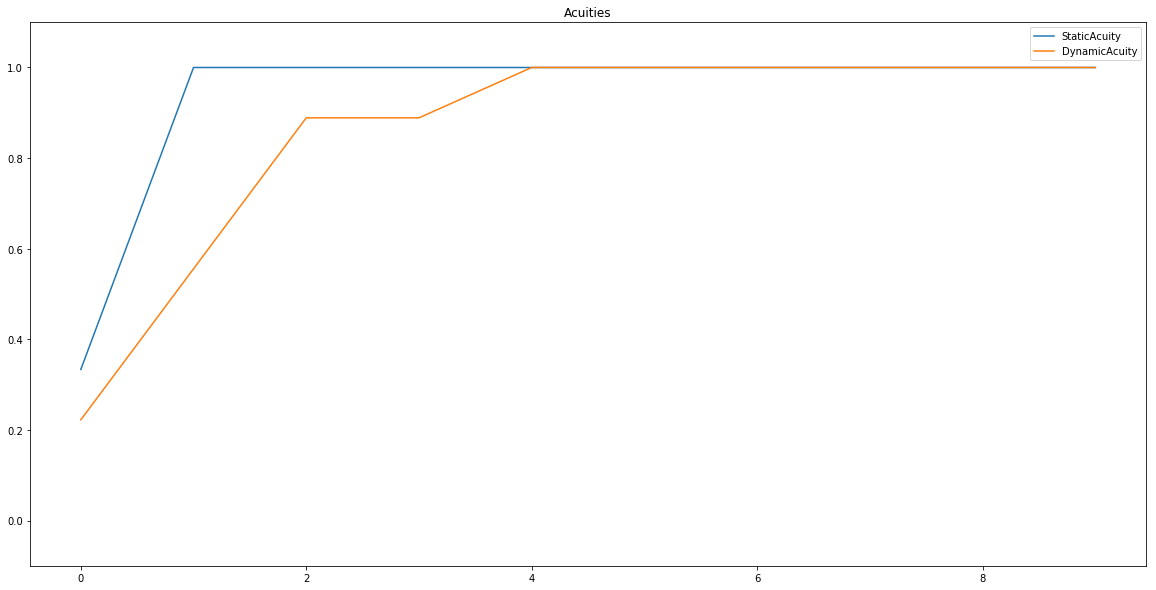

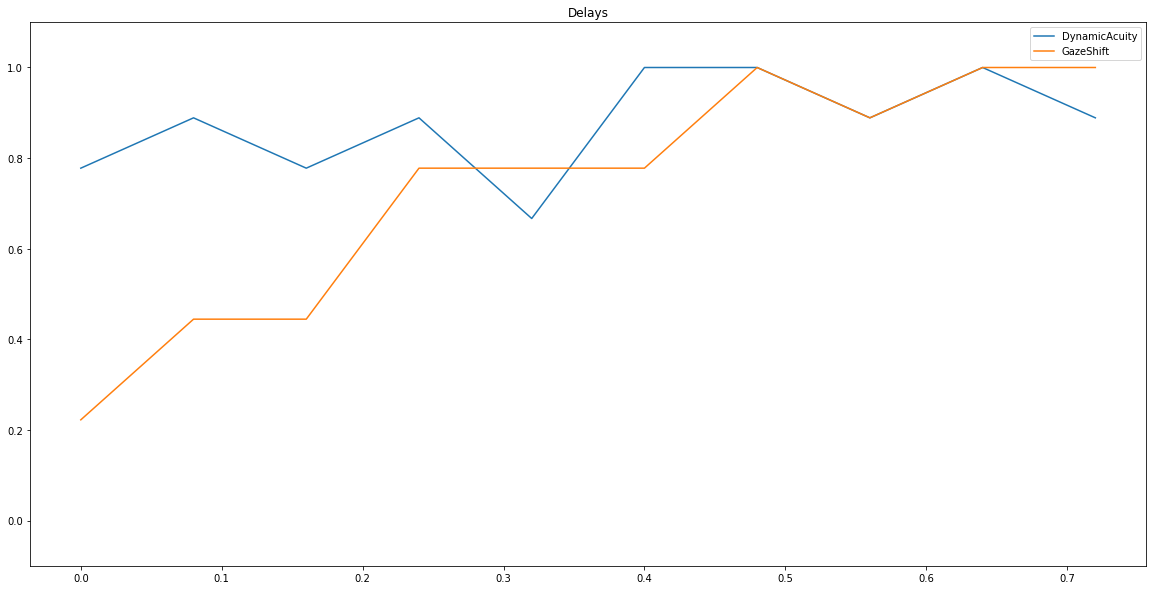

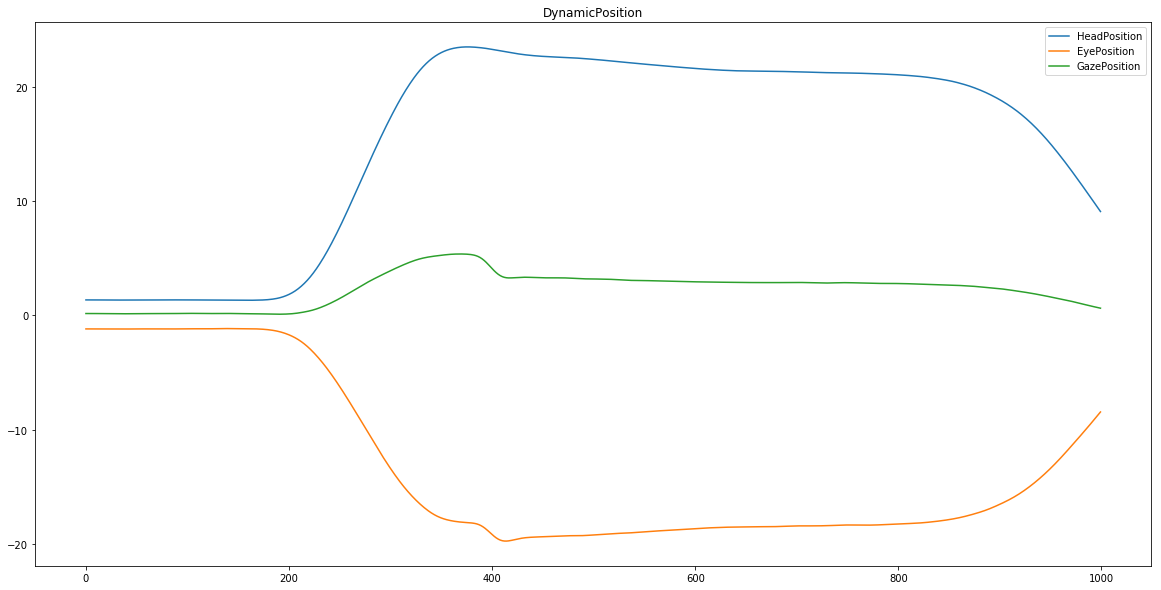

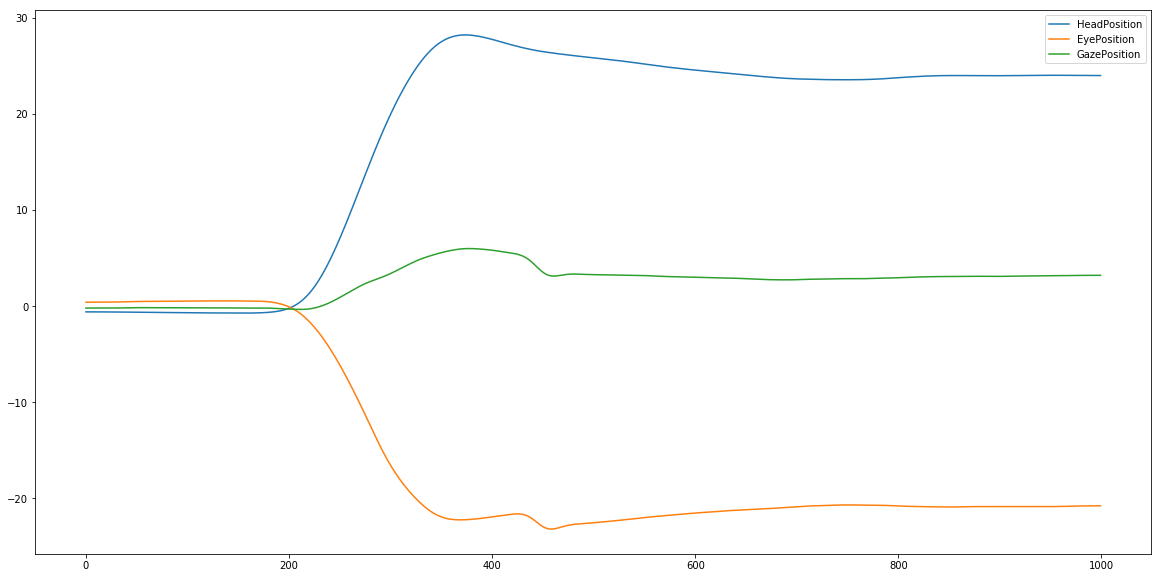

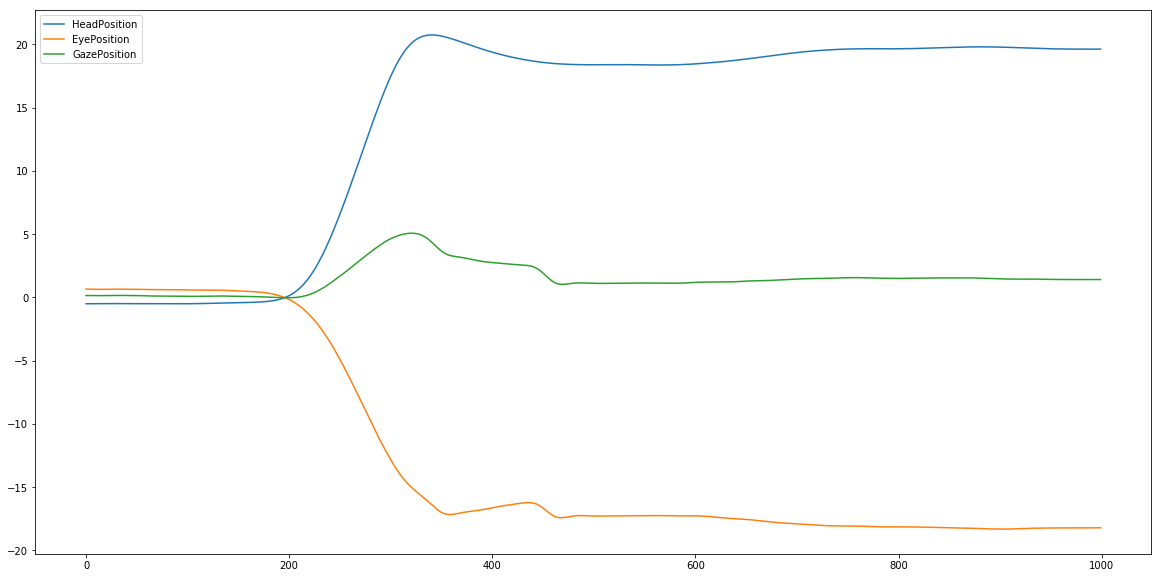

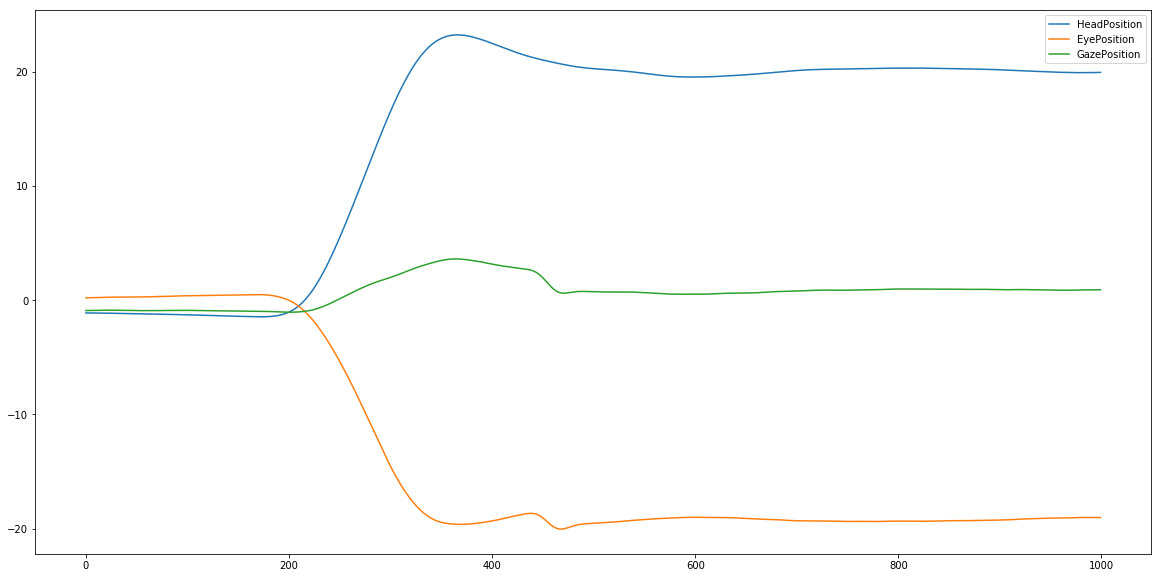

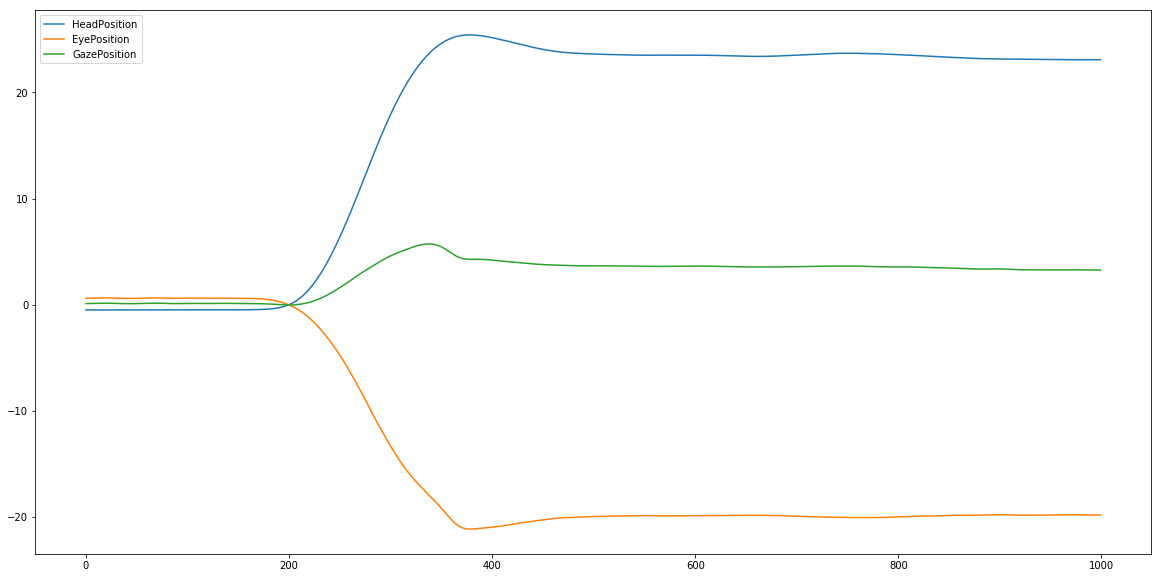

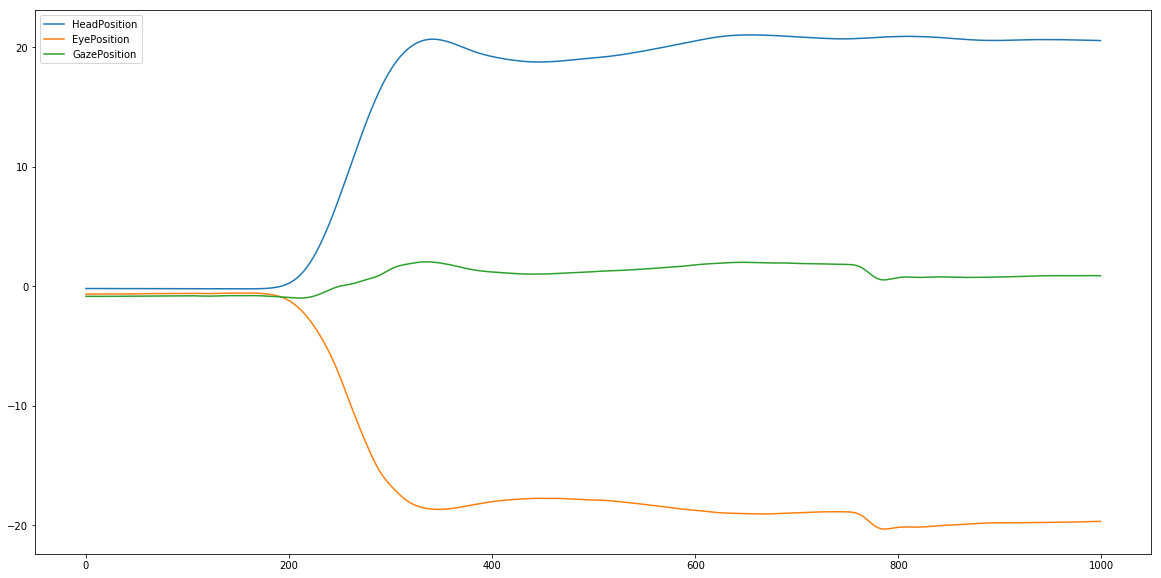

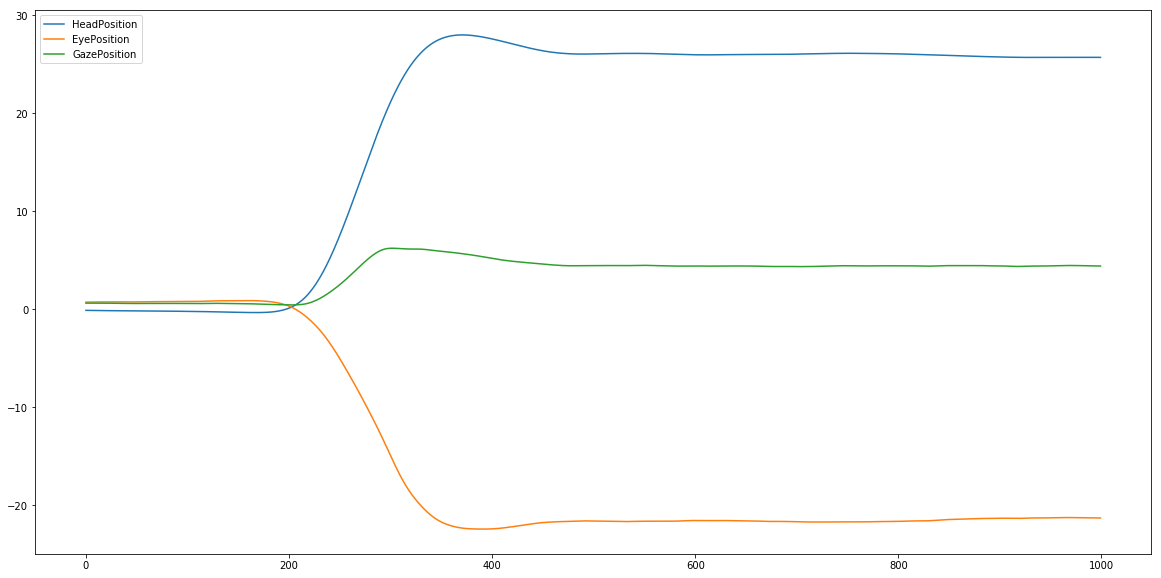

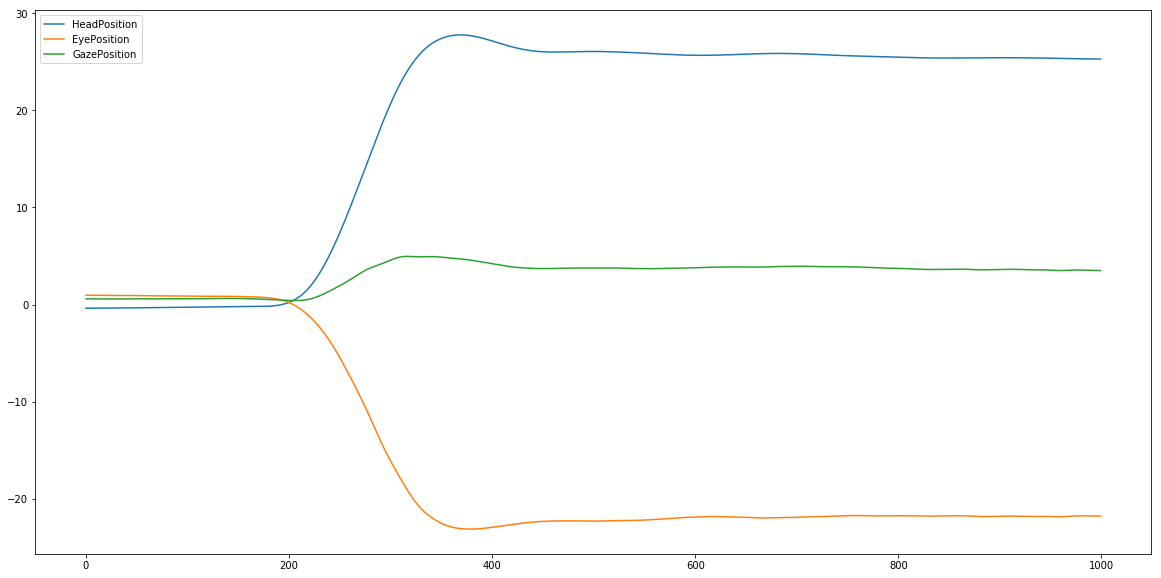

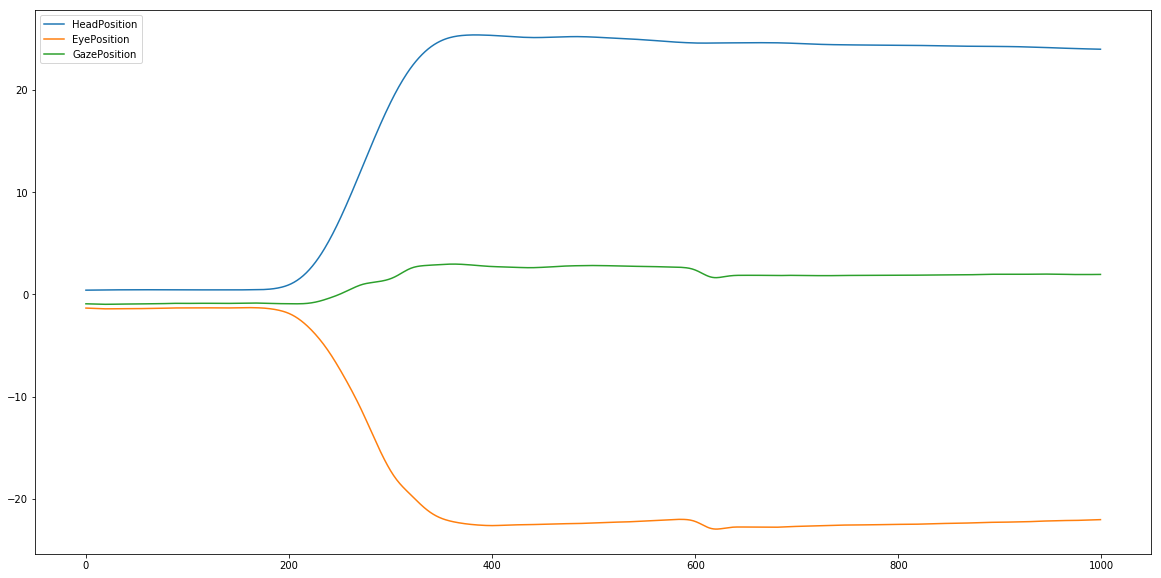

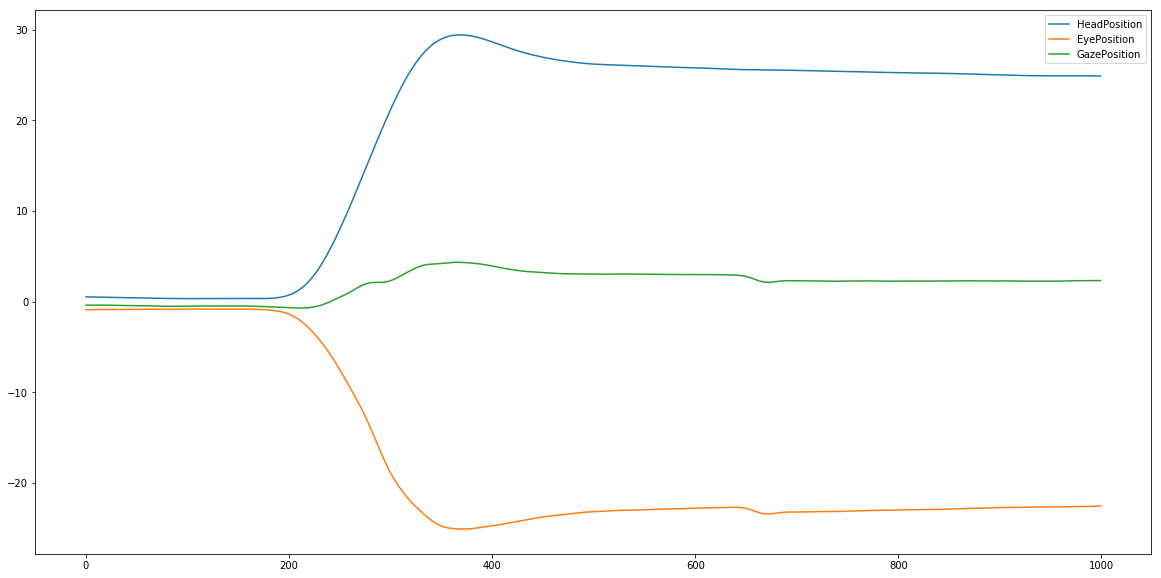

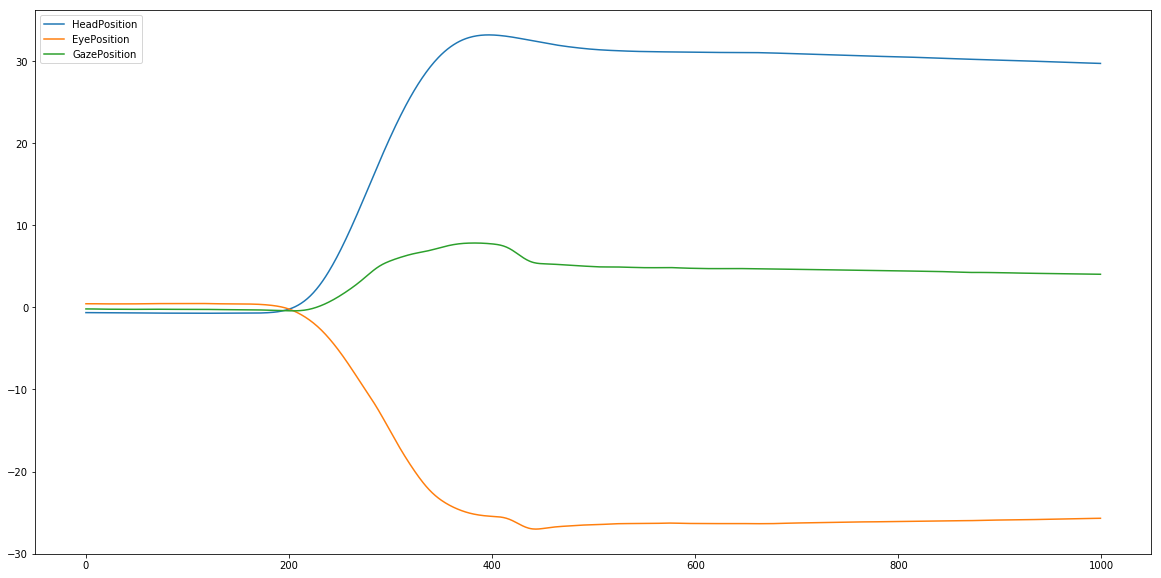

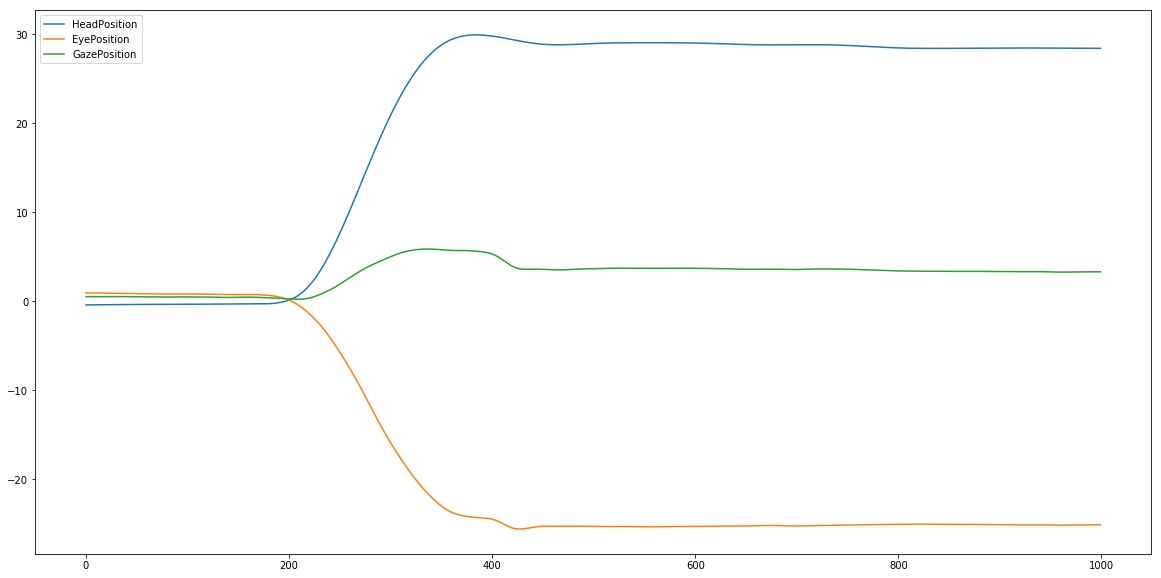

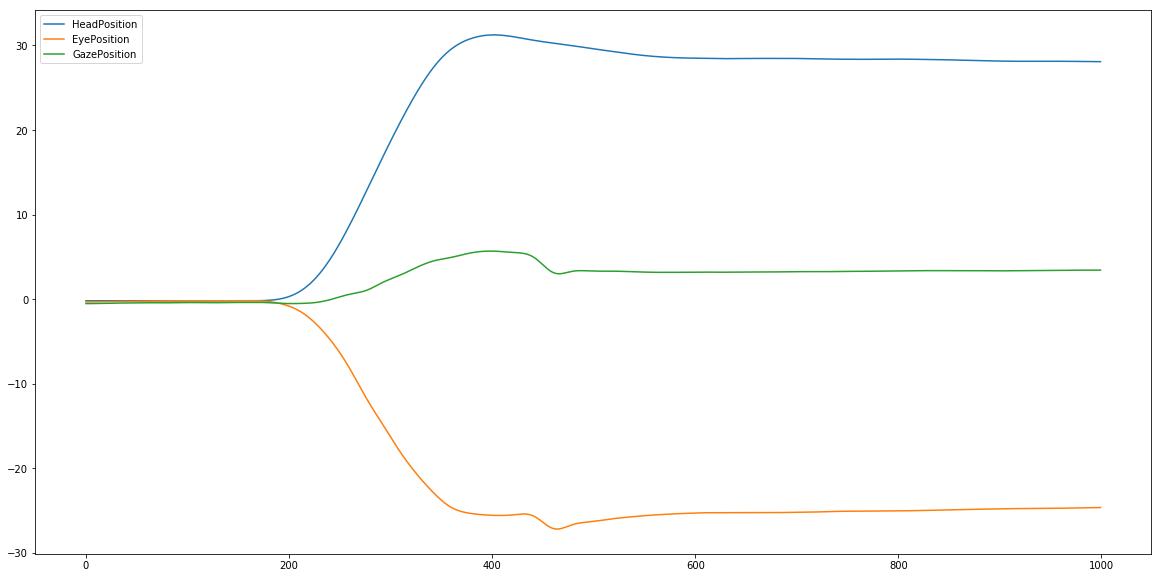

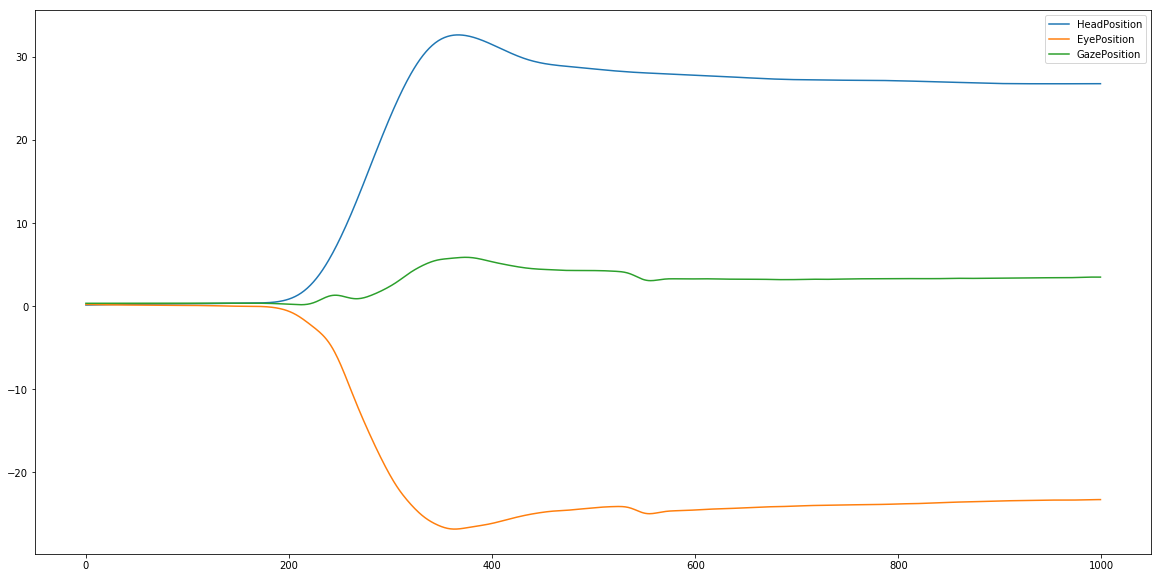

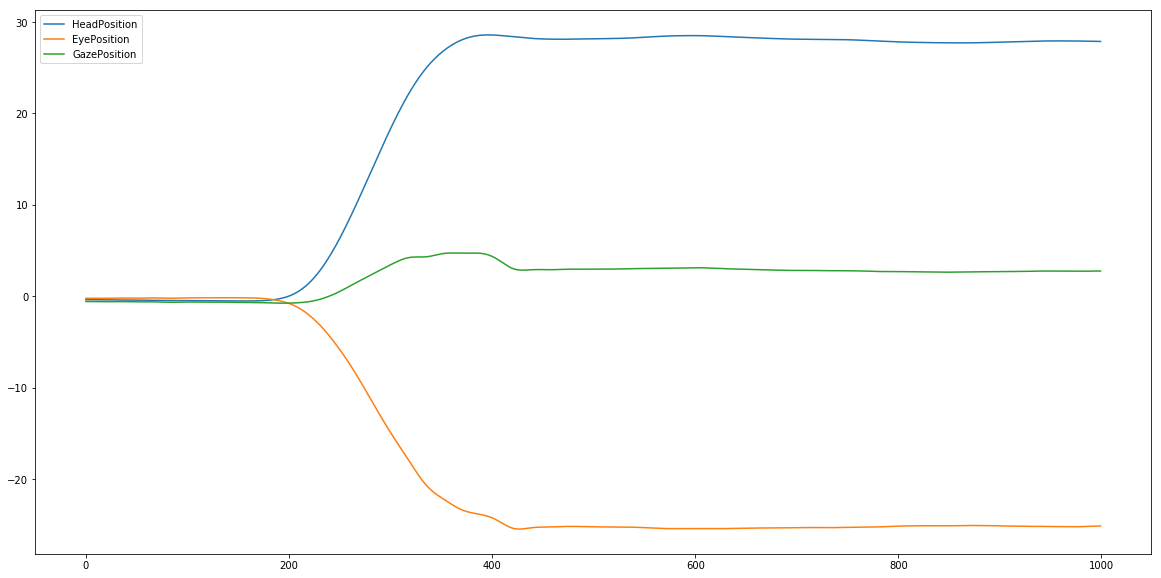

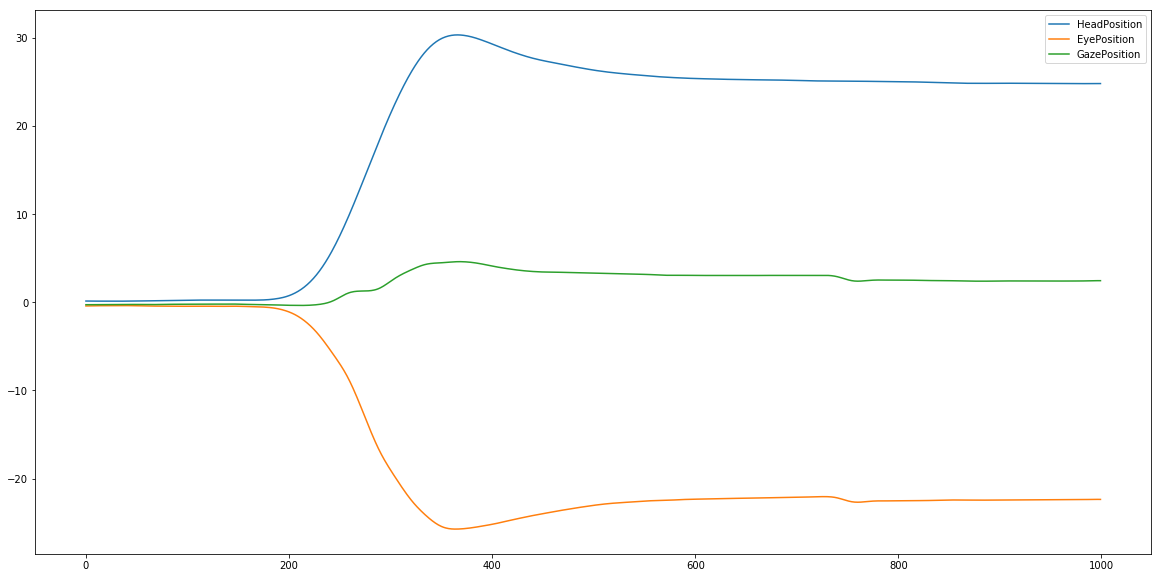

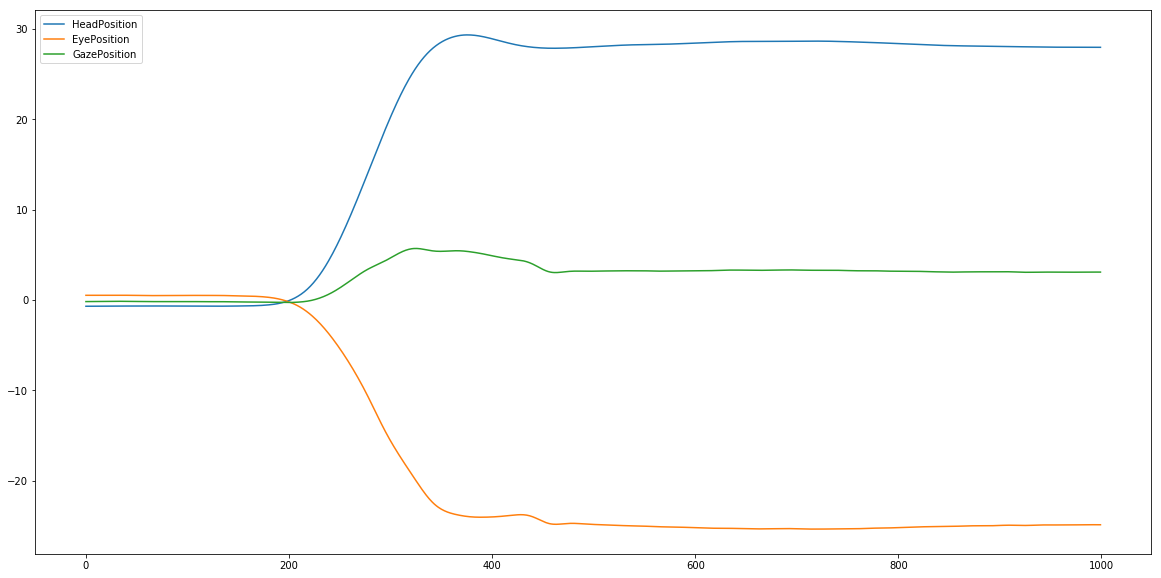

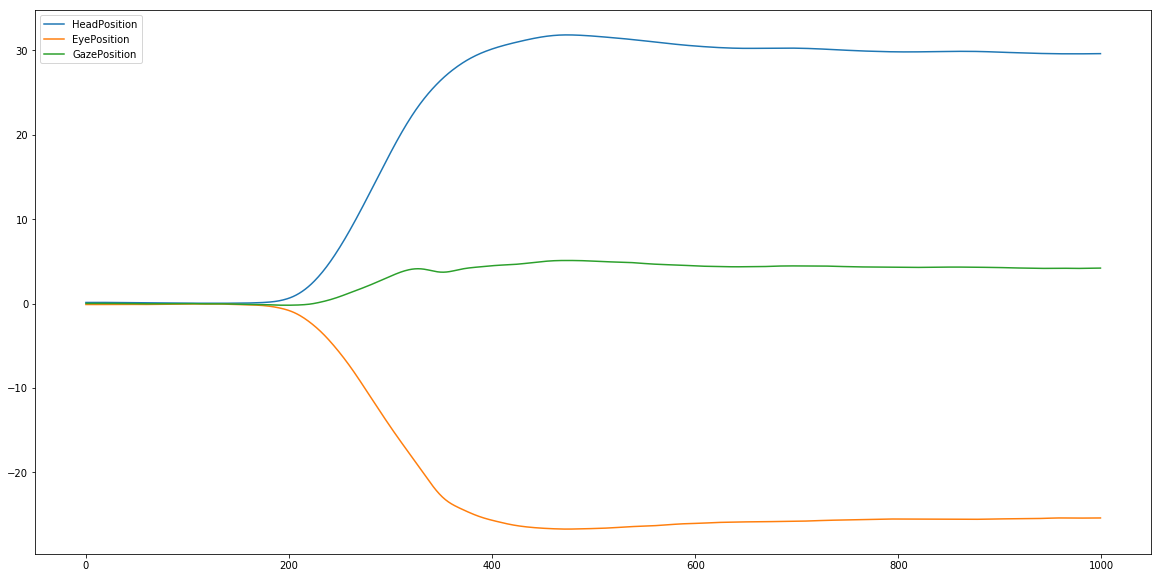

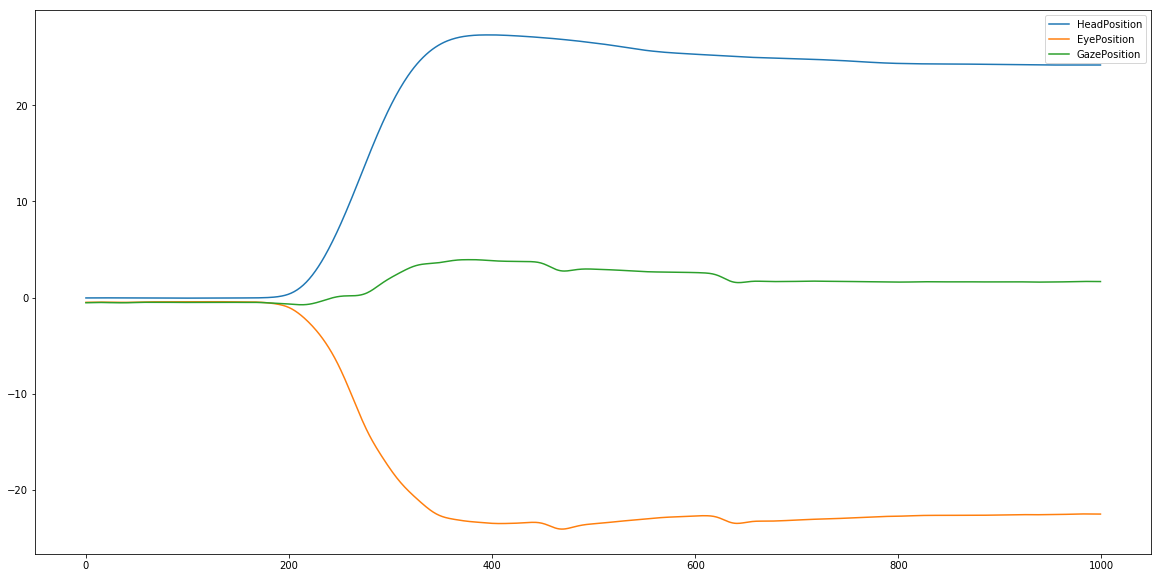

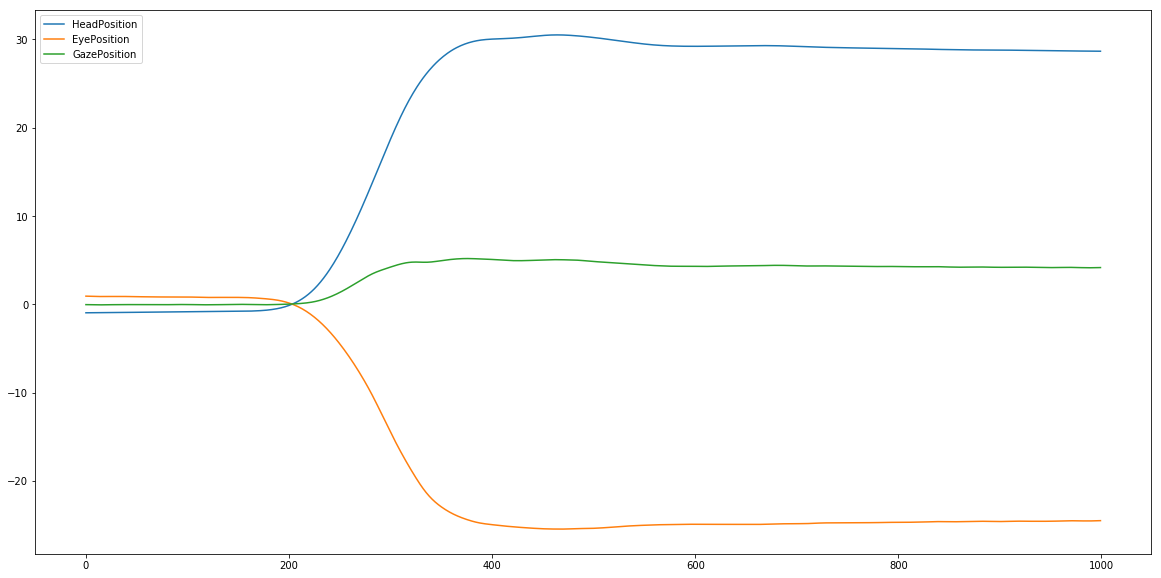

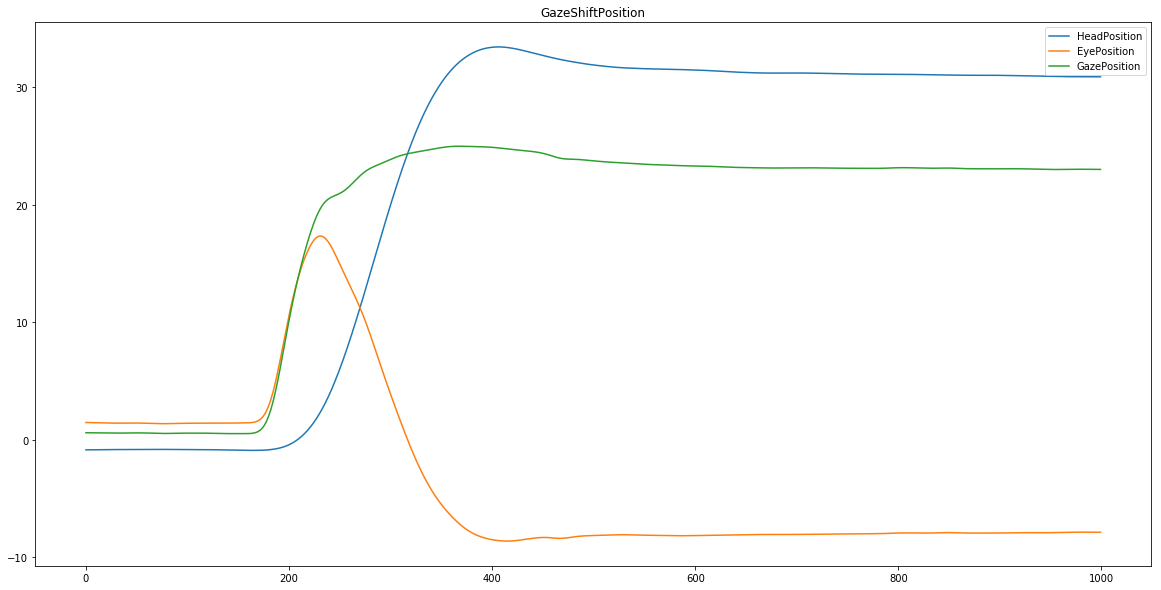

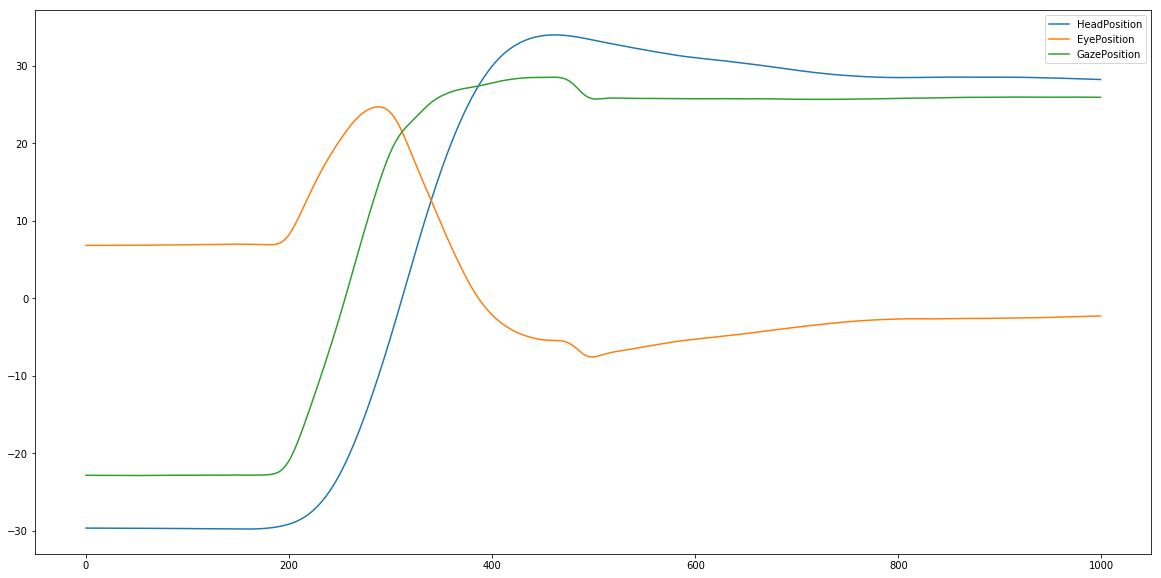

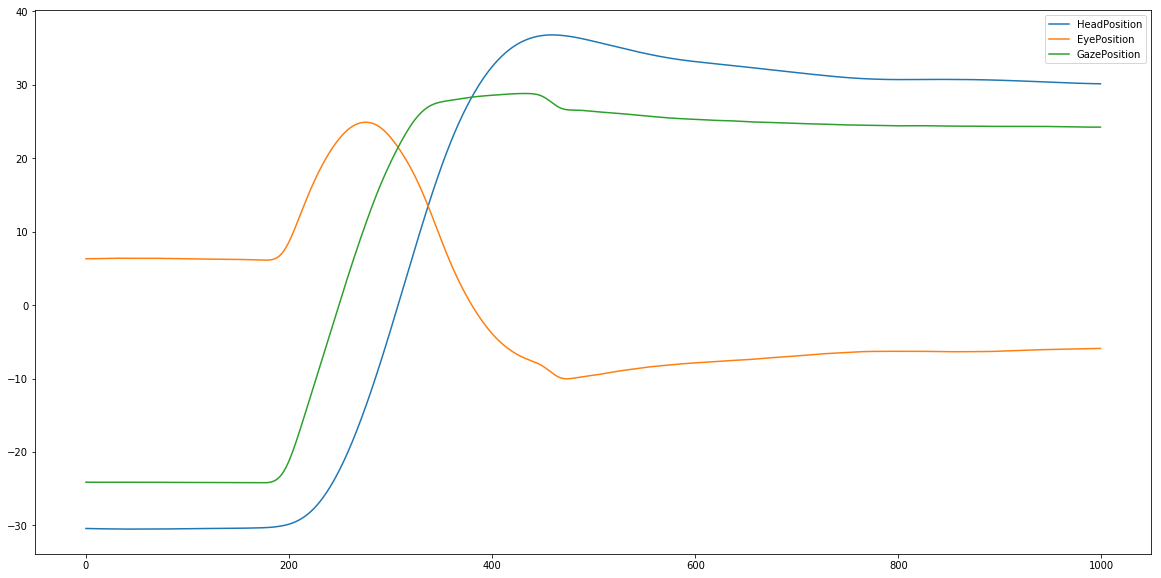

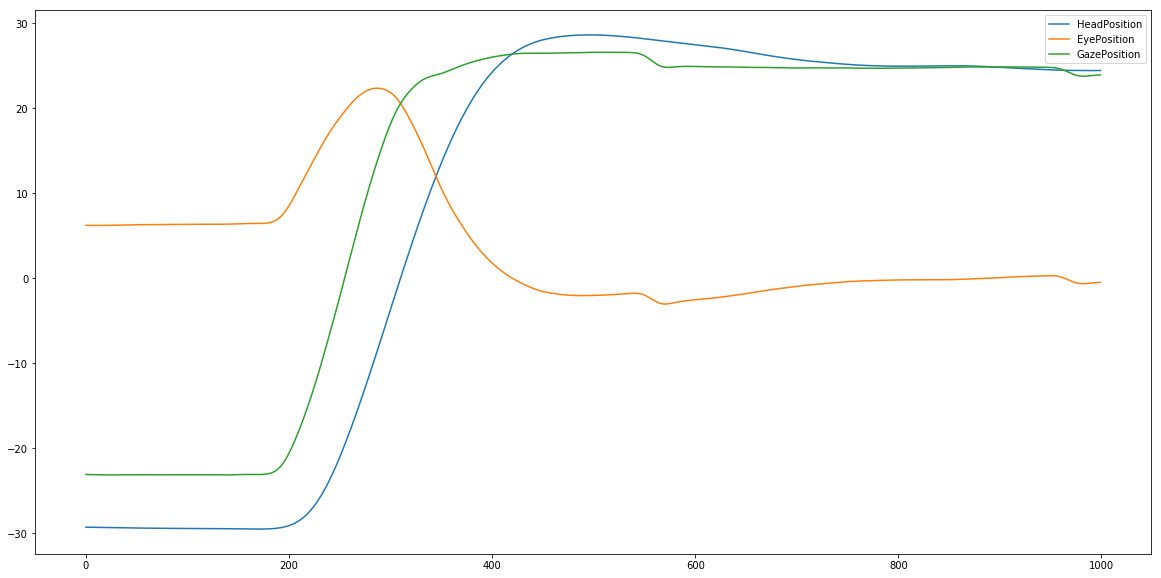

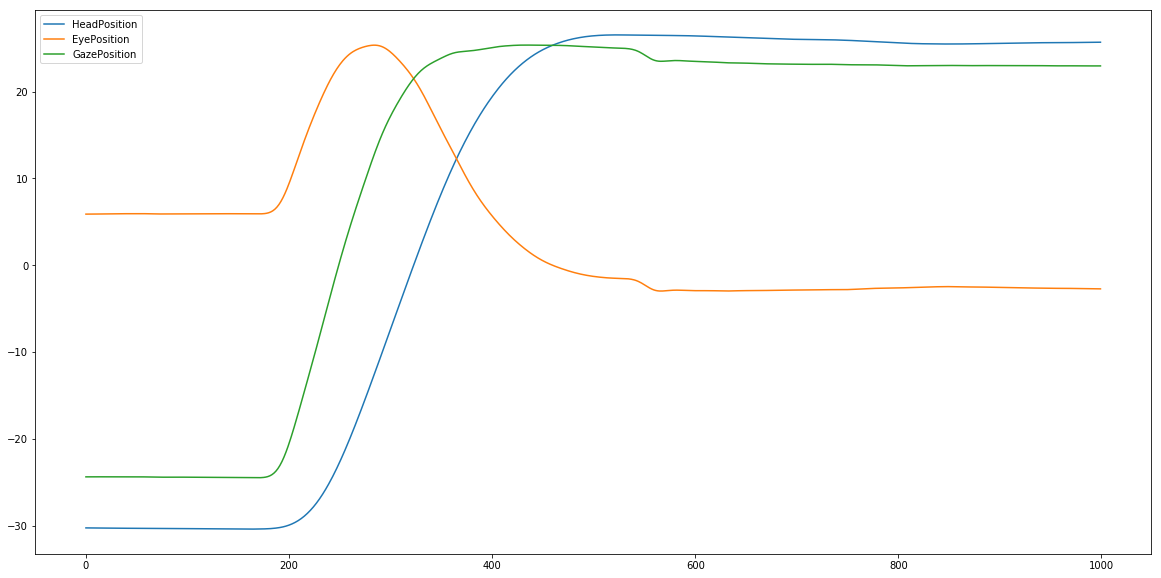

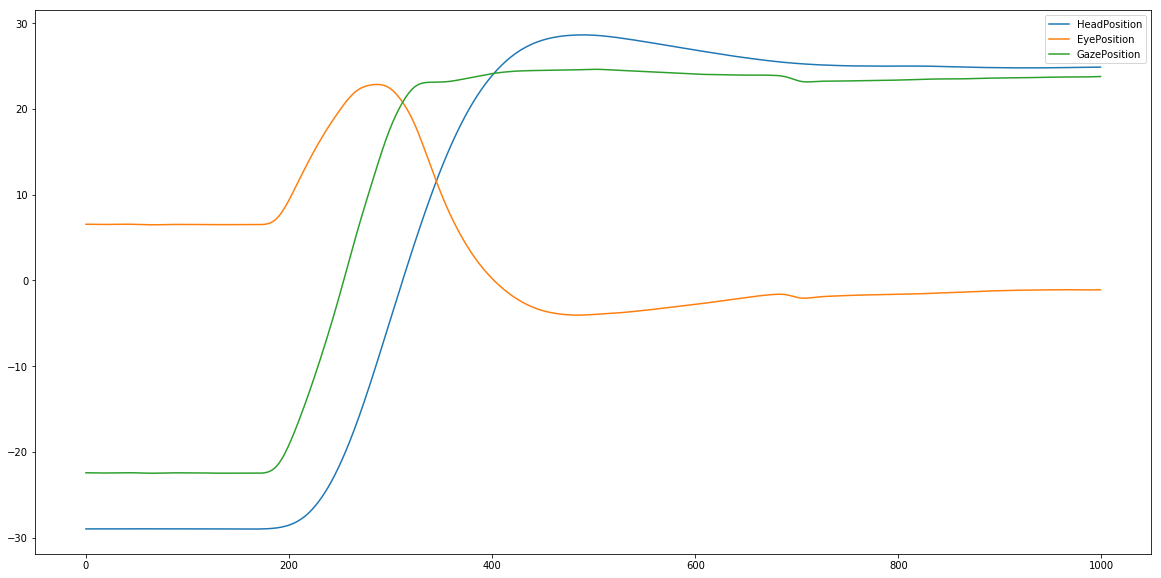

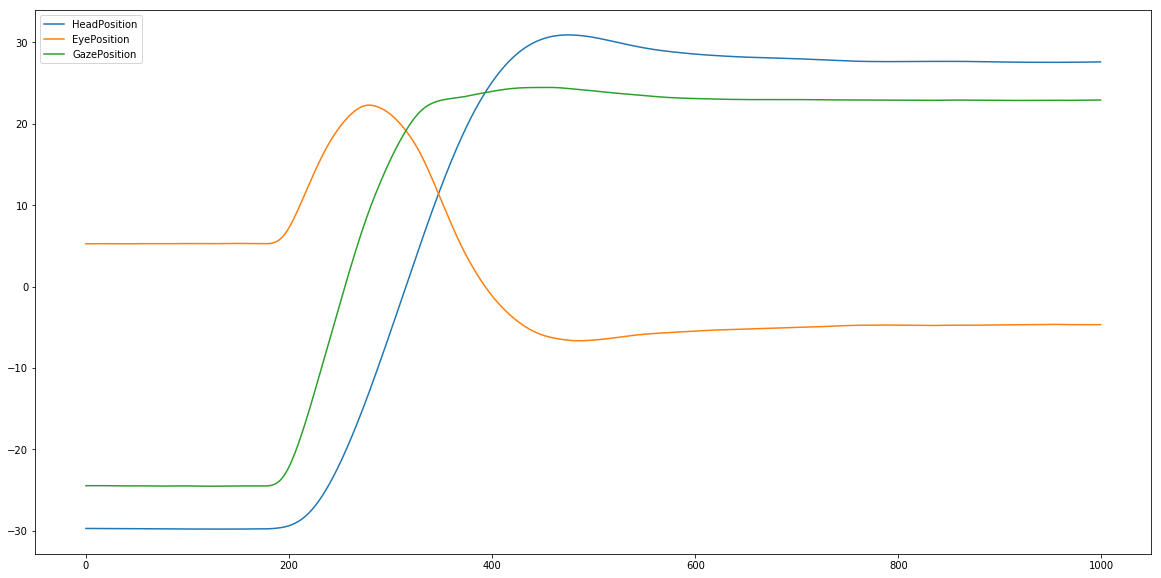

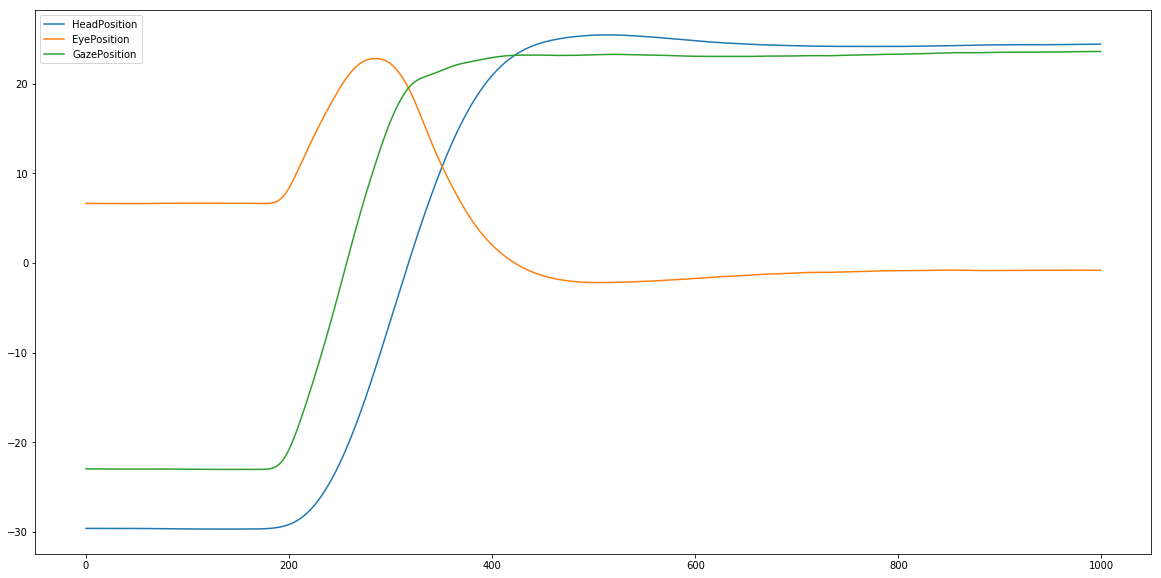

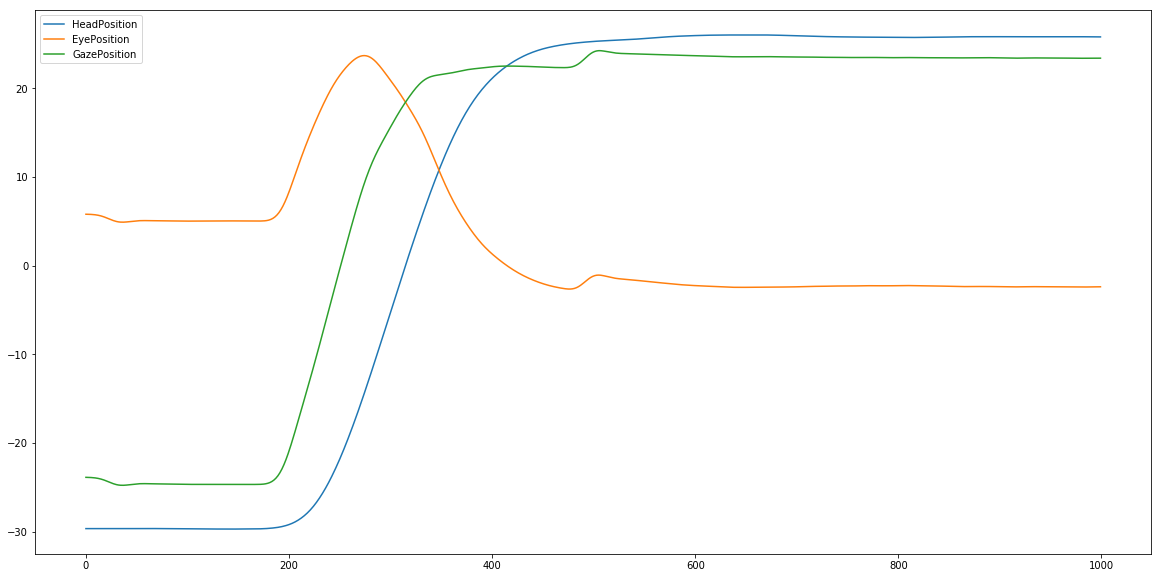

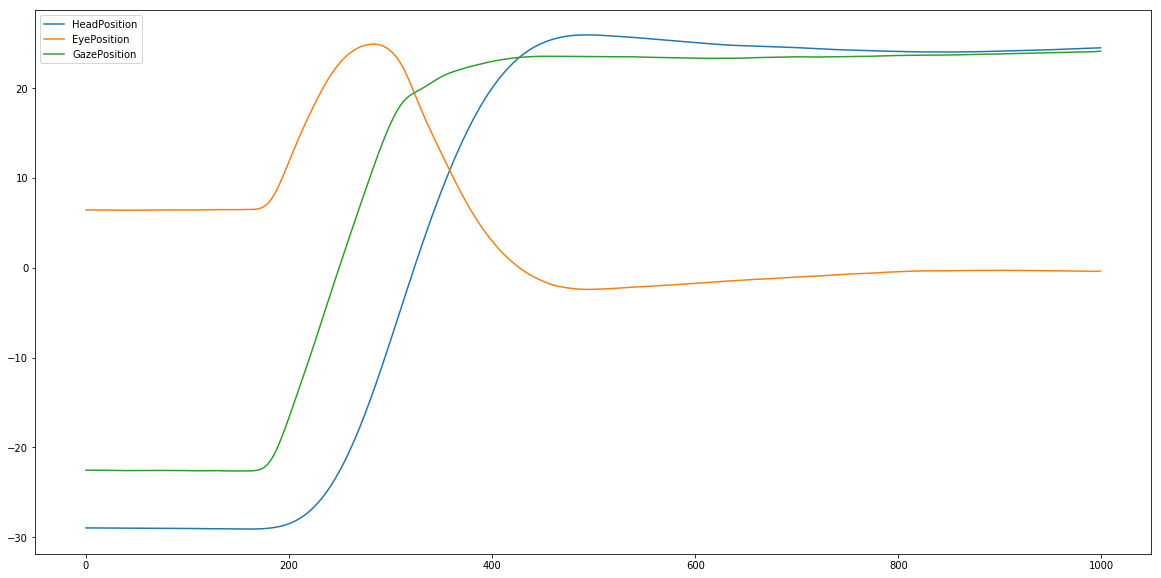

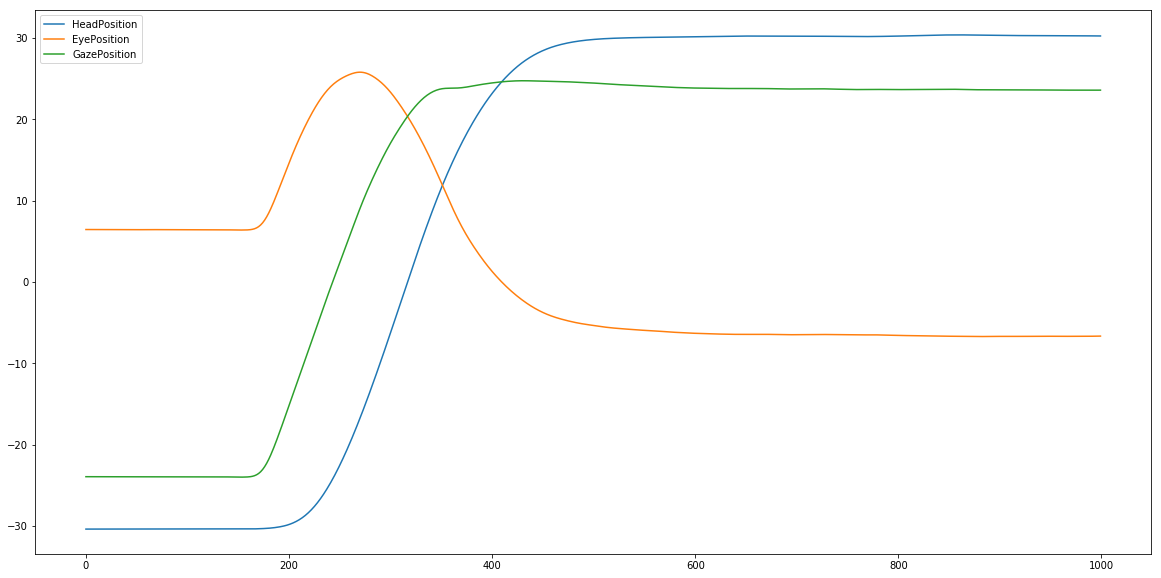

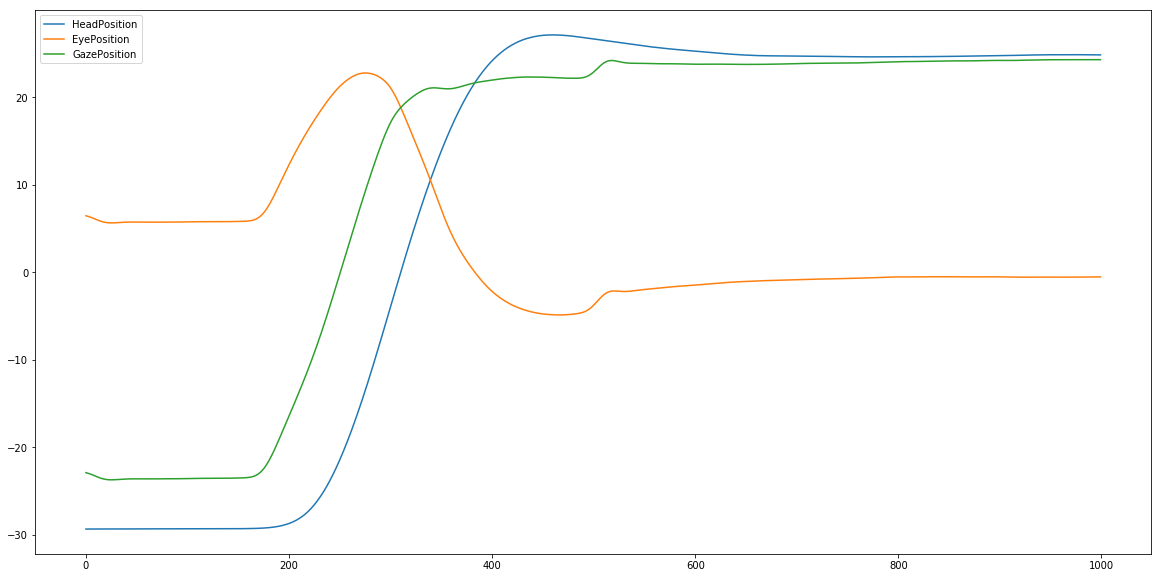

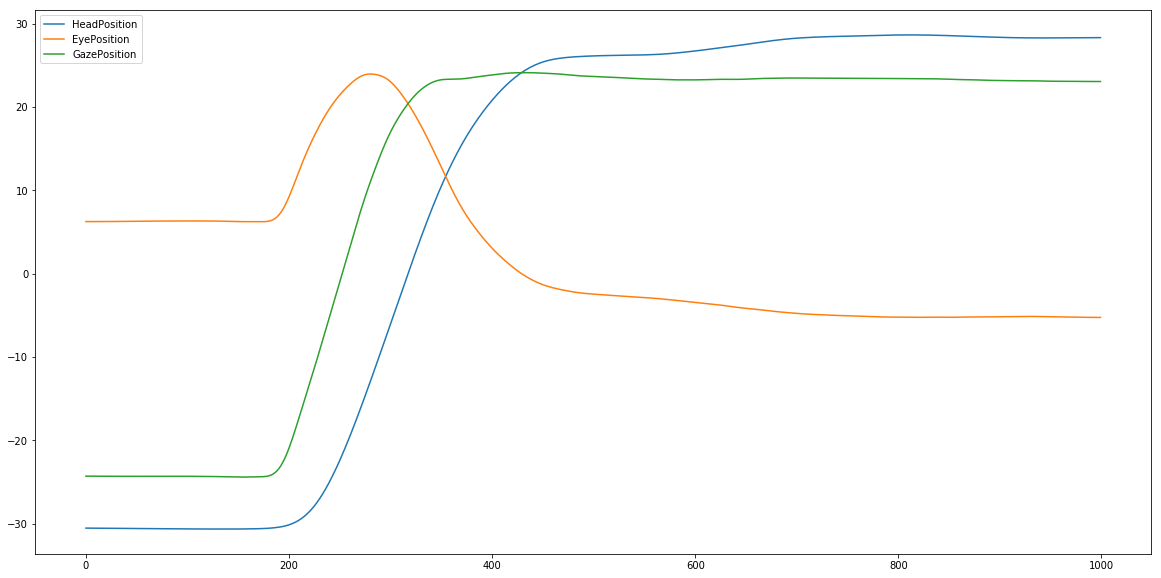

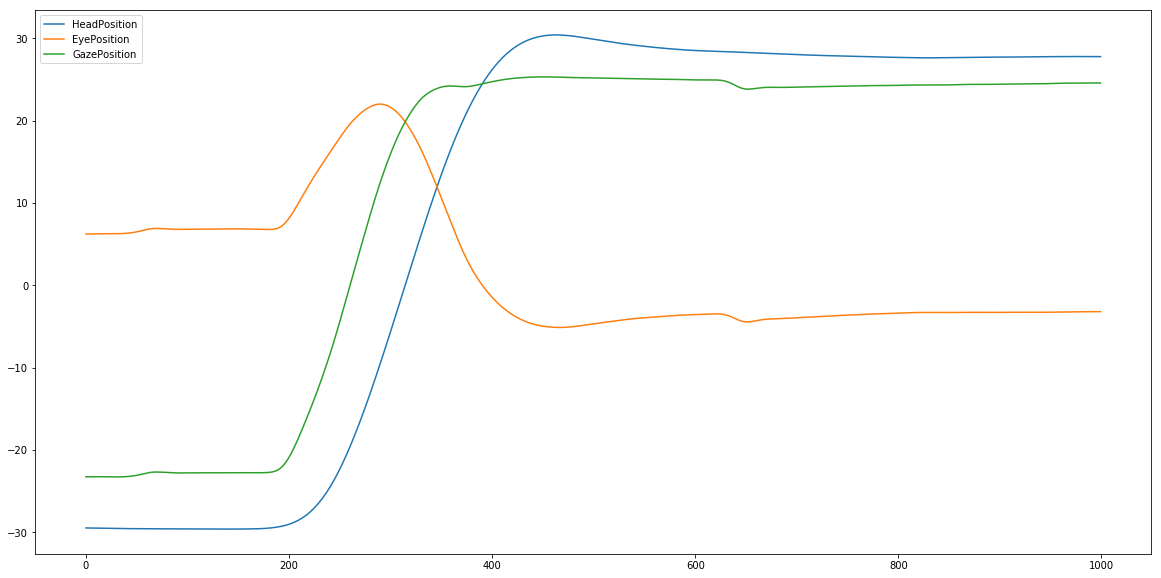

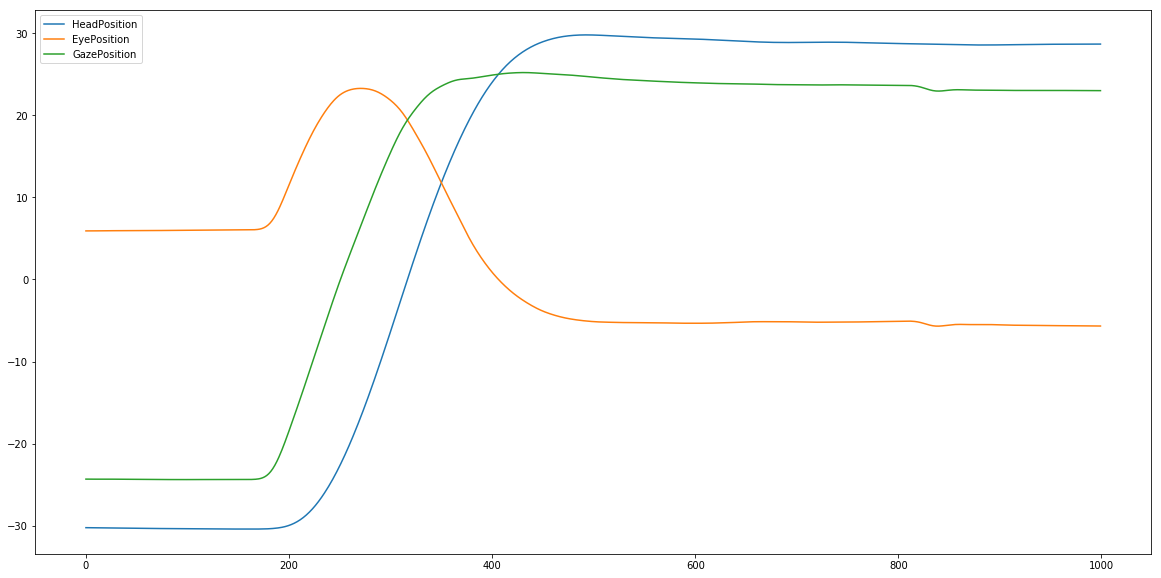

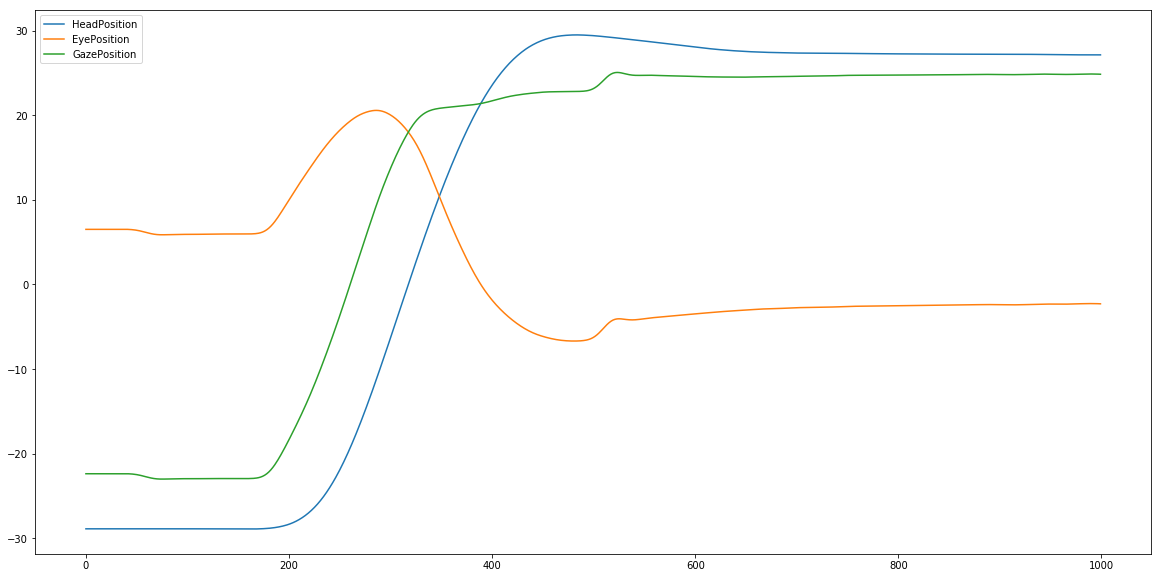

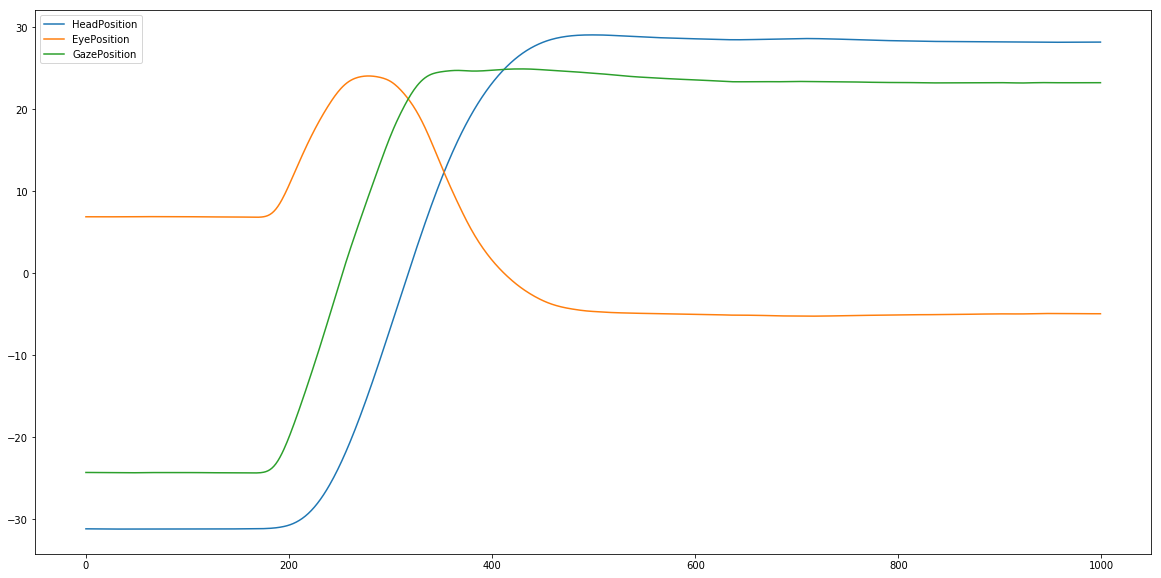

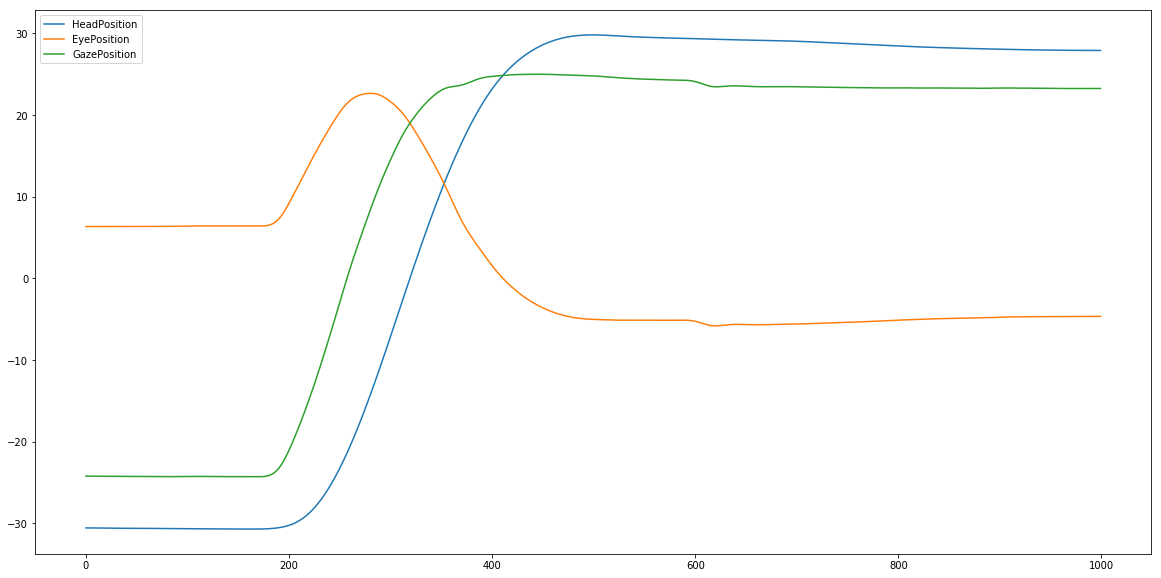

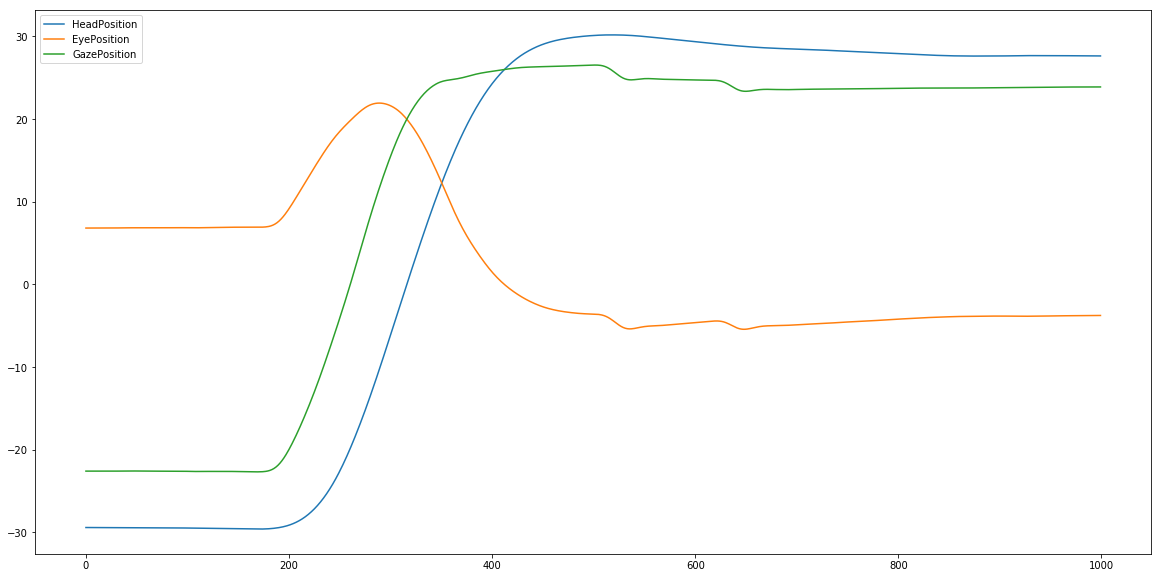

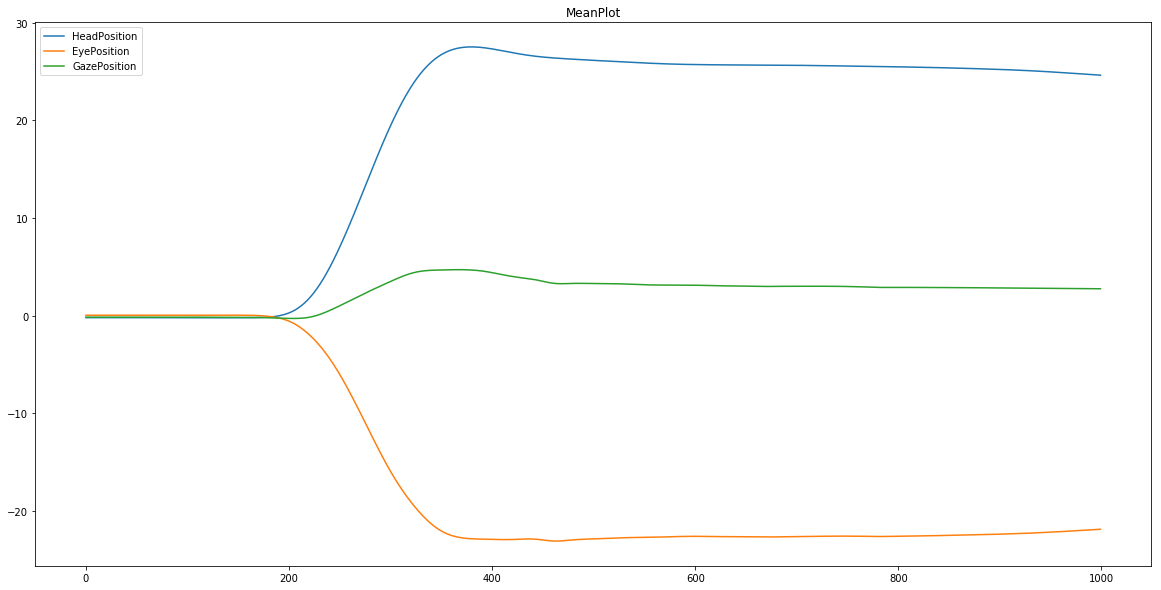

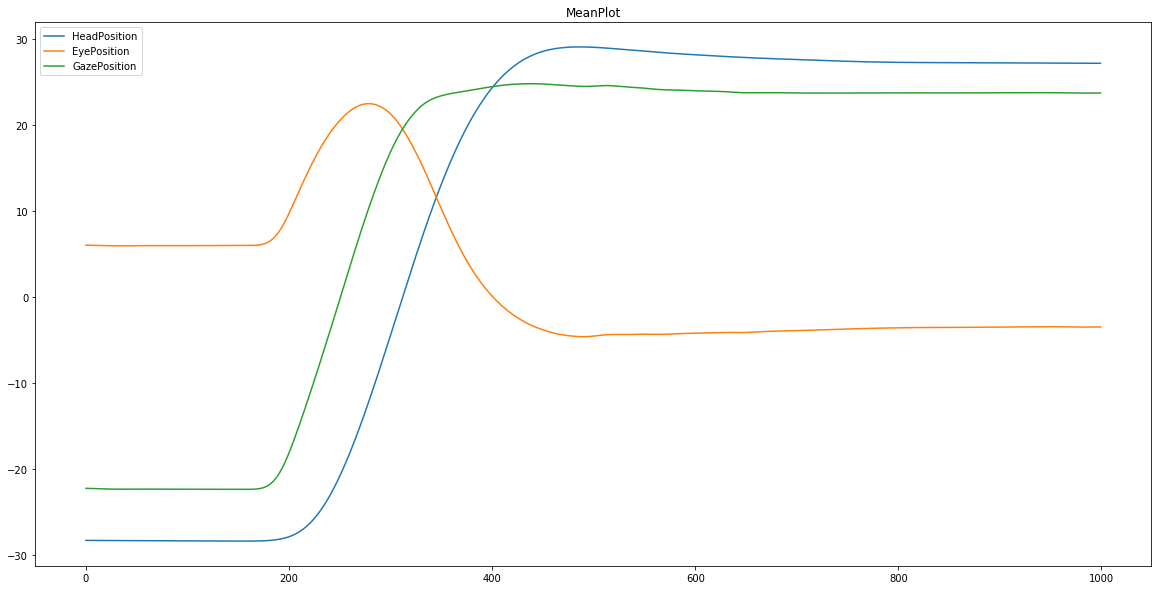

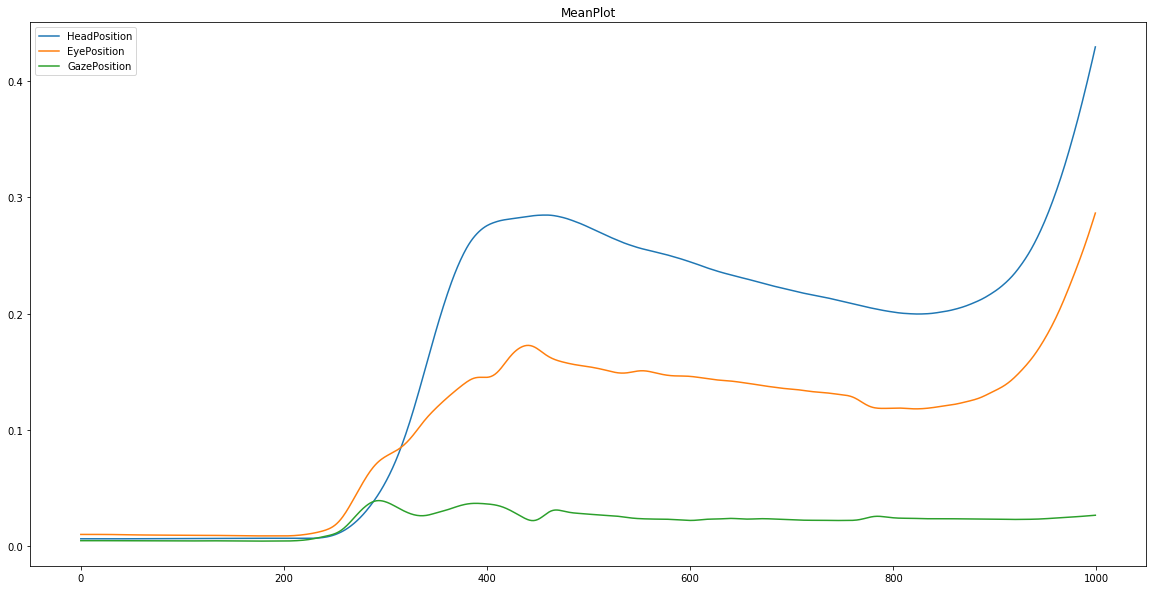

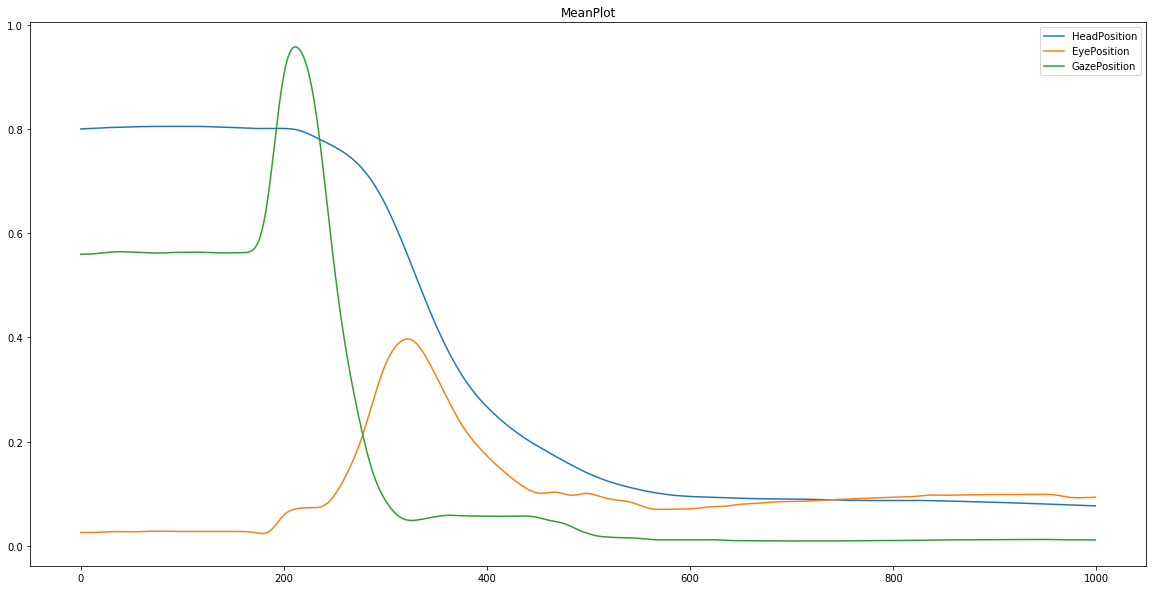

In [21]:
S_index += 1
sub_para = ["AcuityLog_2019_08_19_10_20_29.txt",\
        "AcuityLog_2019_08_19_10_35_08.txt",\
        "JumpLog__2019_08_19_10_20_29.txt",\
        "JumpLog__2019_08_19_10_35_08.txt",\
        "JumpLog__2019_08_19_10_35_08_2.txt",\
        "AcuityLog_2019_08_19_10_50_10.txt",\
        "",\
        "Mdata.mat",\
        "0"]
DY_DL = []
GA_DL = [17]
run_subject(sub_para, DY_DL = DY_DL, GA_DL = GA_DL)

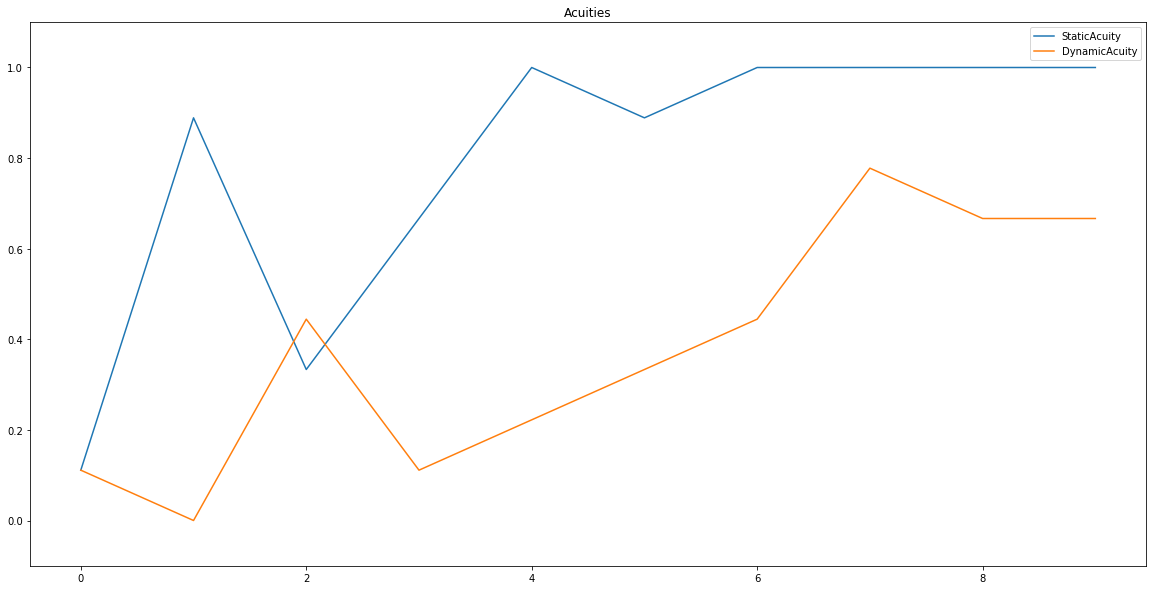

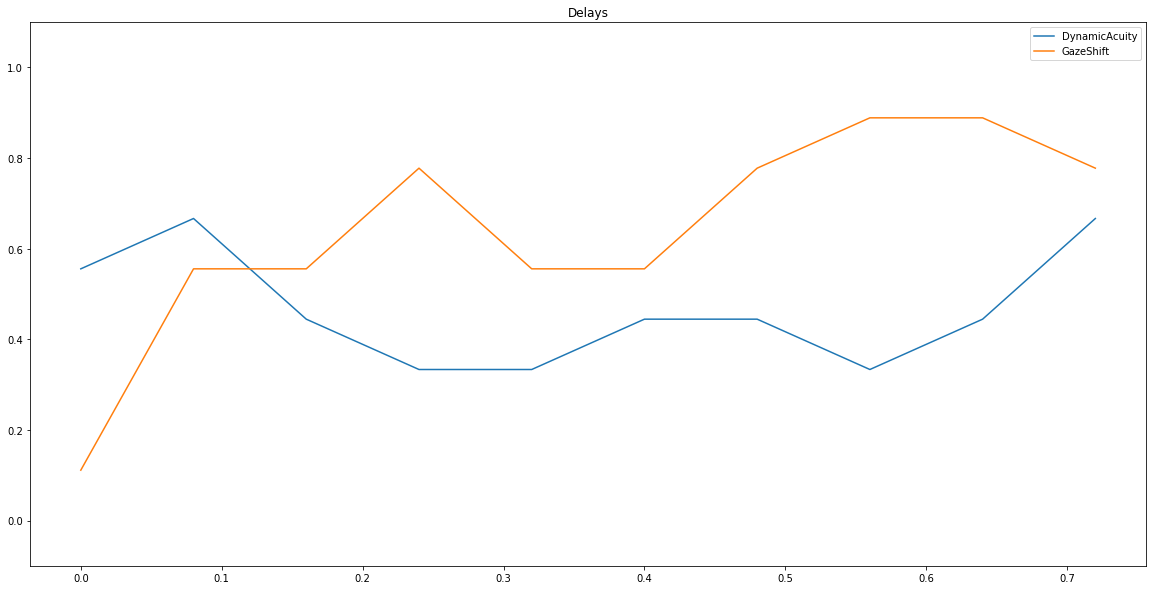

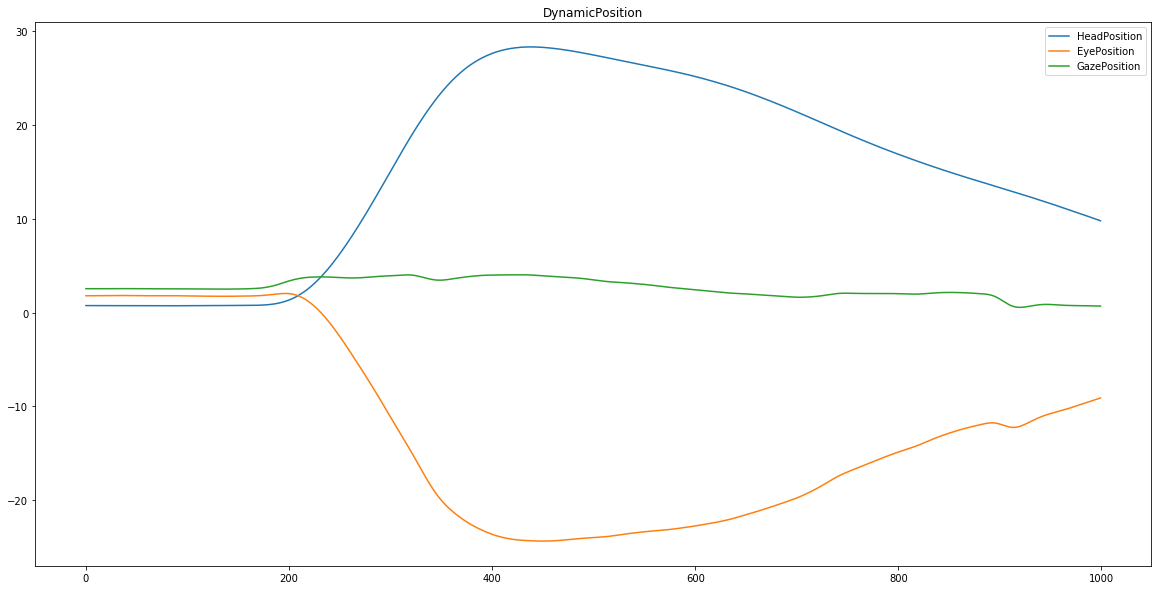

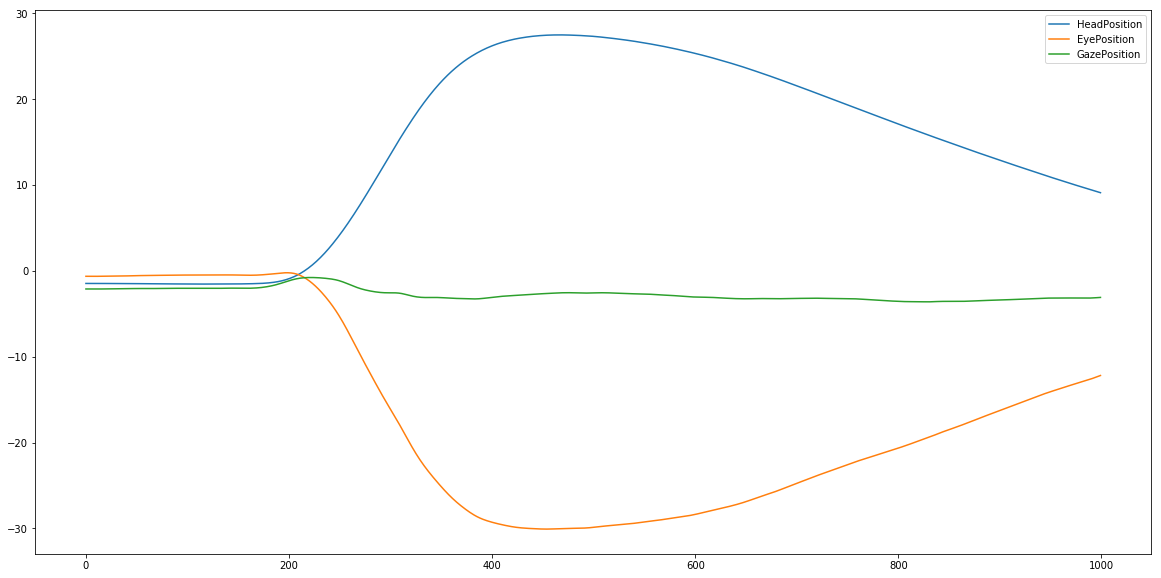

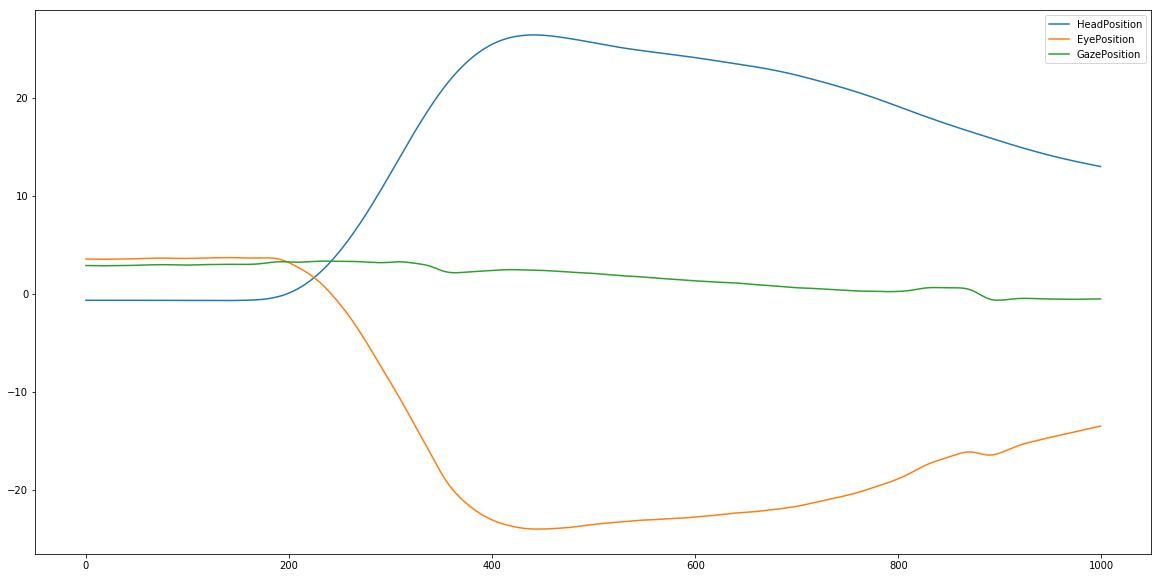

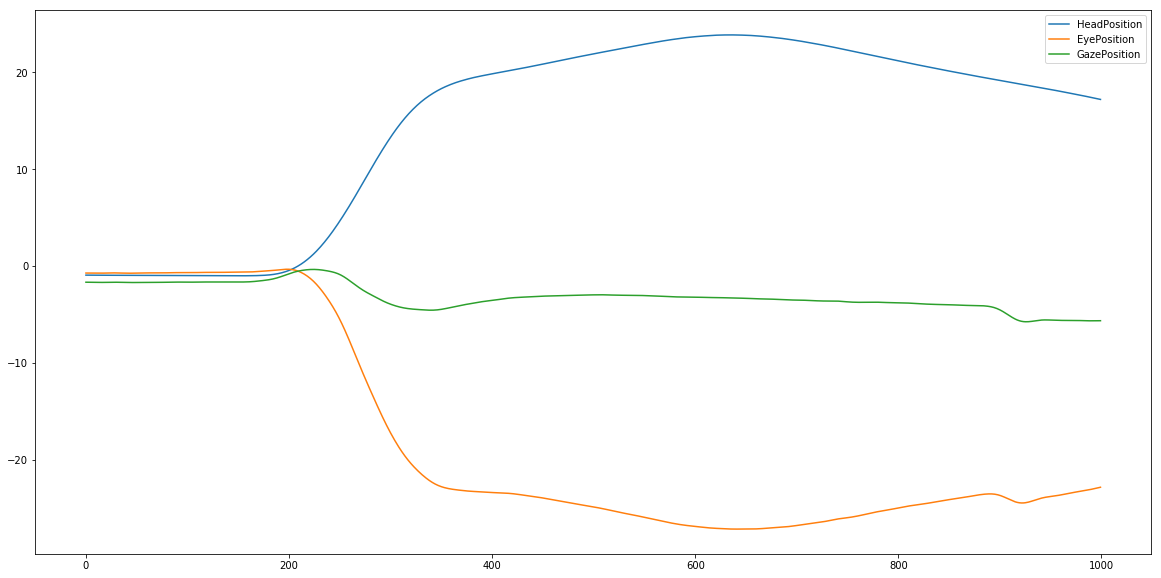

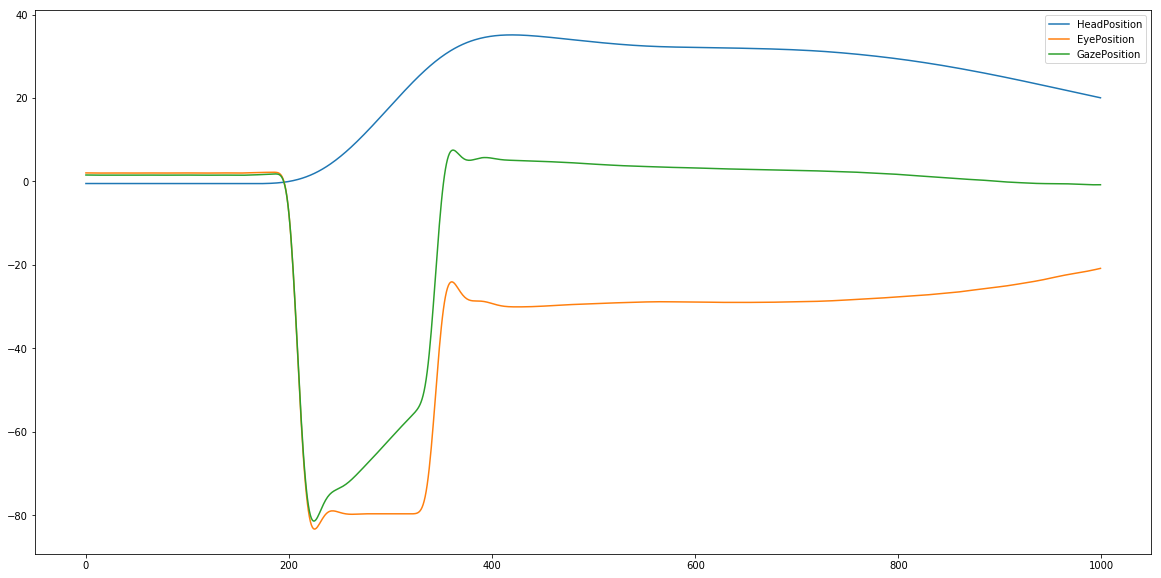

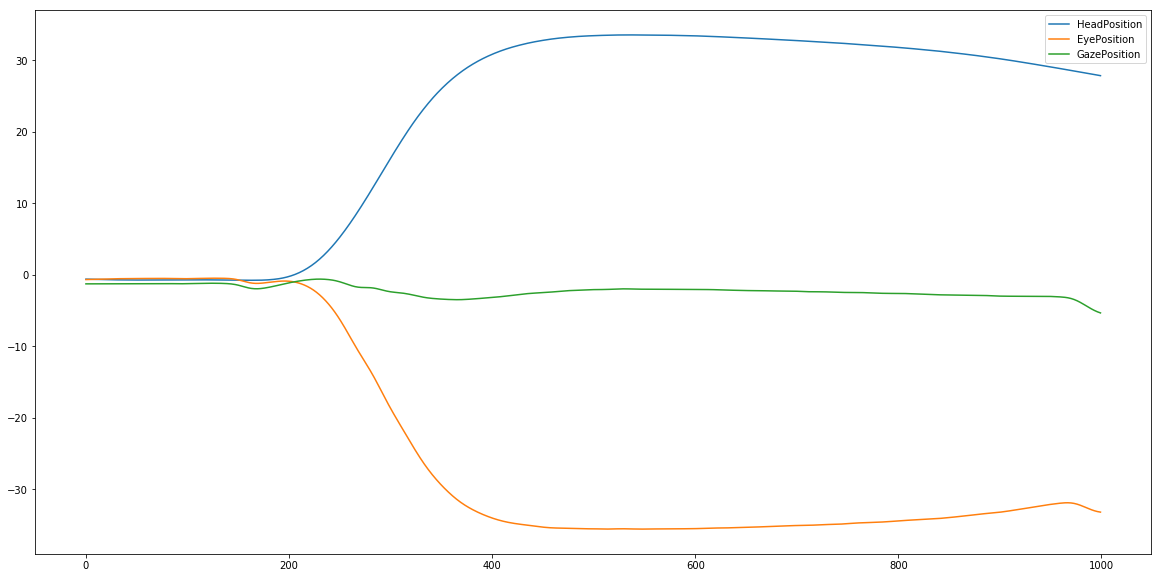

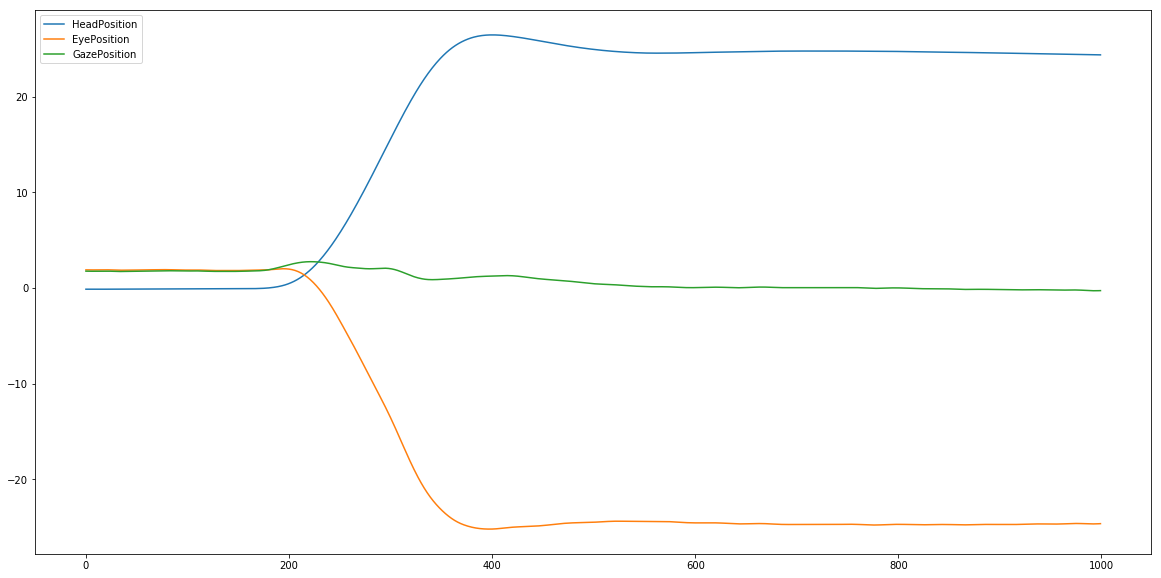

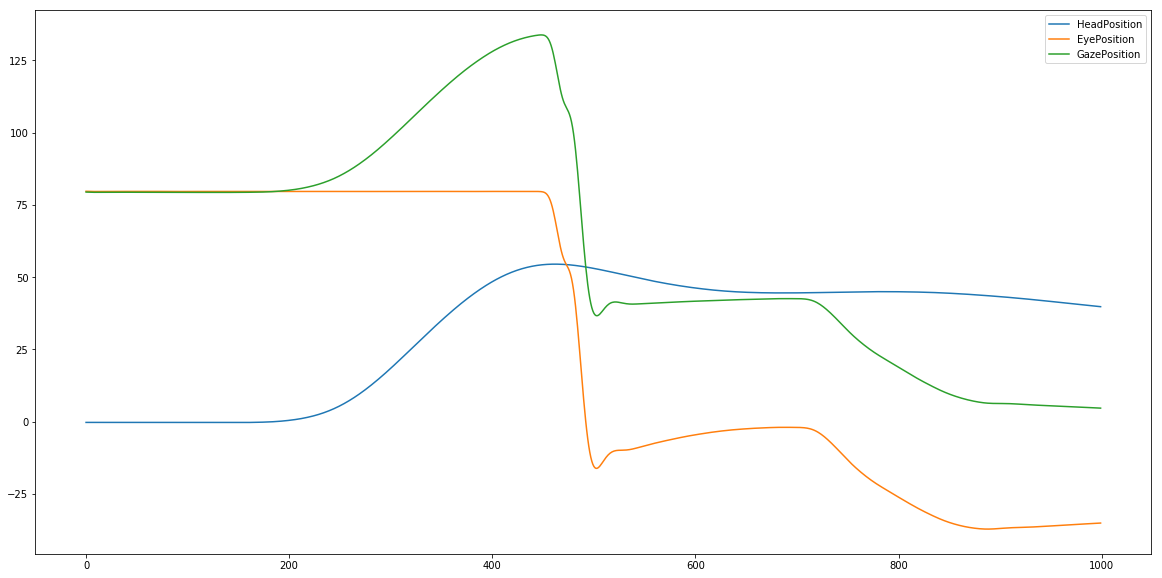

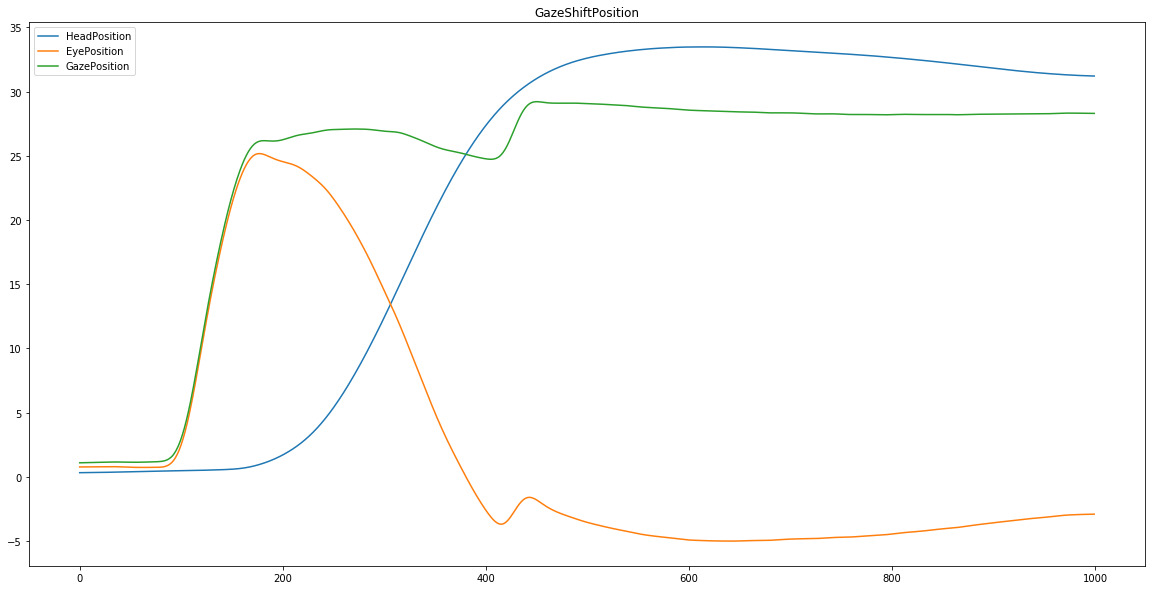

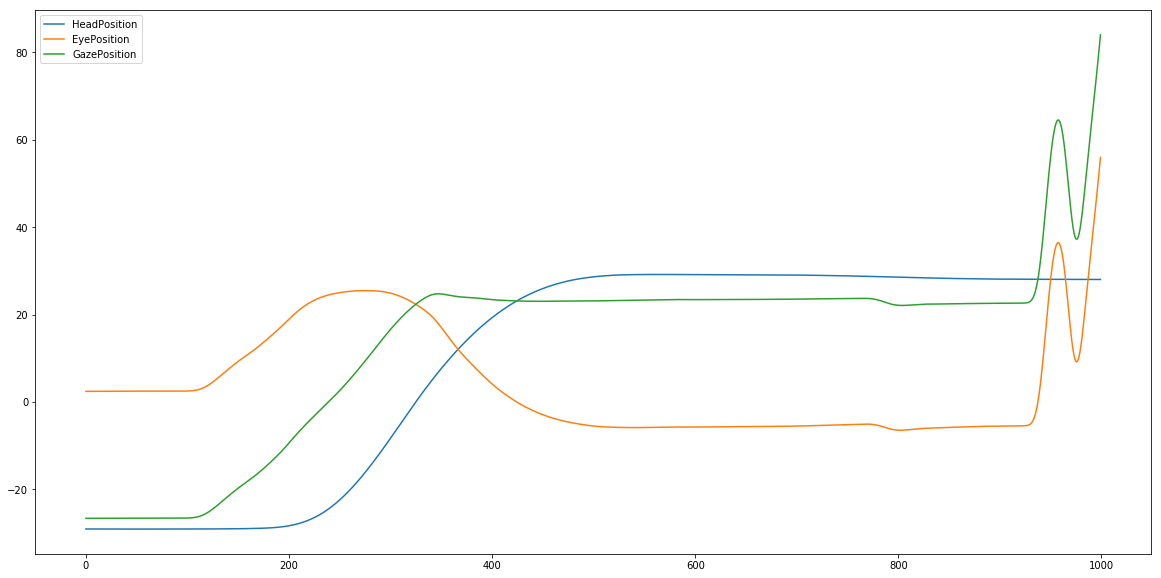

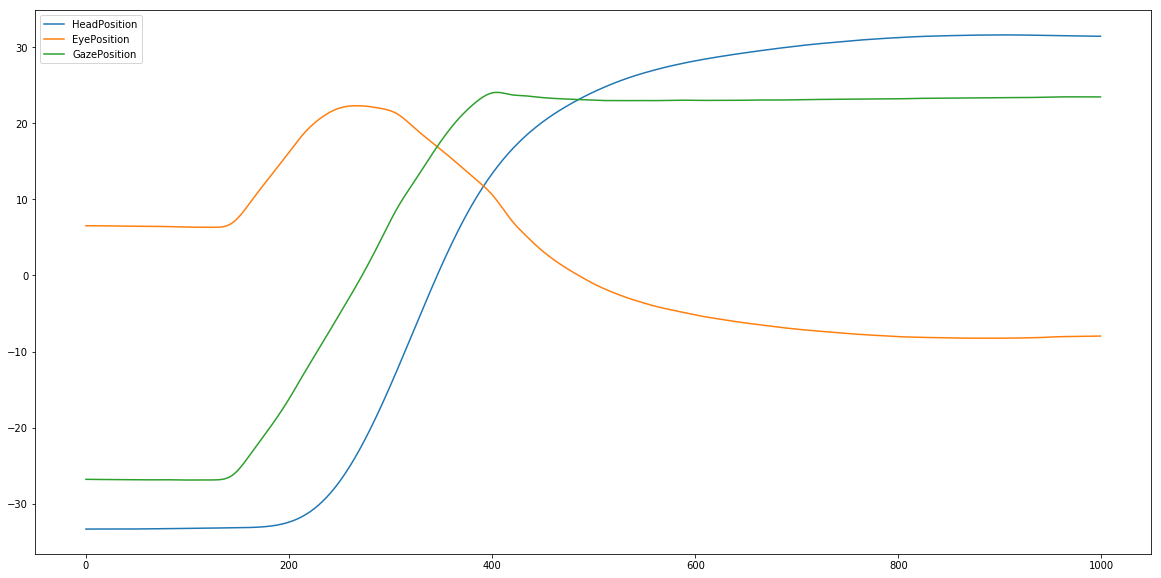

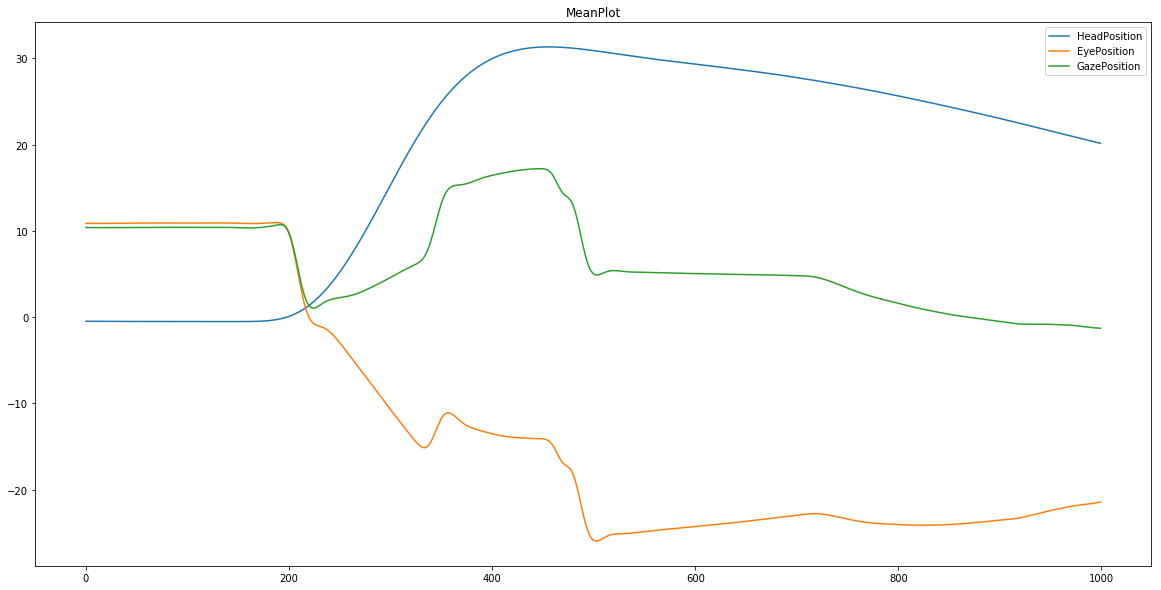

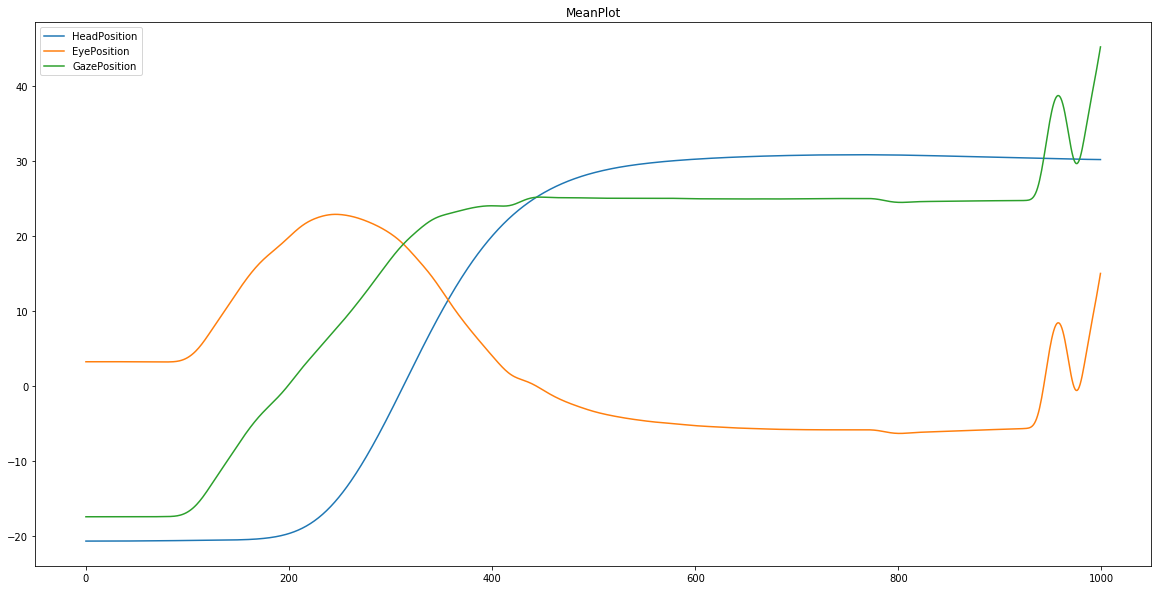

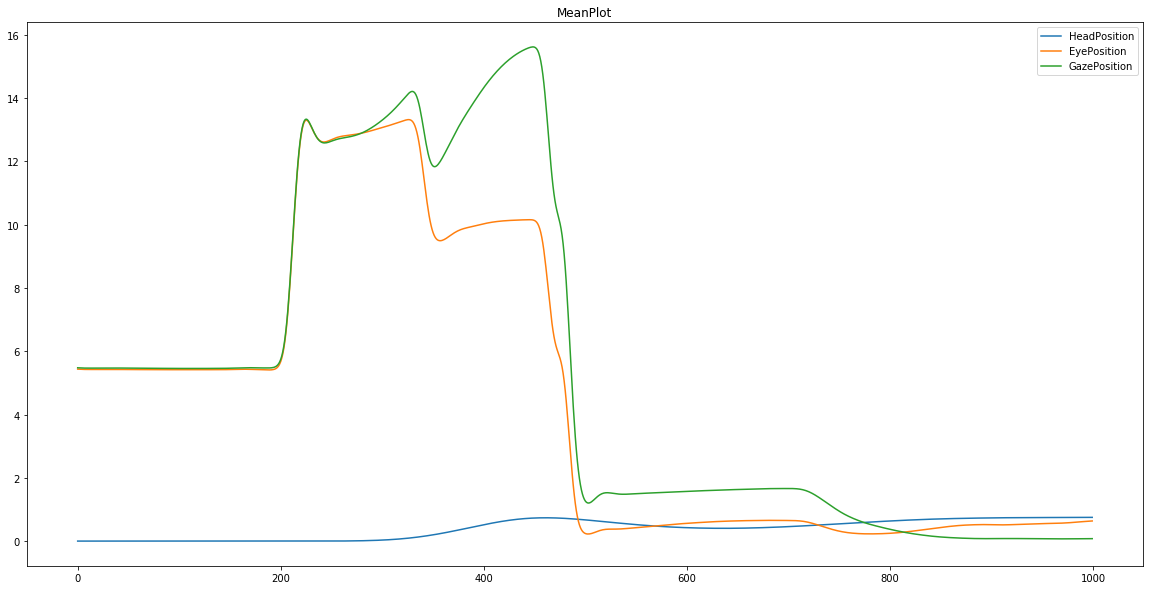

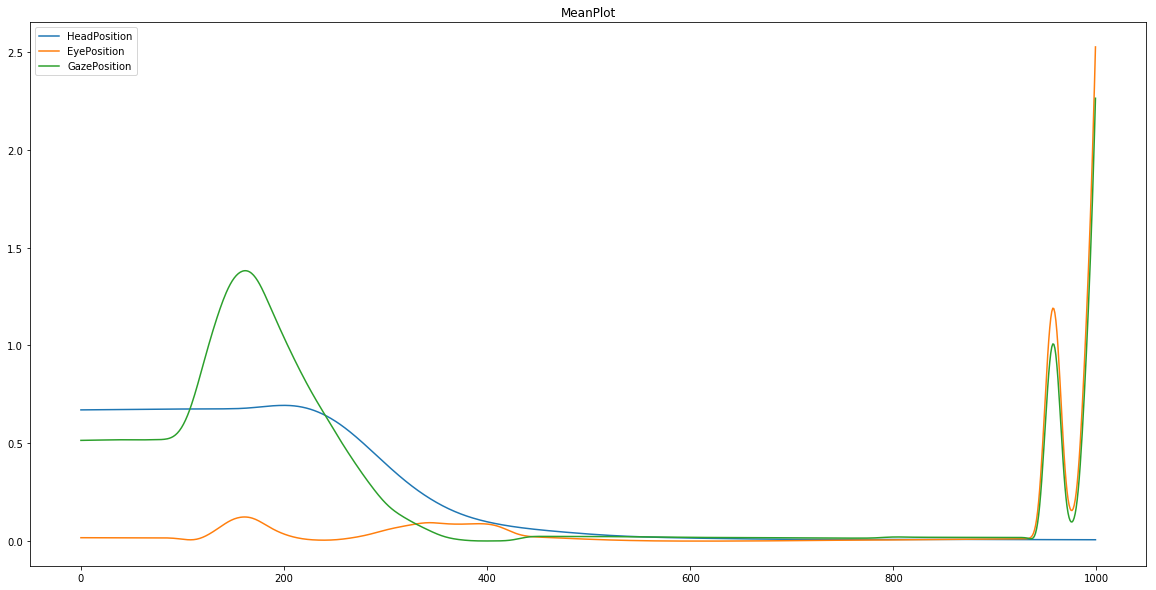

In [22]:
S_index += 1
sub_para = ["AcuityLog_2019_08_30_01_05_31.txt",\
        "AcuityLog_2019_08_30_01_19_07.txt",\
        "JumpLog__2019_08_30_01_05_31.txt",\
        "JumpLog__2019_08_30_01_19_07.txt",\
        "JumpLog__2019_08_30_01_19_07_2.txt",\
        "AcuityLog_2019_08_30_01_33_17.txt",\
        "",\
        "Qdata.mat",\
        "0"
       ]
DY_DL = [0,8,9,10,11,12,13,14,15,17,18,19]
GA_DL = [1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
run_subject(sub_para,DY_DL = DY_DL, GA_DL = GA_DL)

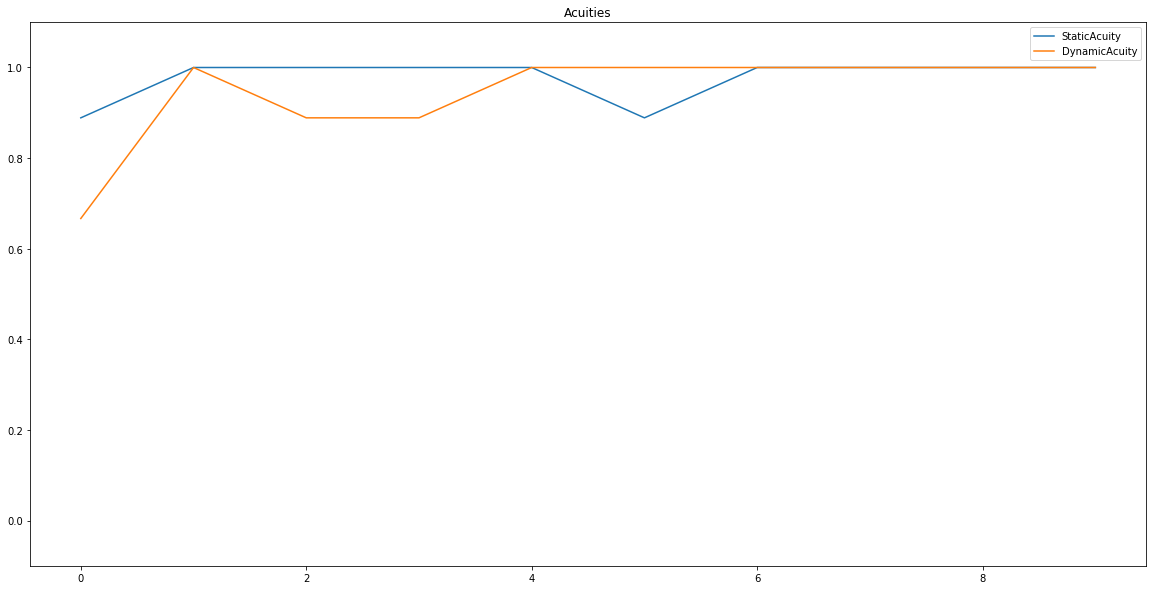

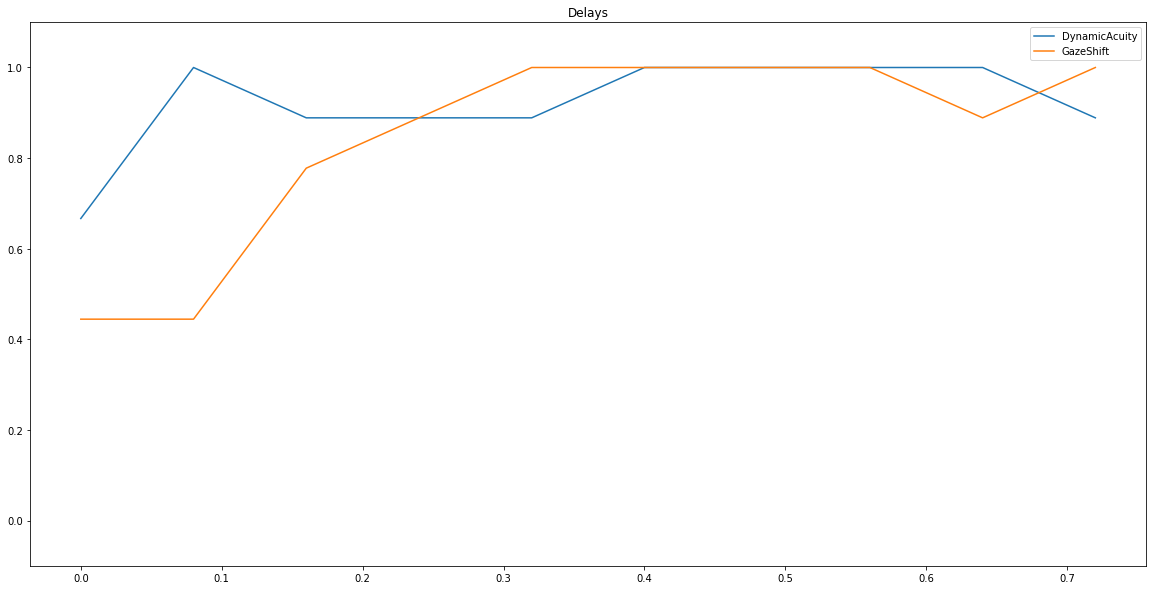

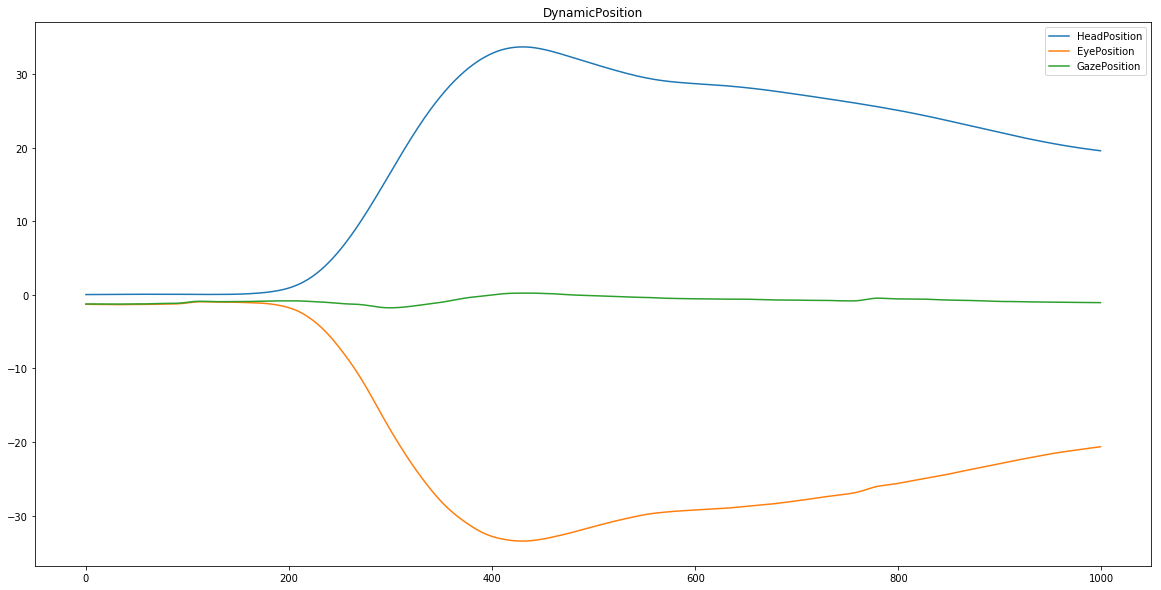

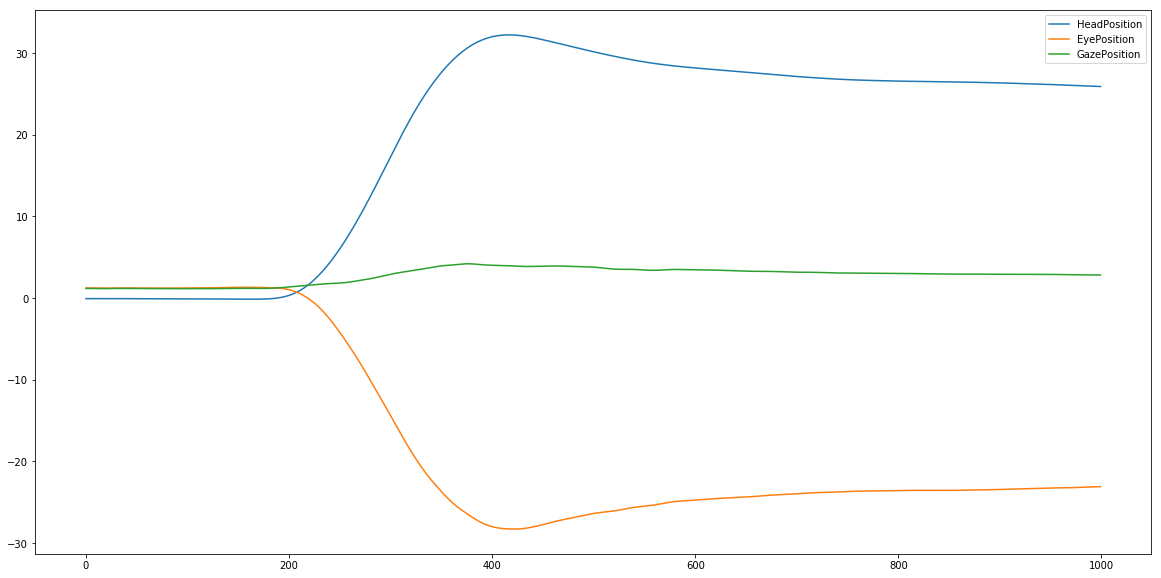

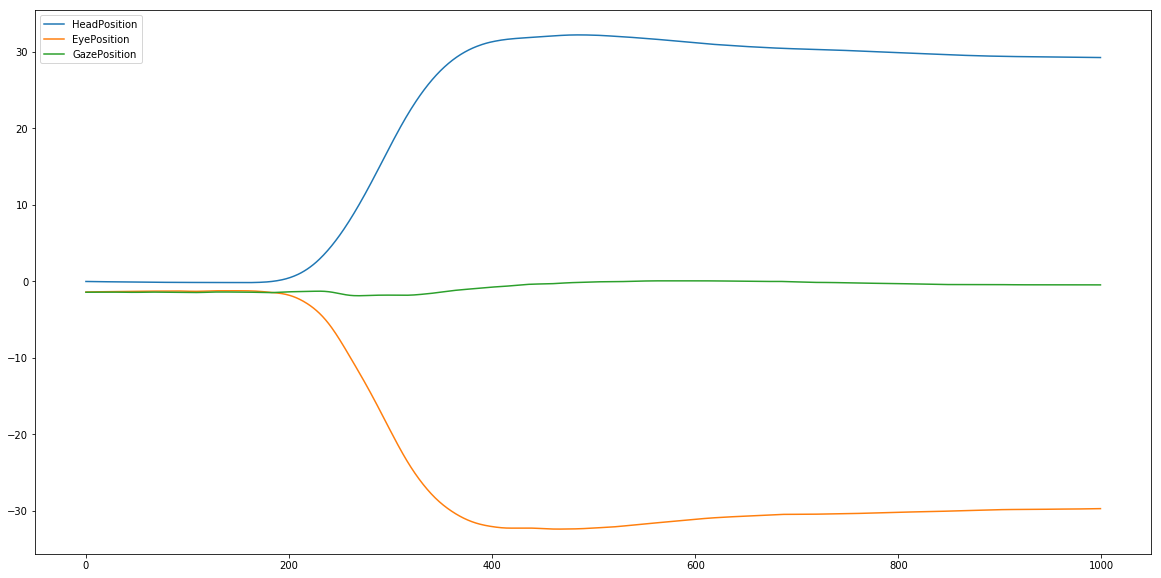

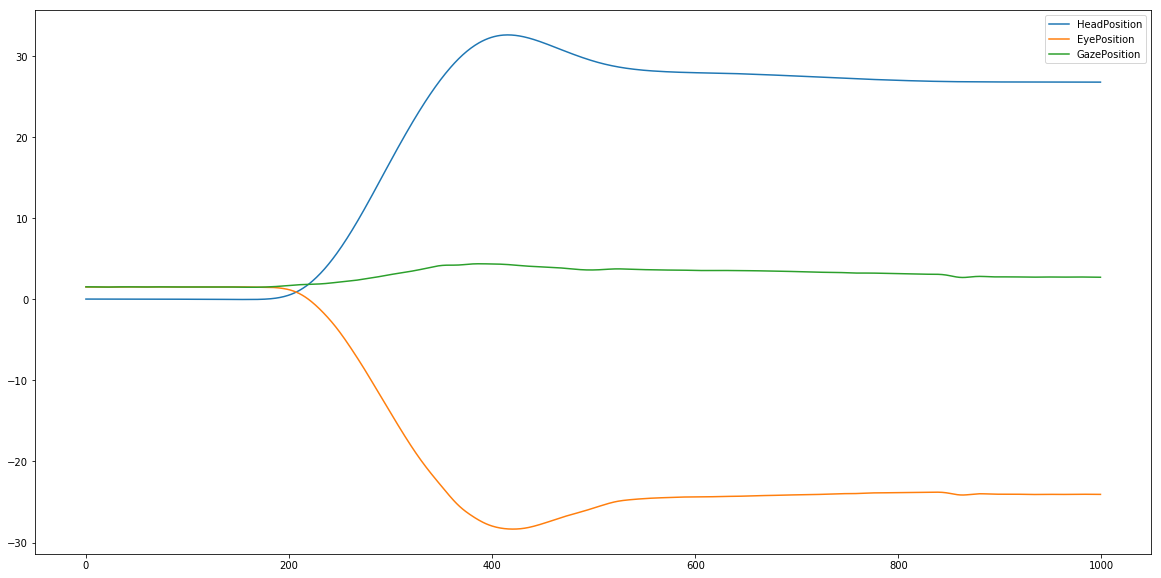

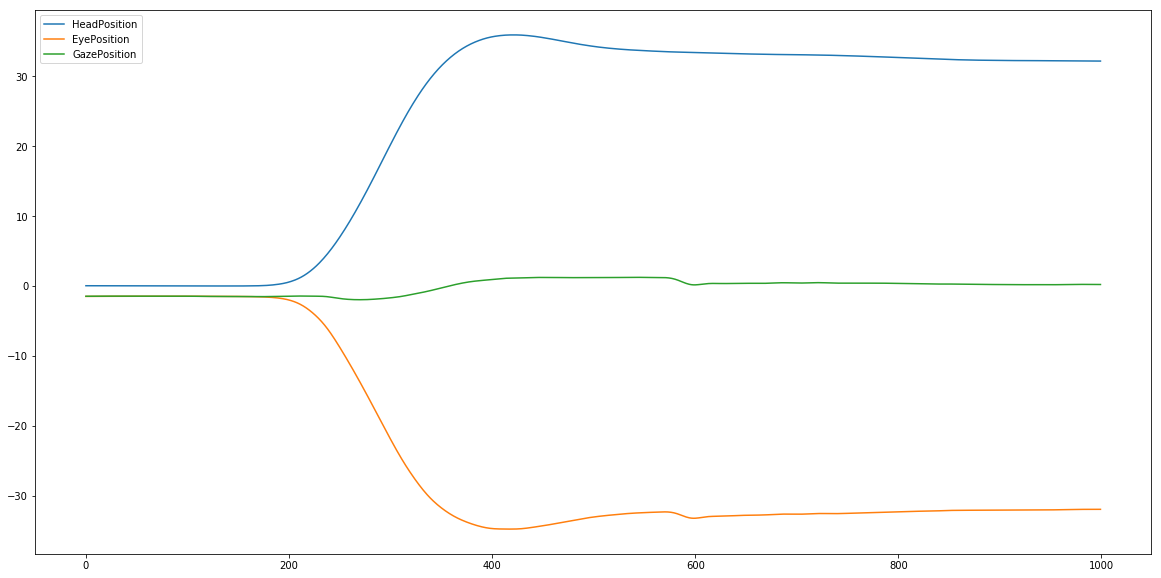

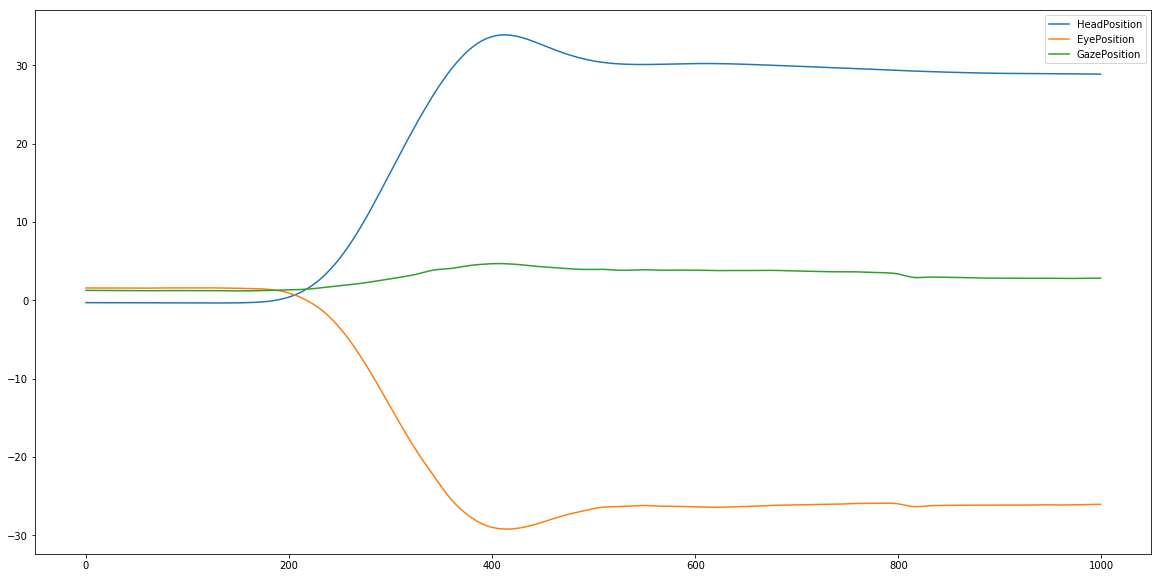

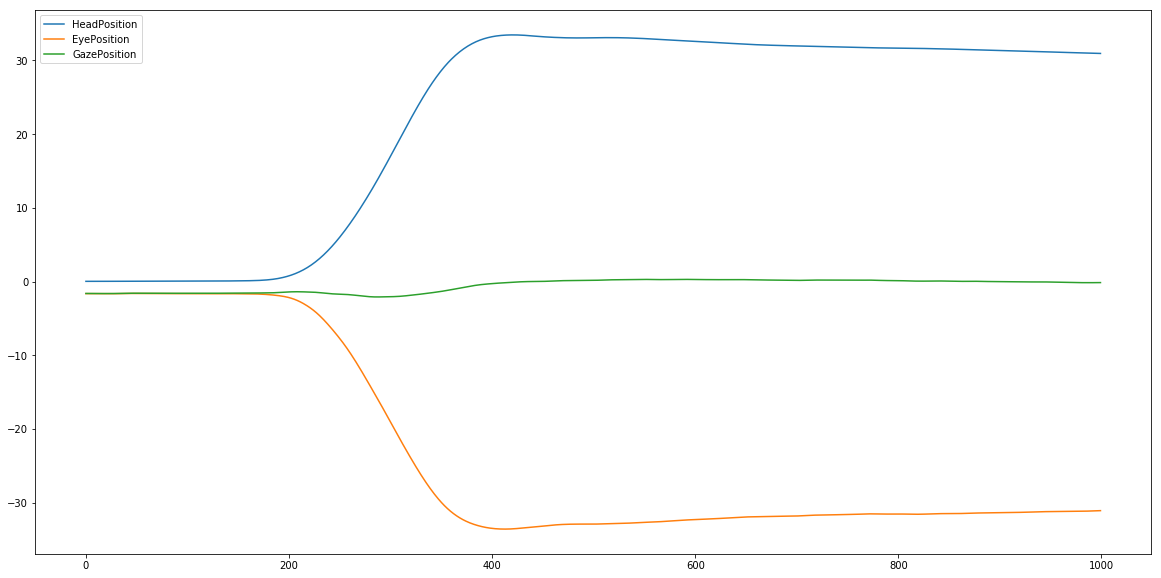

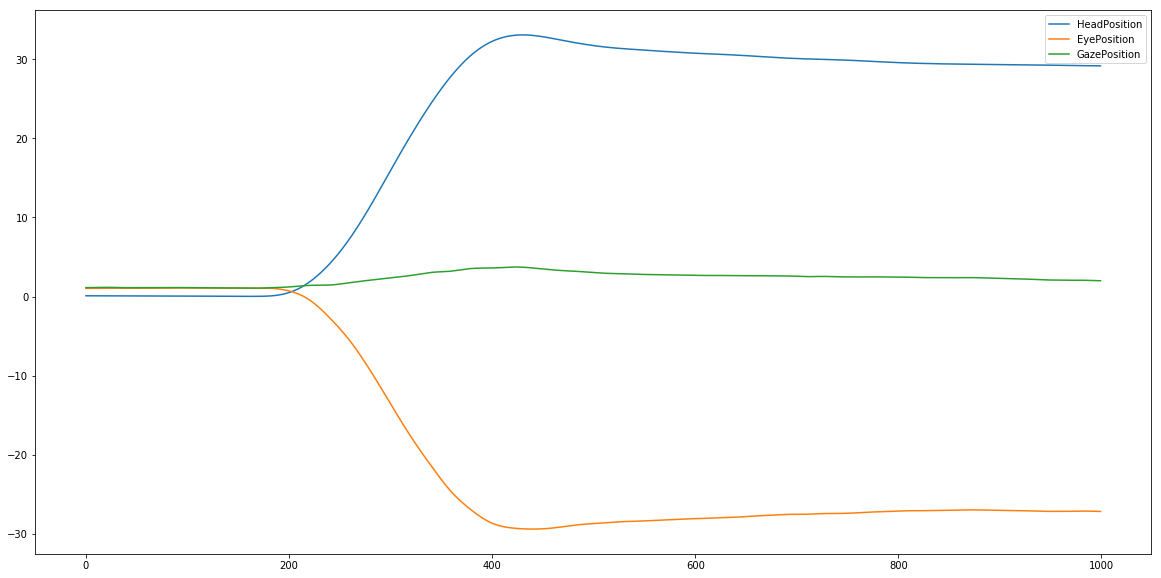

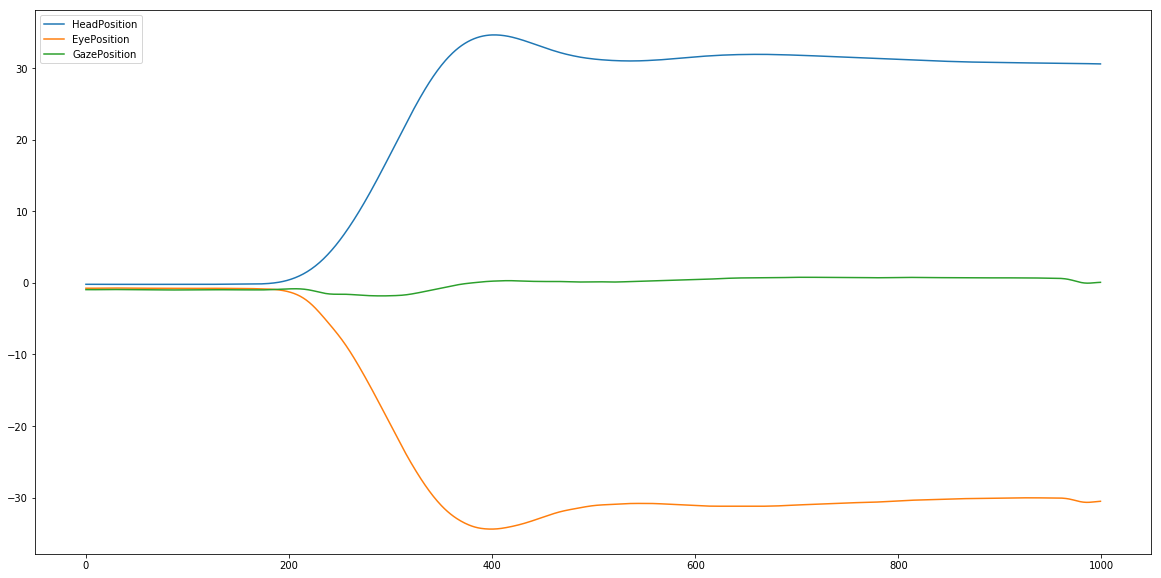

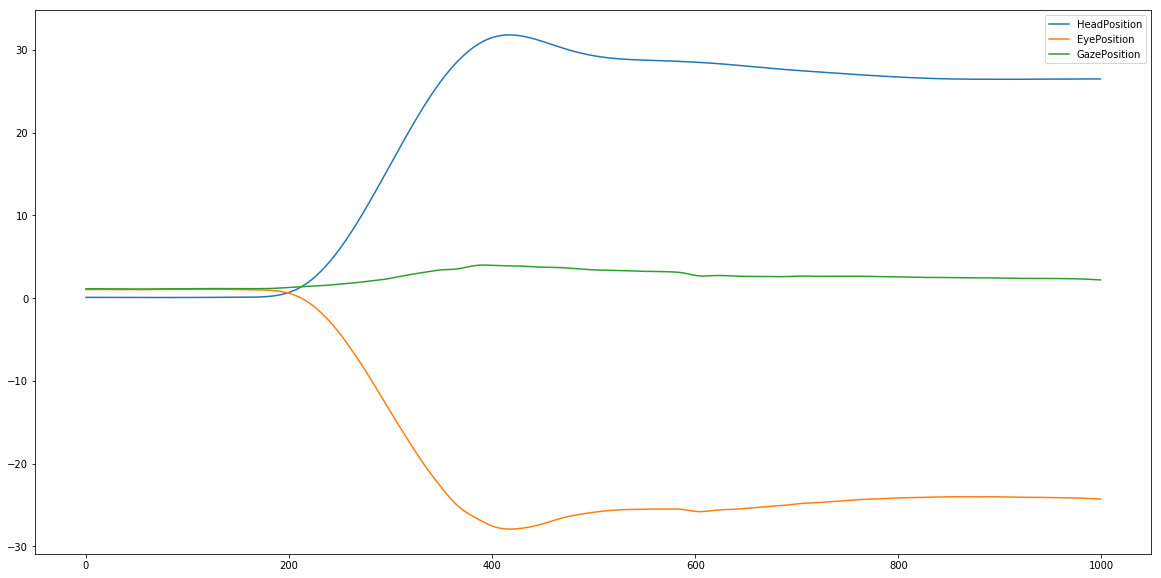

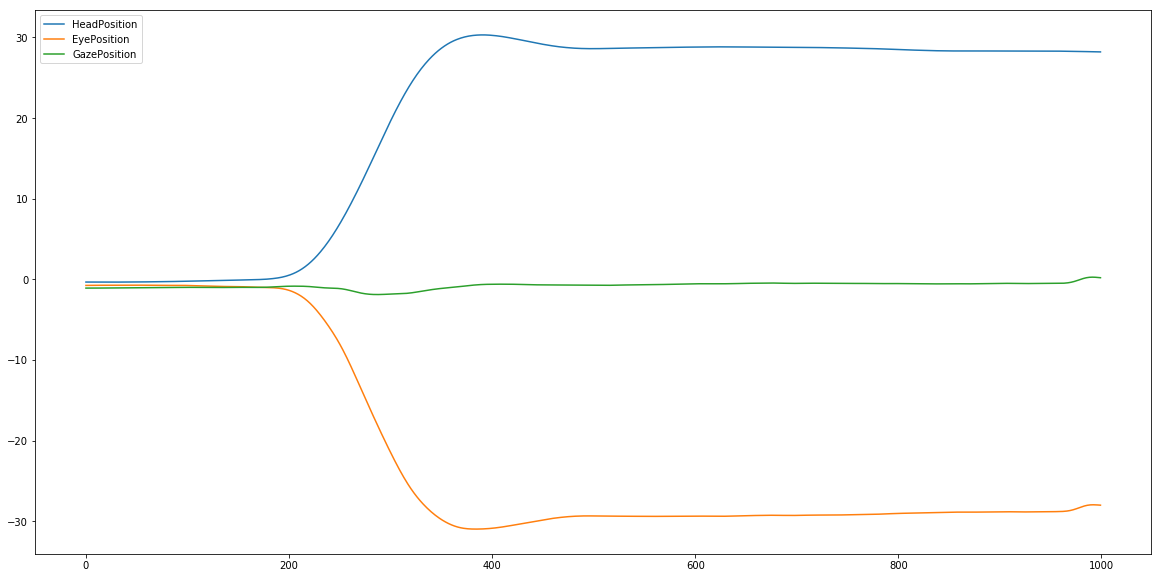

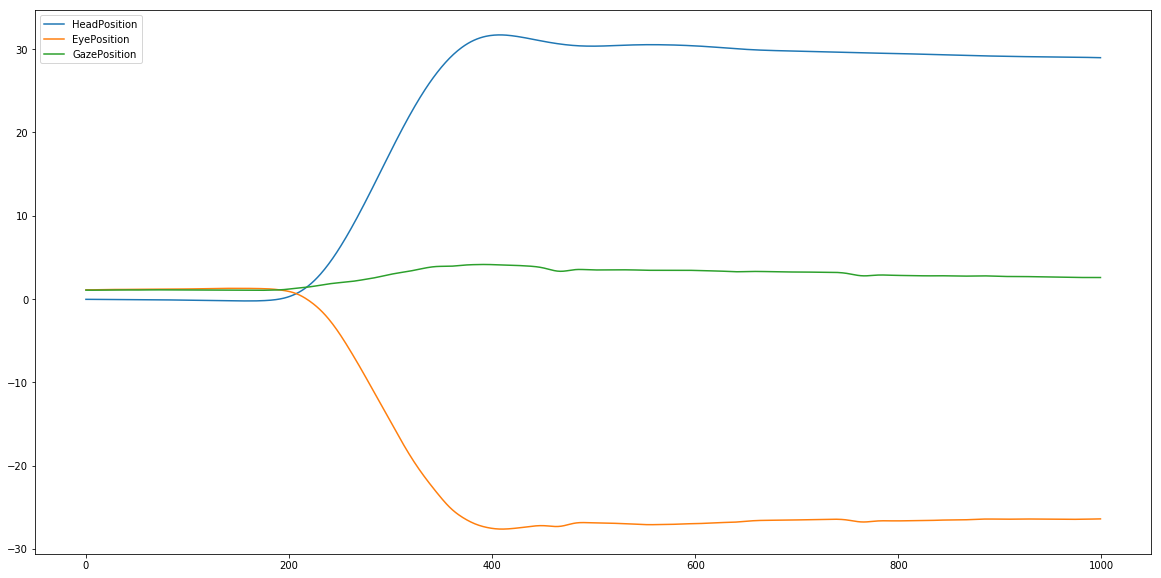

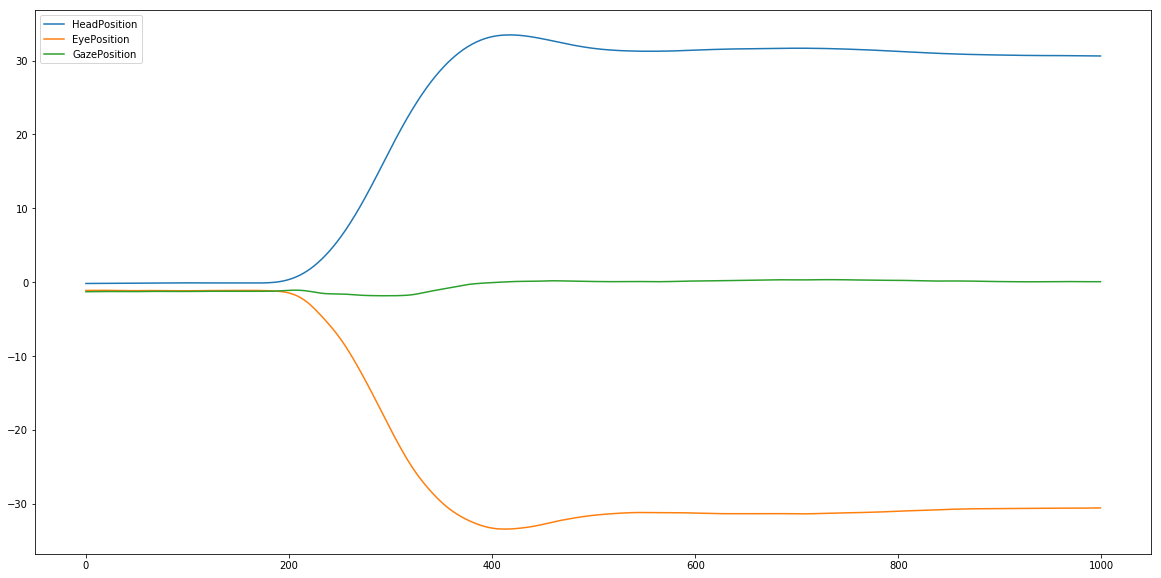

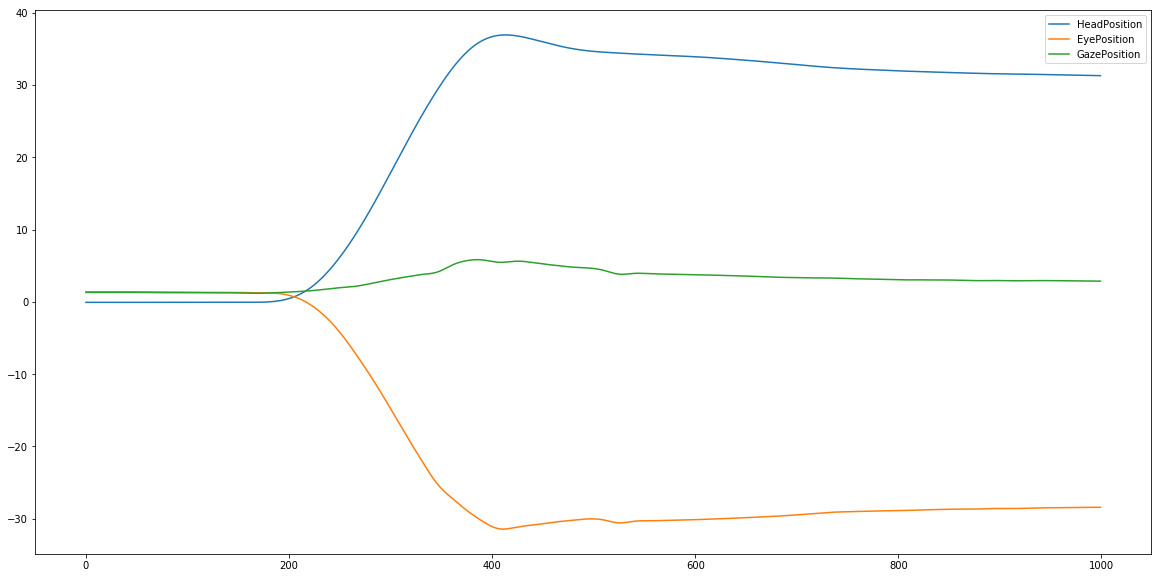

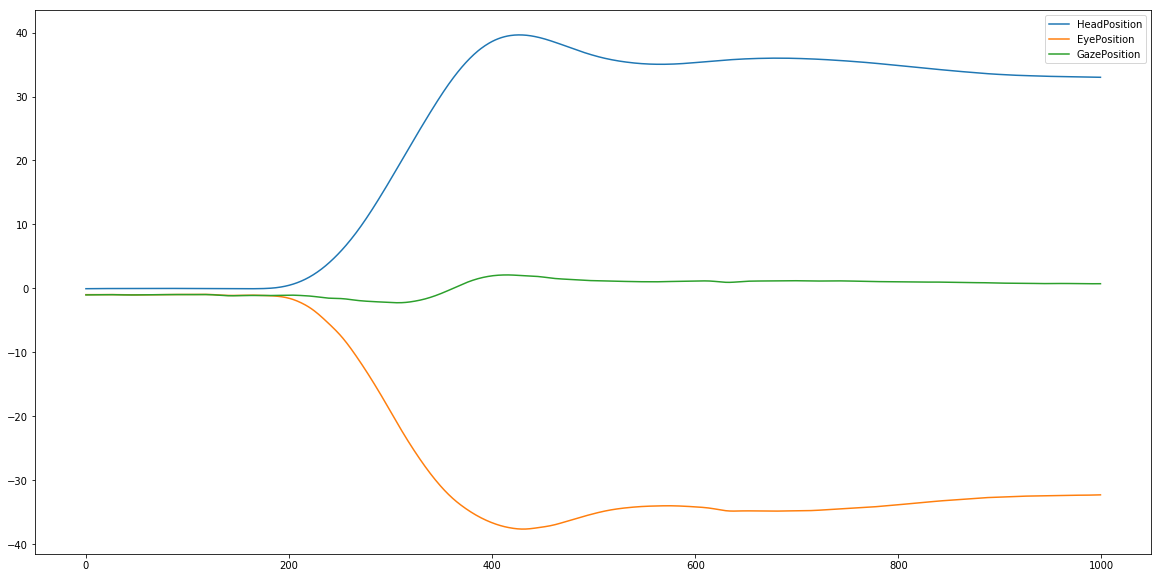

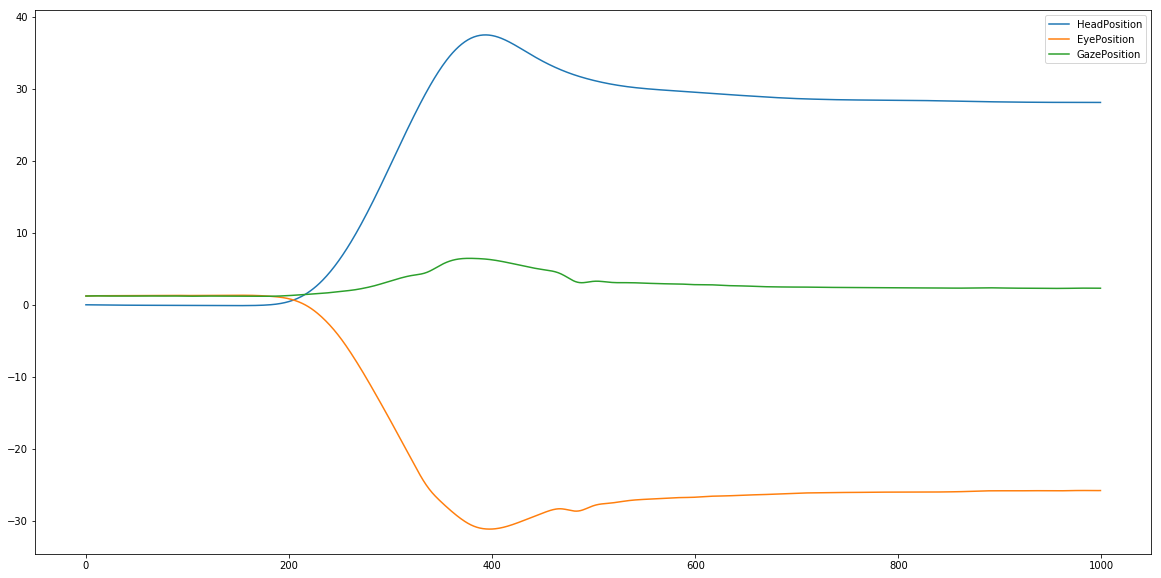

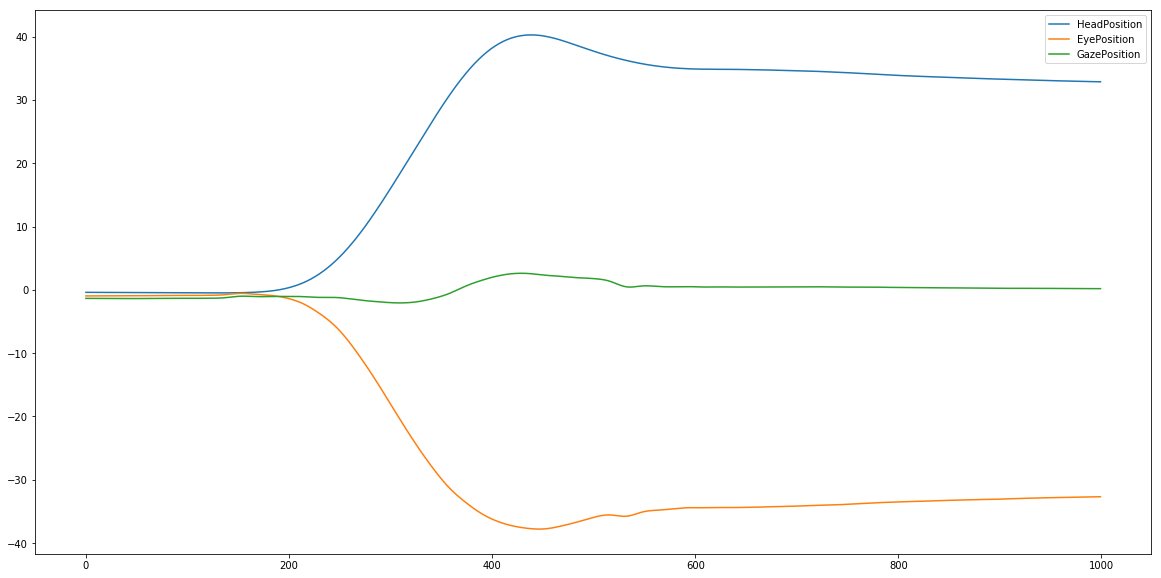

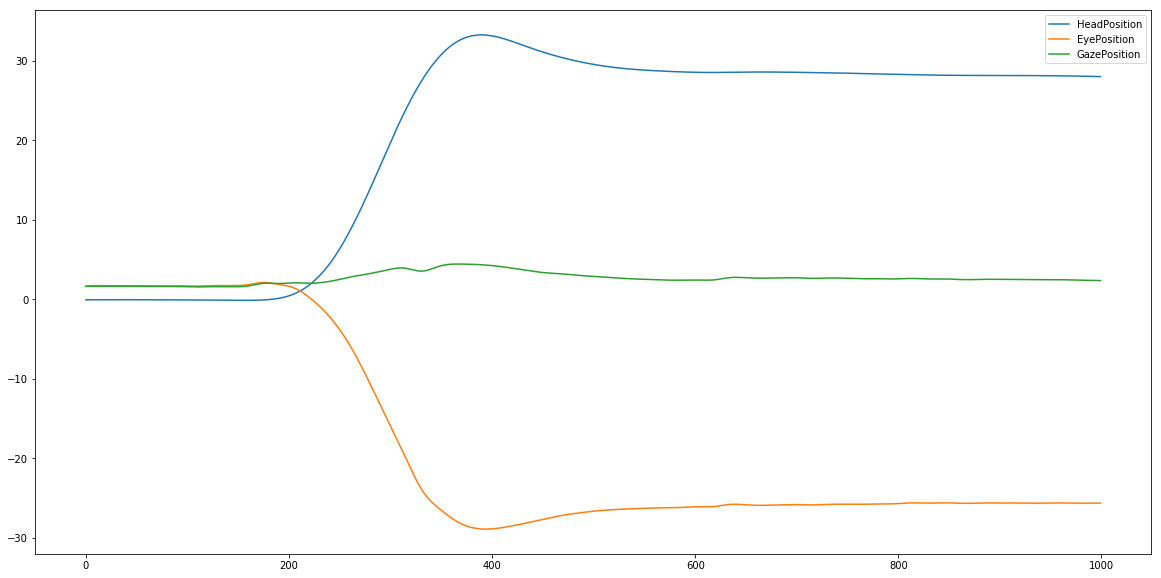

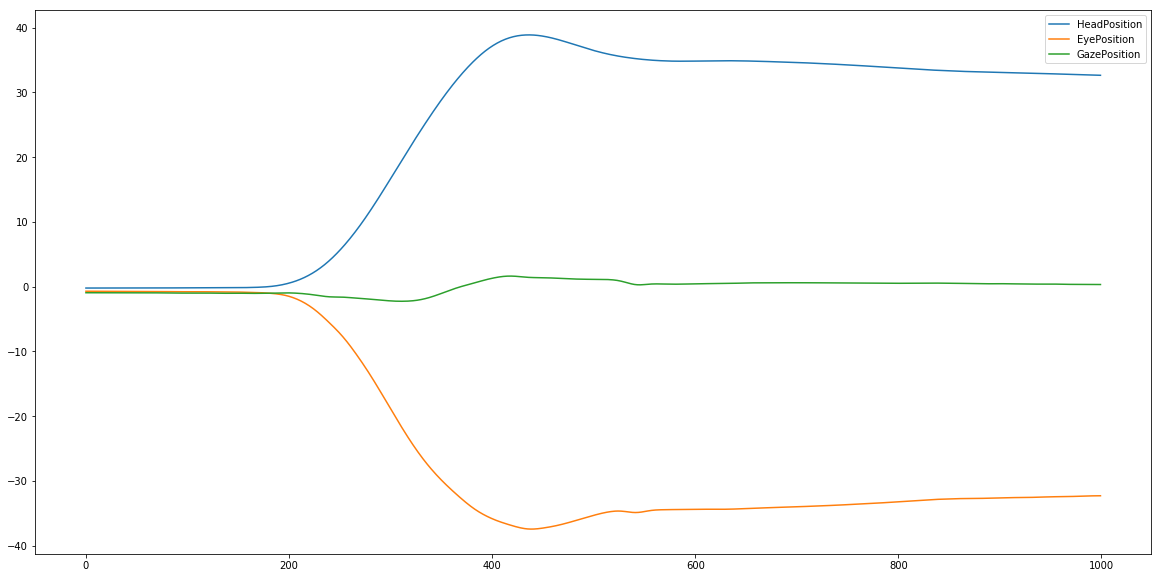

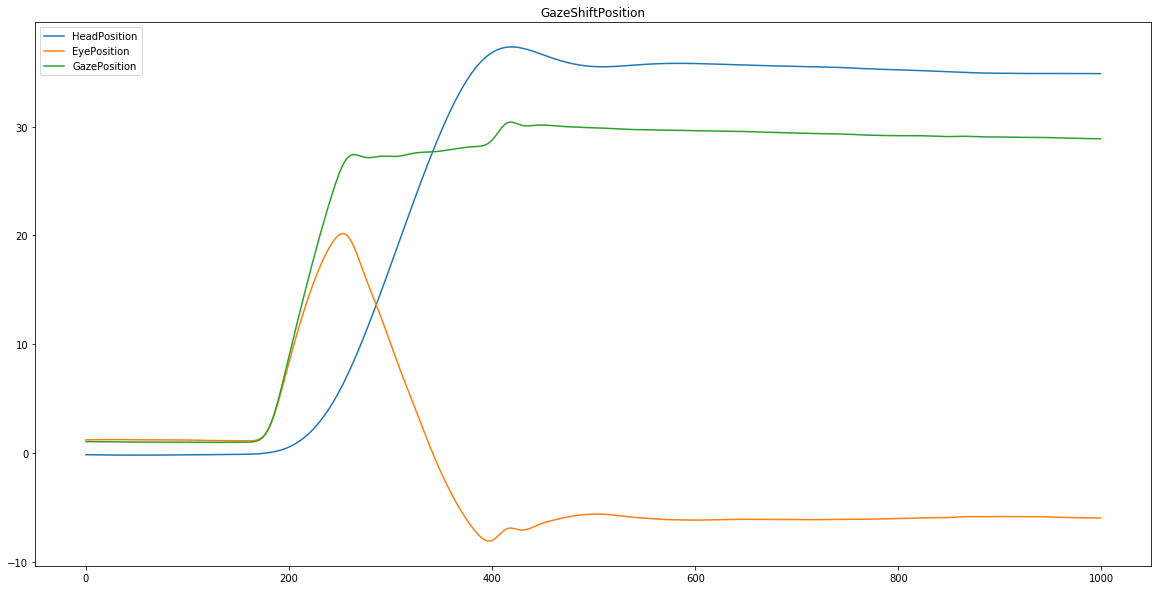

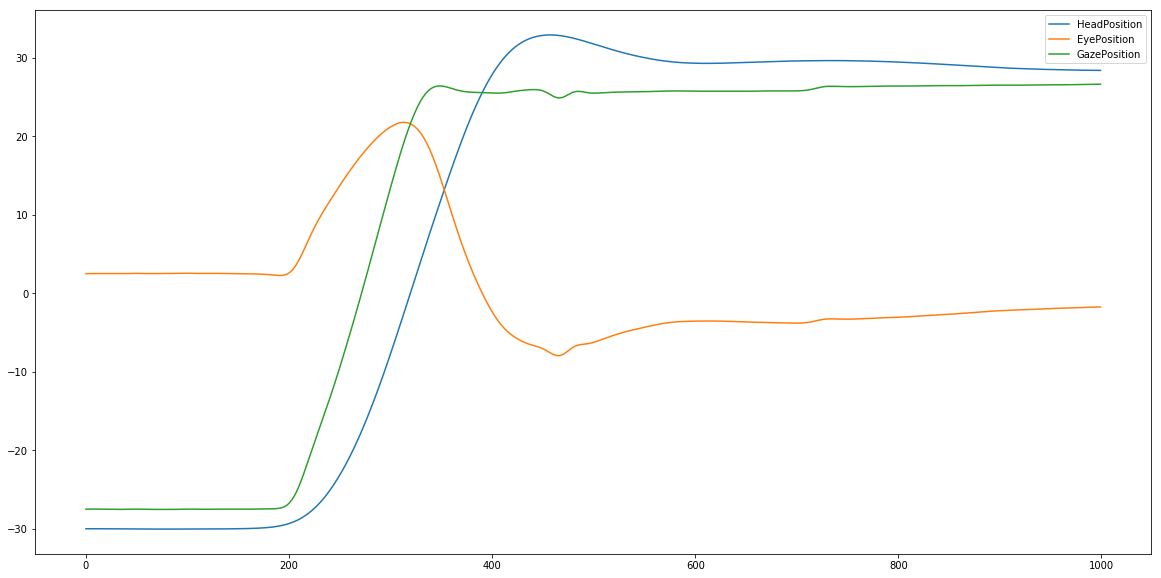

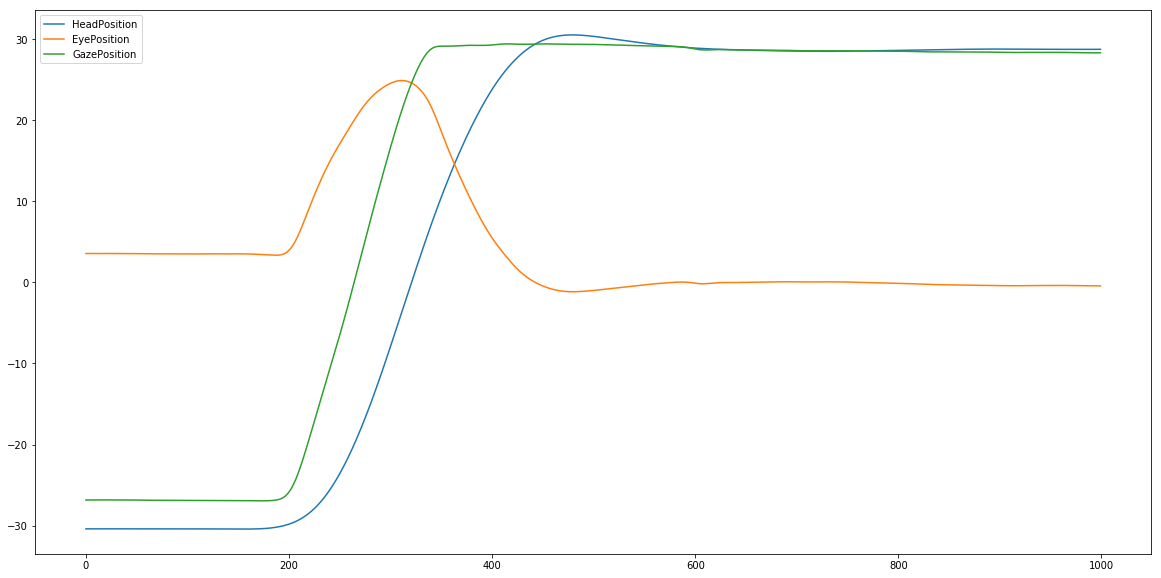

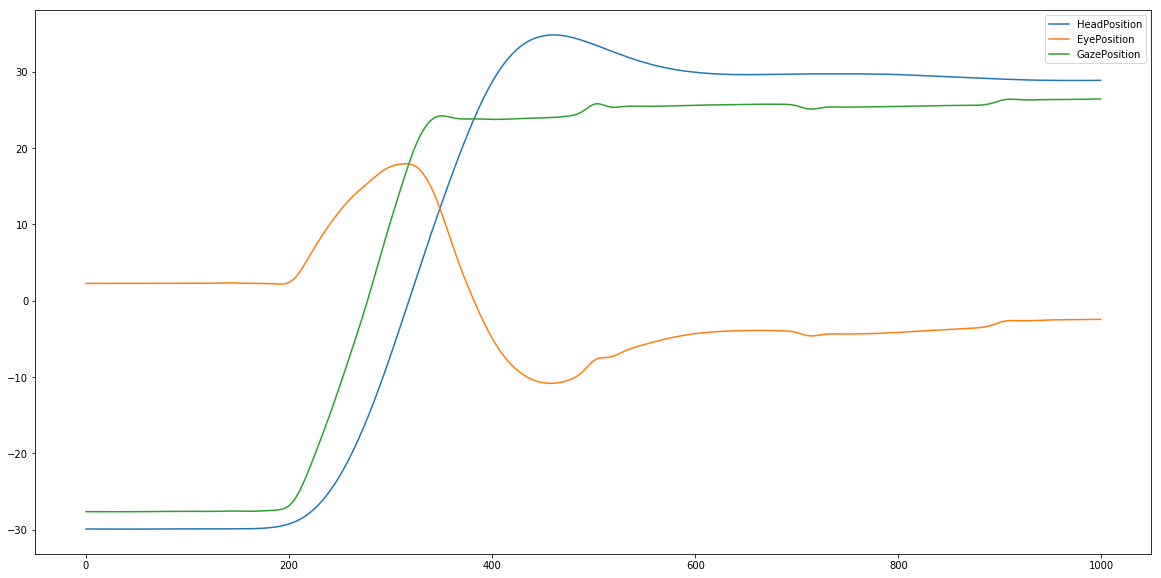

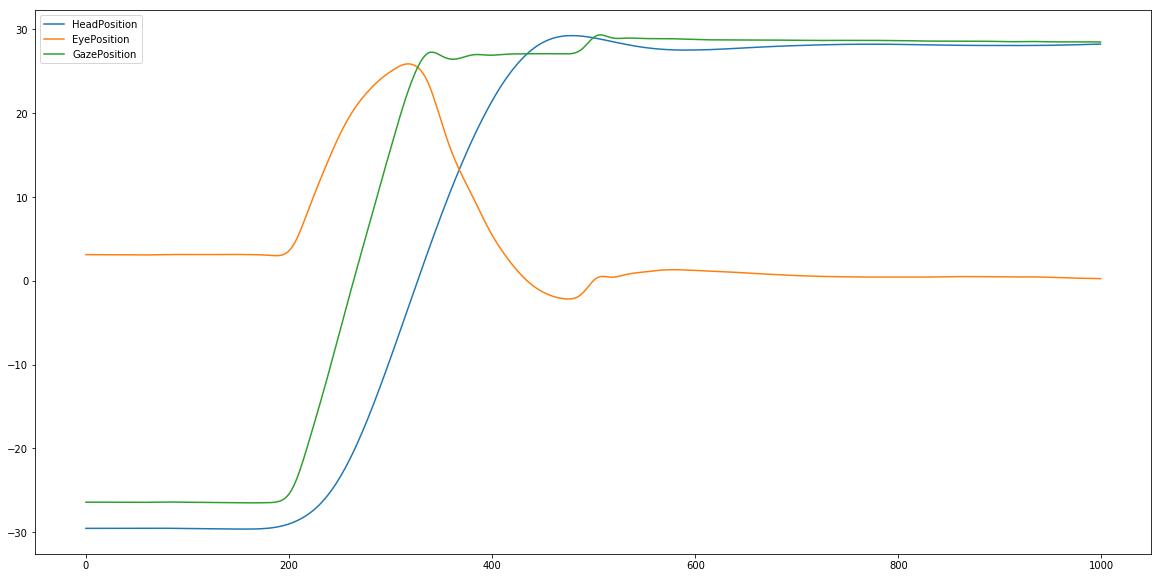

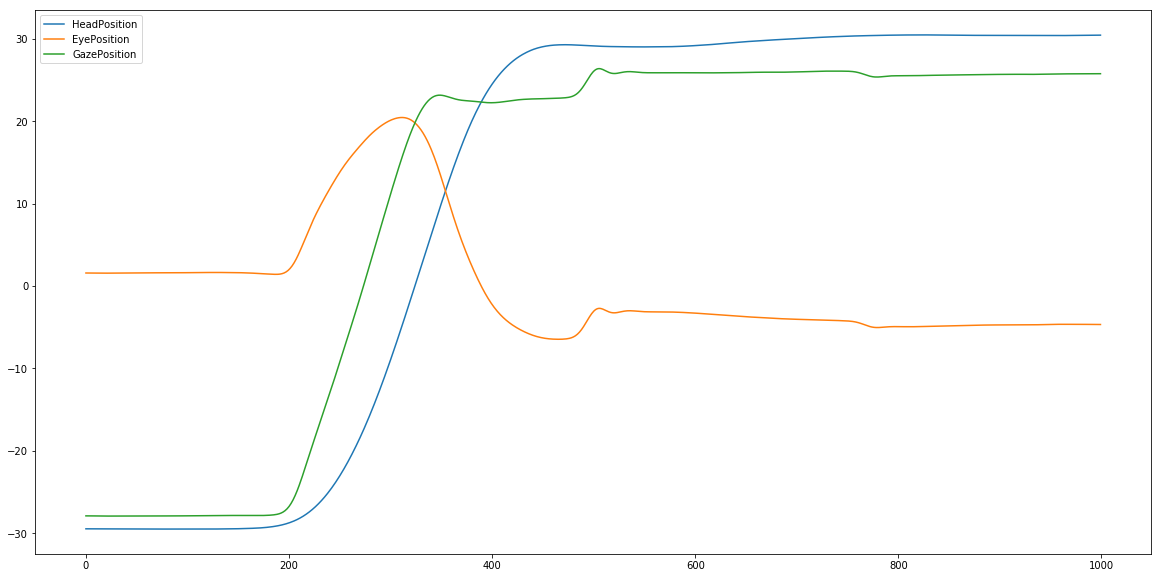

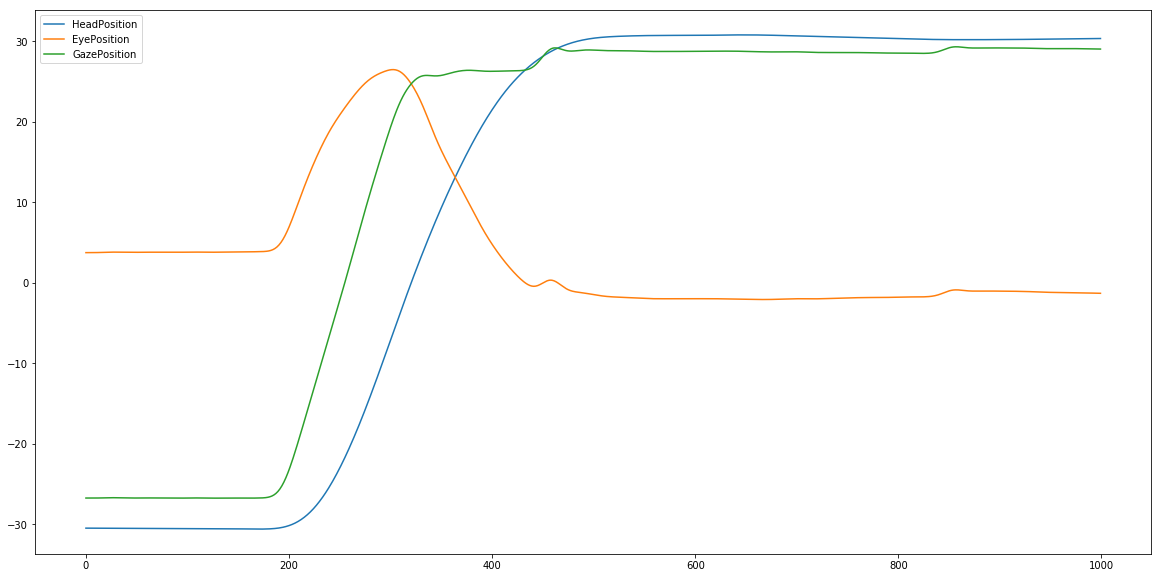

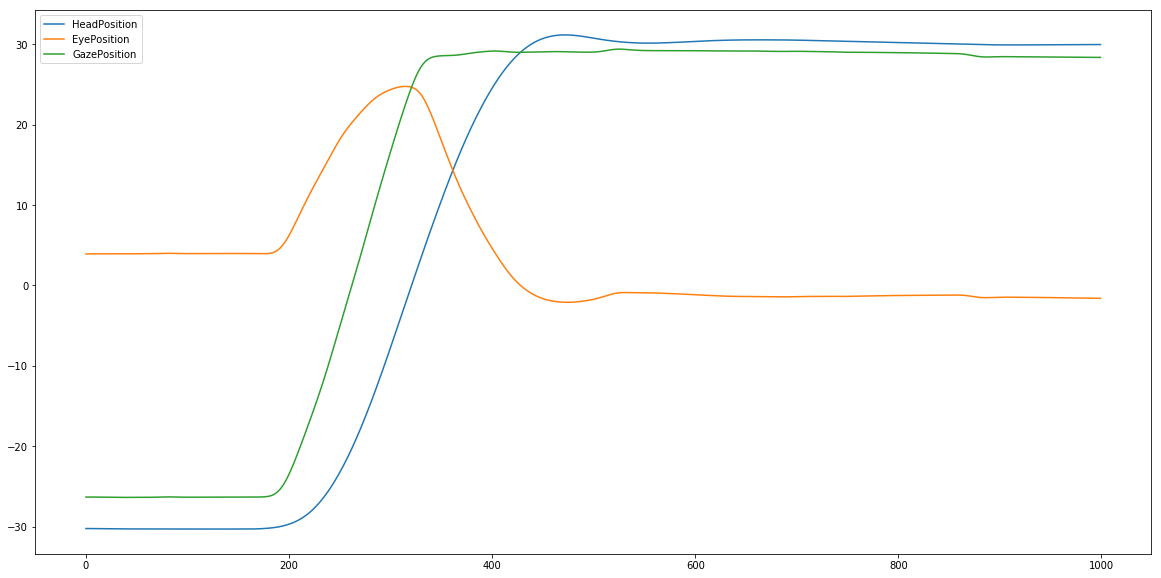

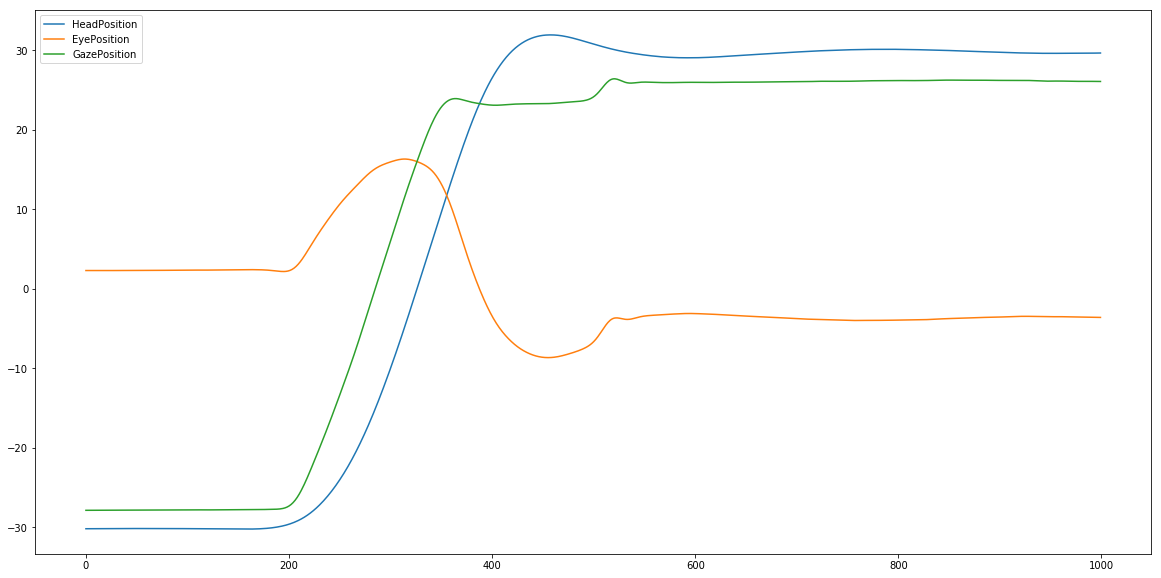

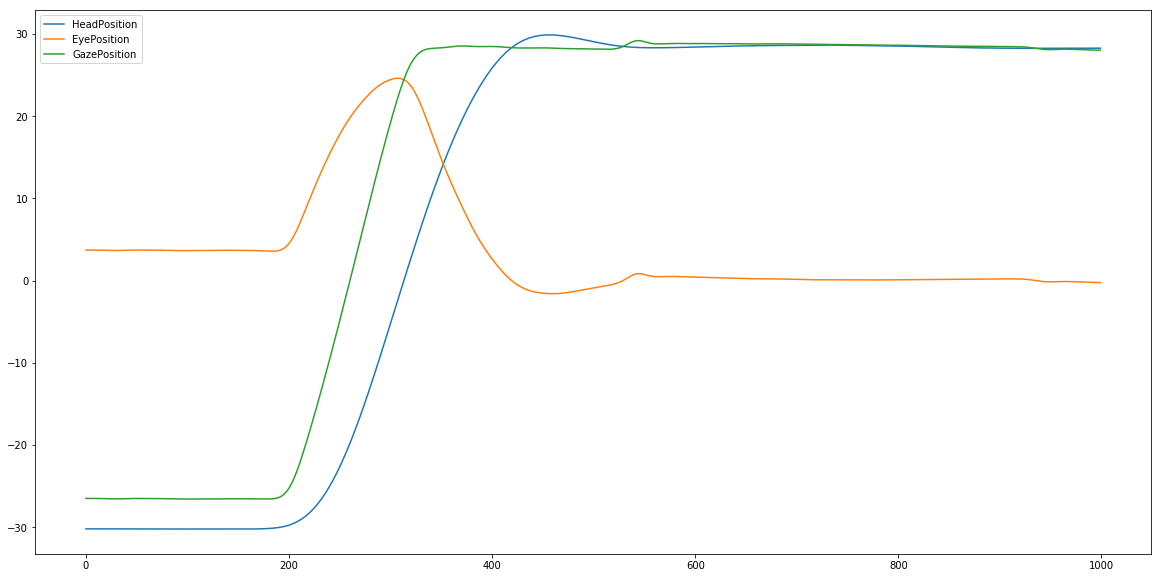

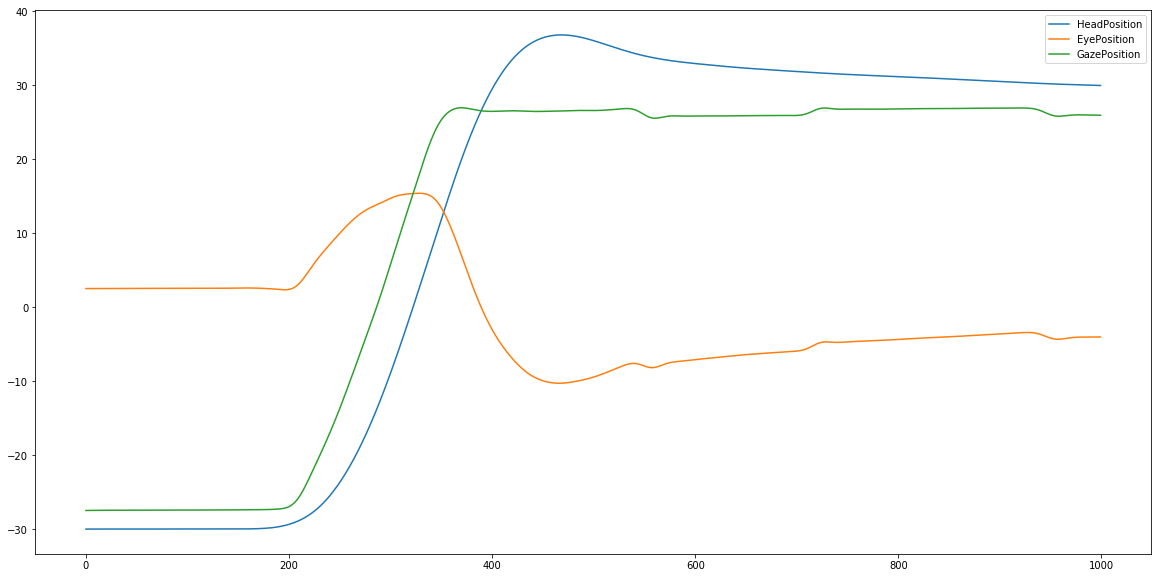

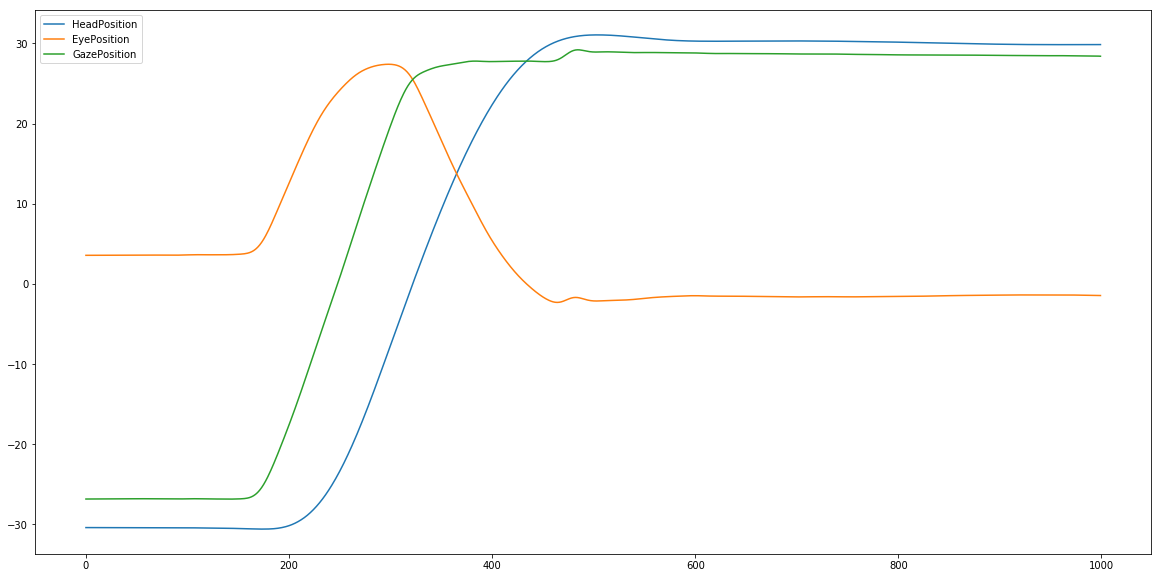

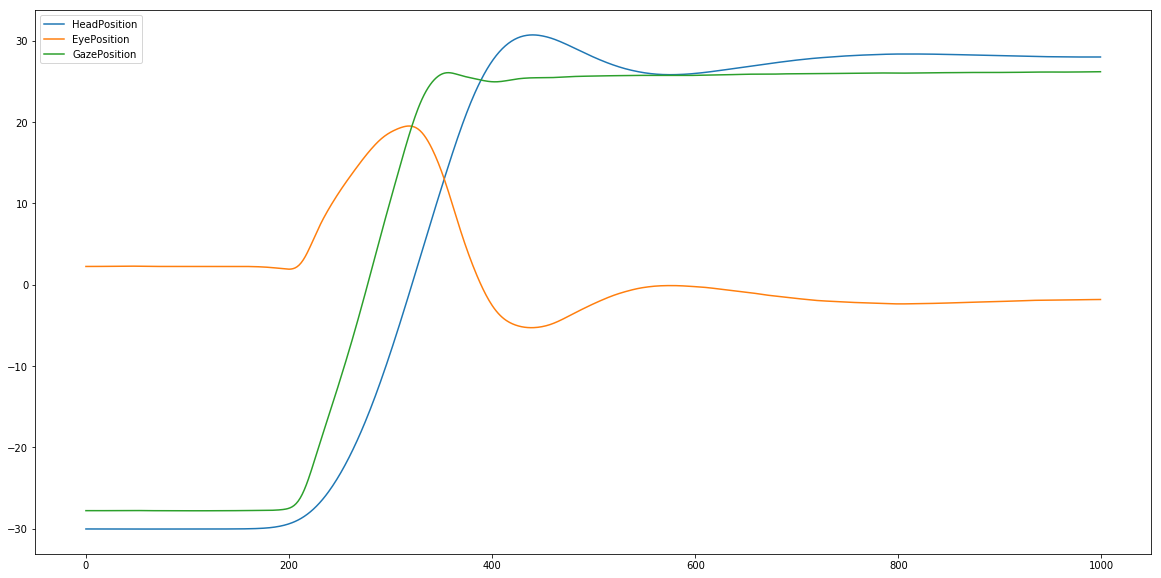

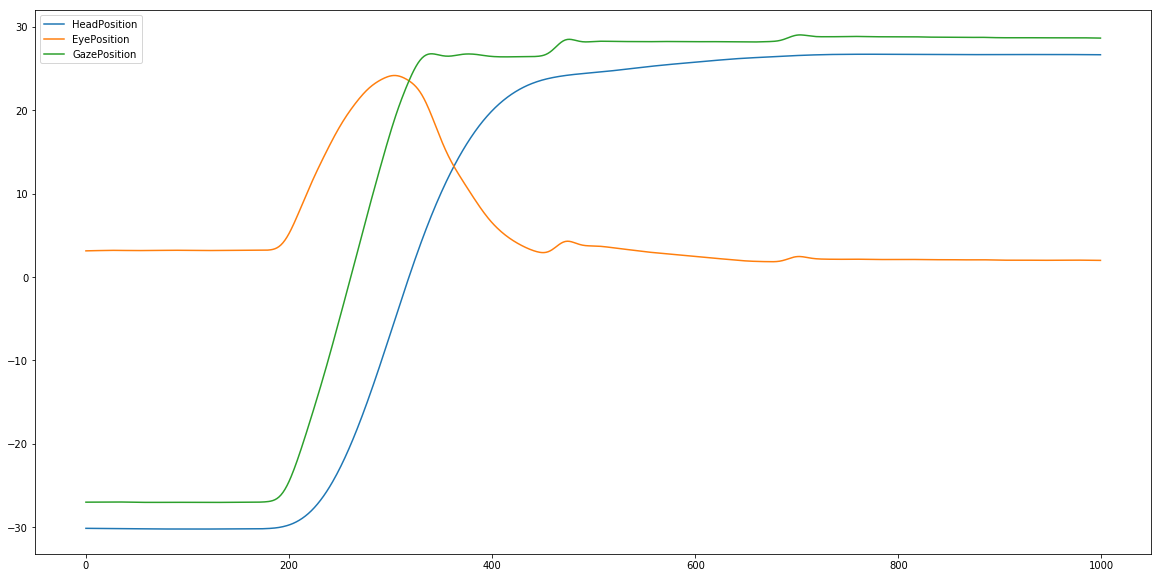

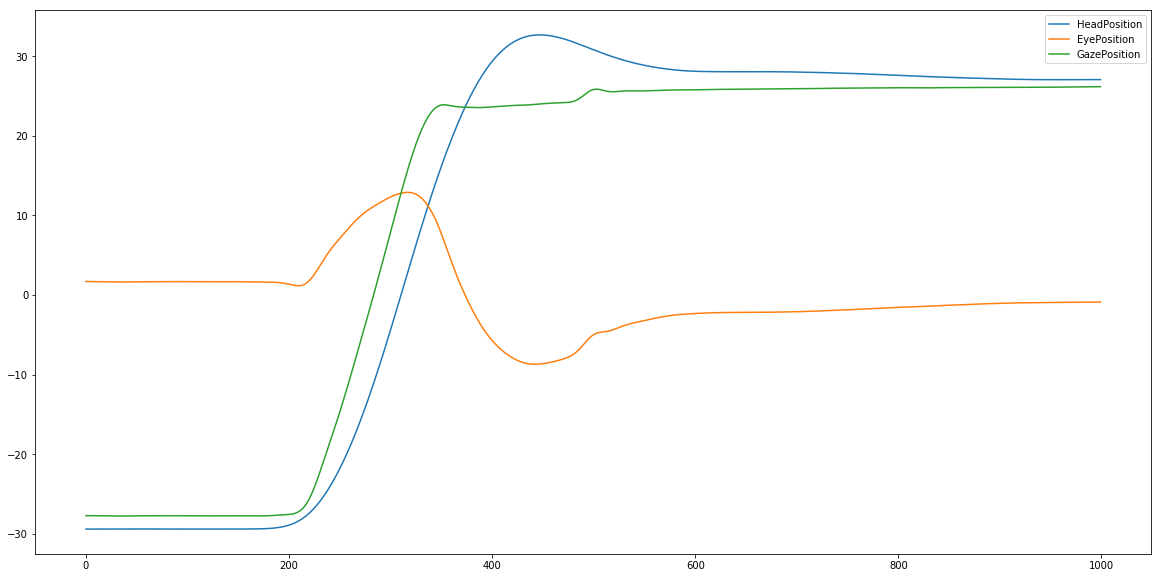

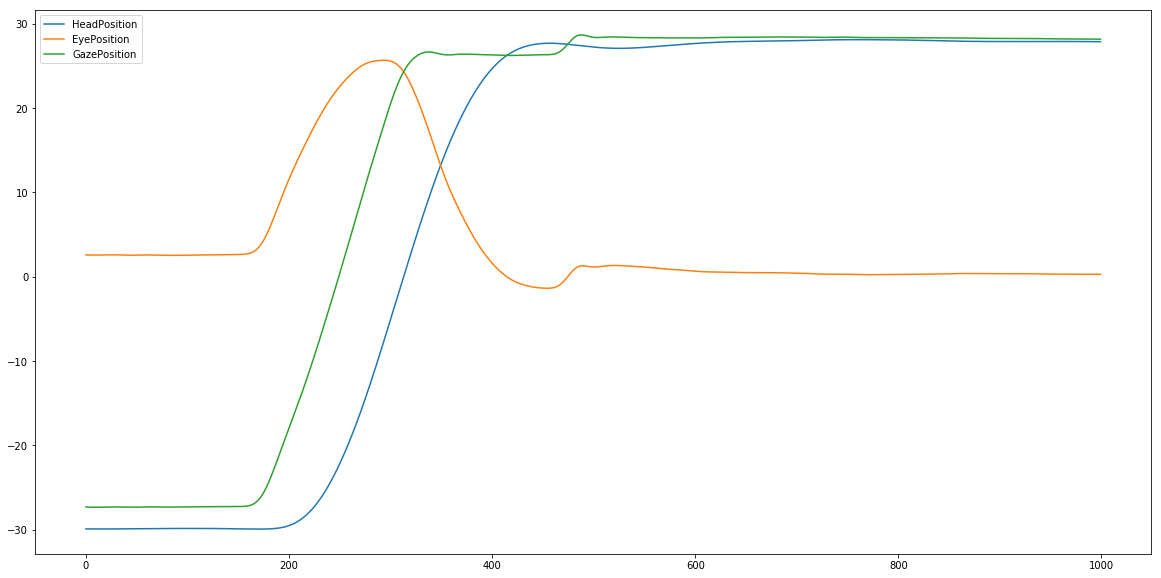

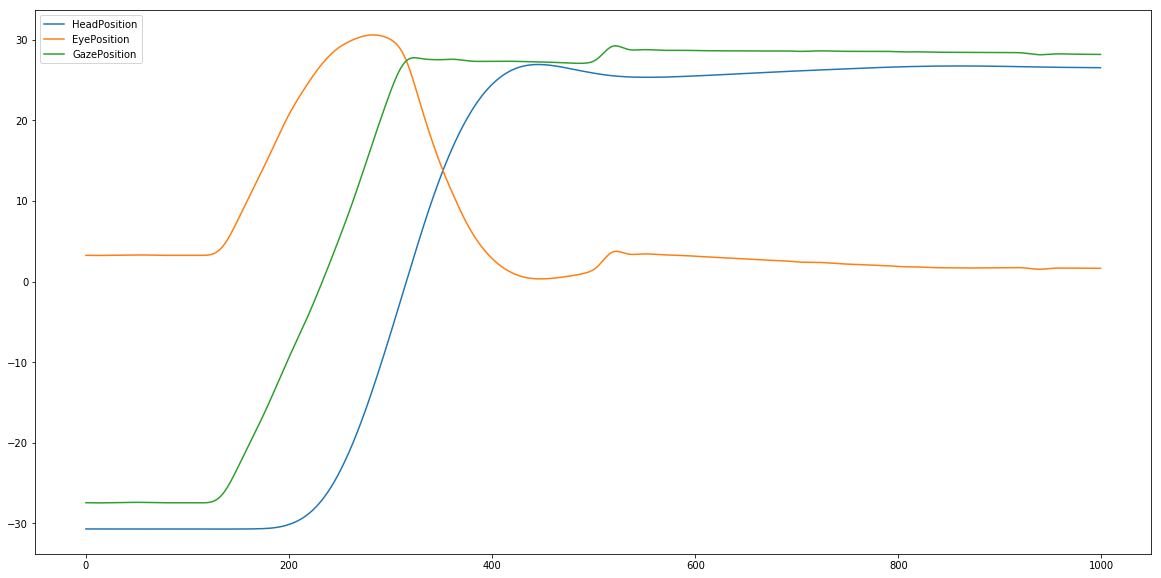

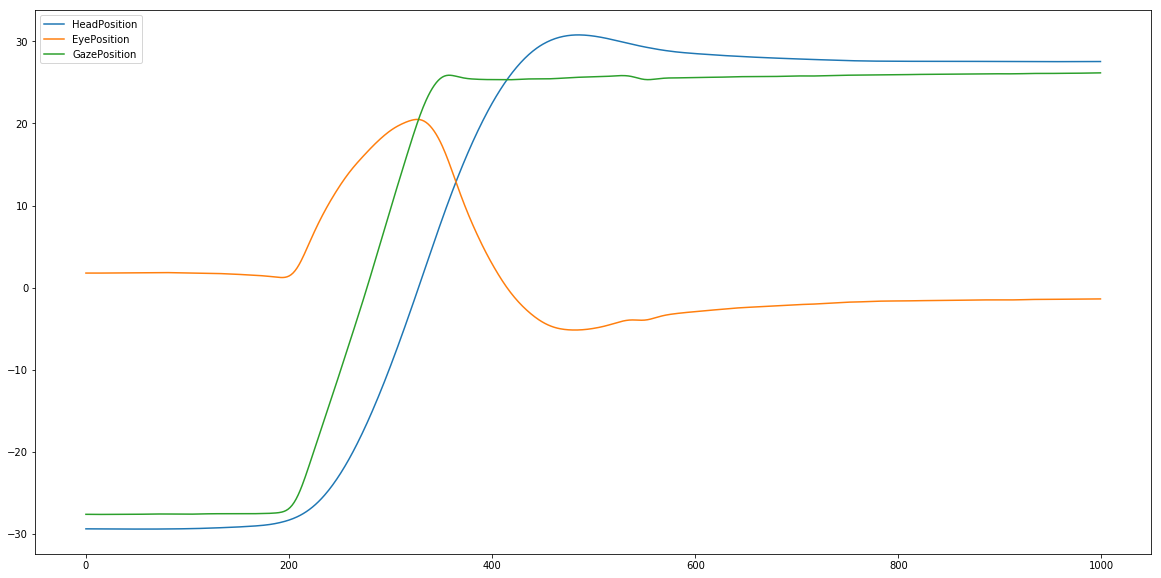

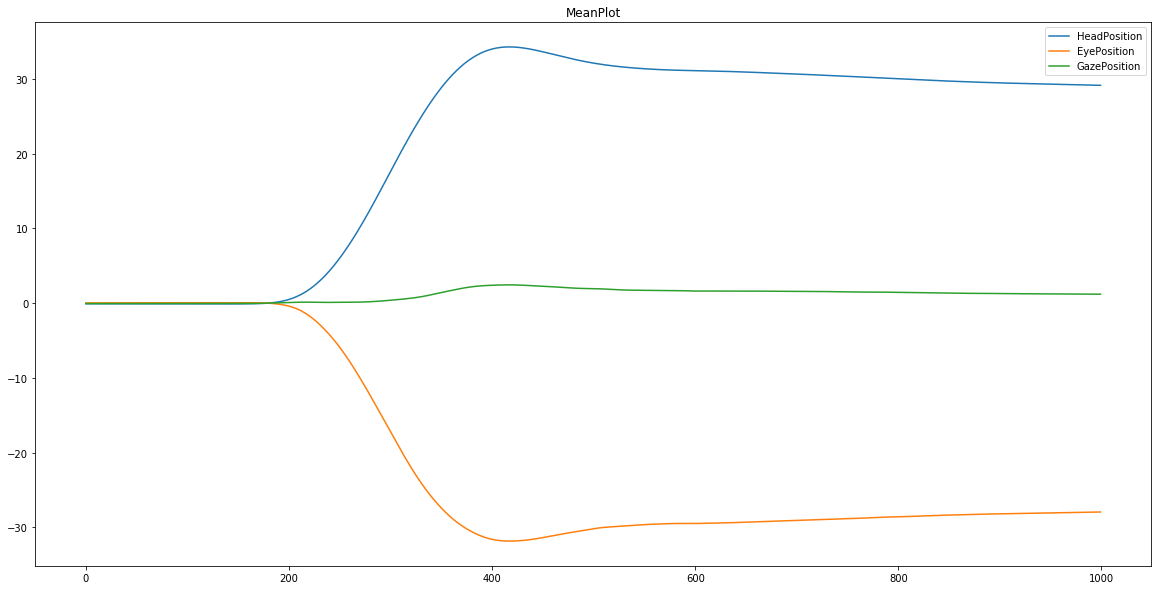

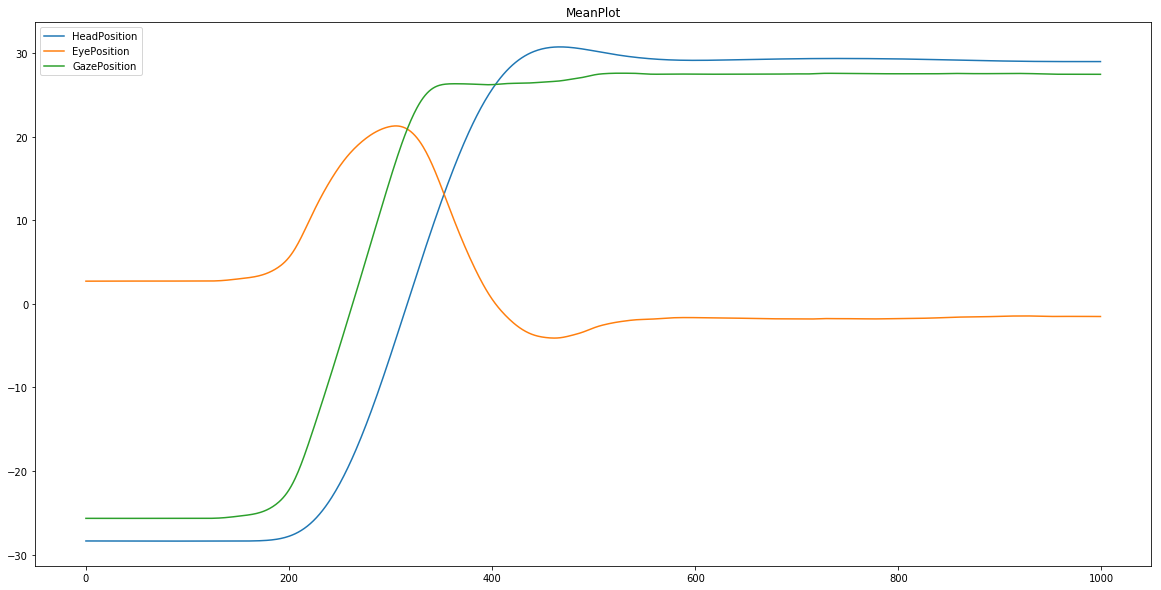

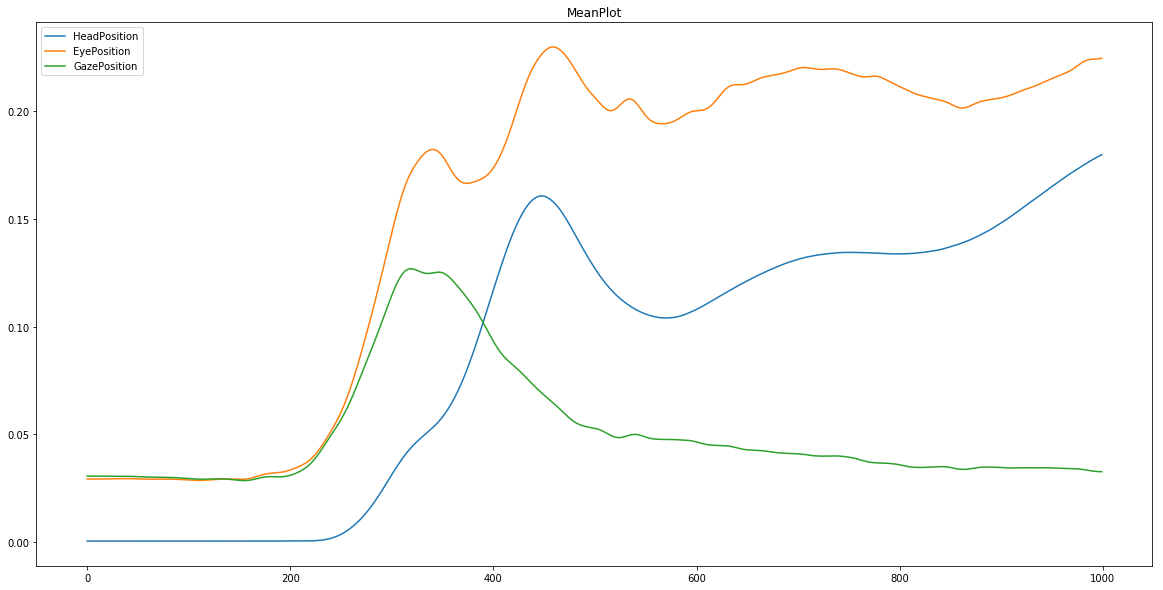

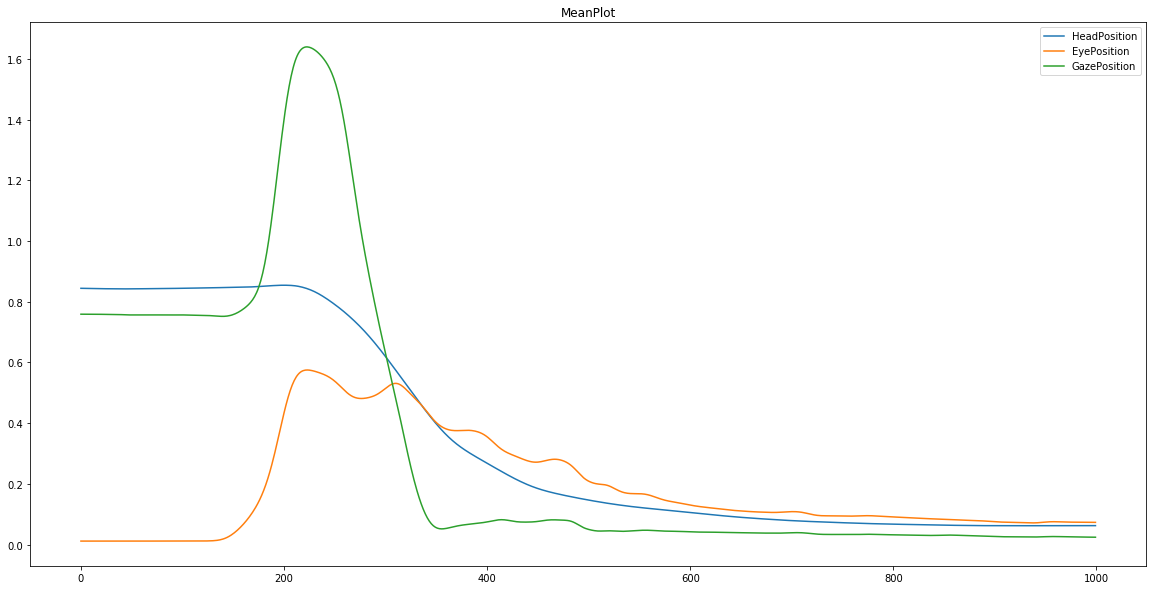

In [23]:
S_index += 1
sub_para = ["AcuityLog_2019_08_30_02_09_54.txt",\
        "AcuityLog_2019_08_30_02_25_56.txt",\
        "JumpLog__2019_08_30_02_09_54.txt",\
        "JumpLog__2019_08_30_02_25_56.txt",\
        "JumpLog__2019_08_30_02_25_56_2.txt",\
        "AcuityLog_2019_08_30_02_48_29.txt",\
        "",\
        "MIdata.mat",\
        "0"
       ]
DY_DL = [0]
GA_DL = [7,17]
run_subject(sub_para, DY_DL = DY_DL, GA_DL = GA_DL)

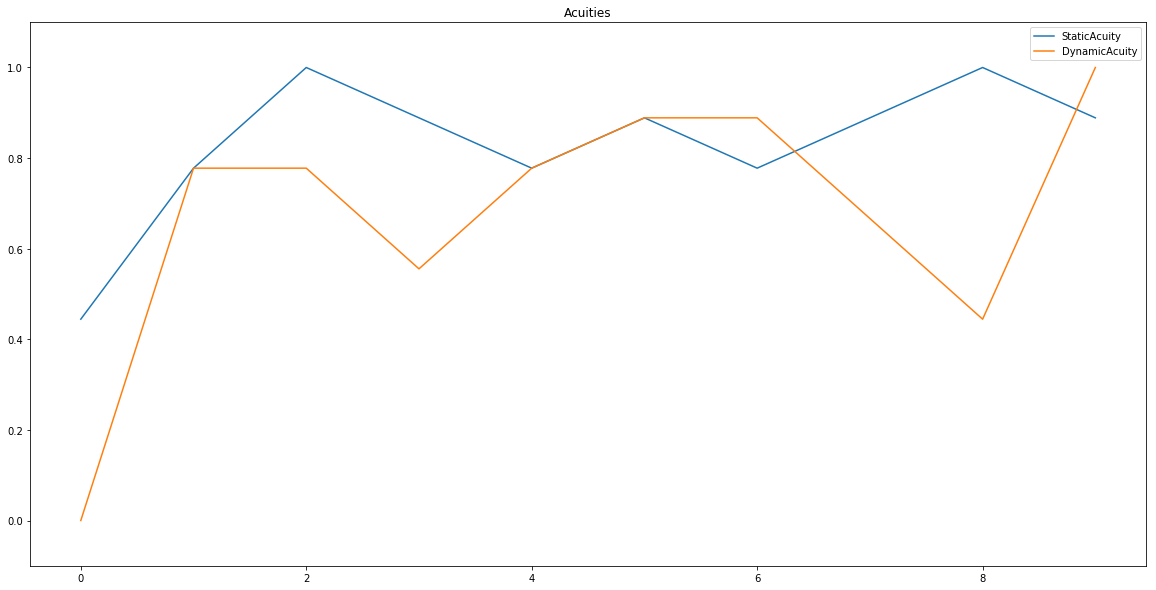

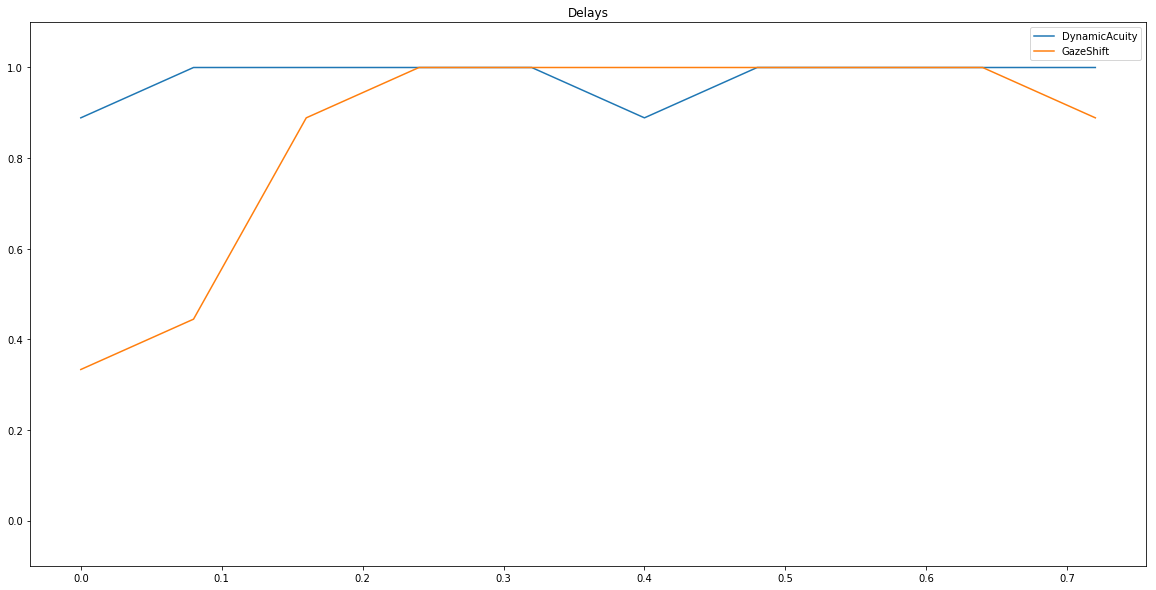

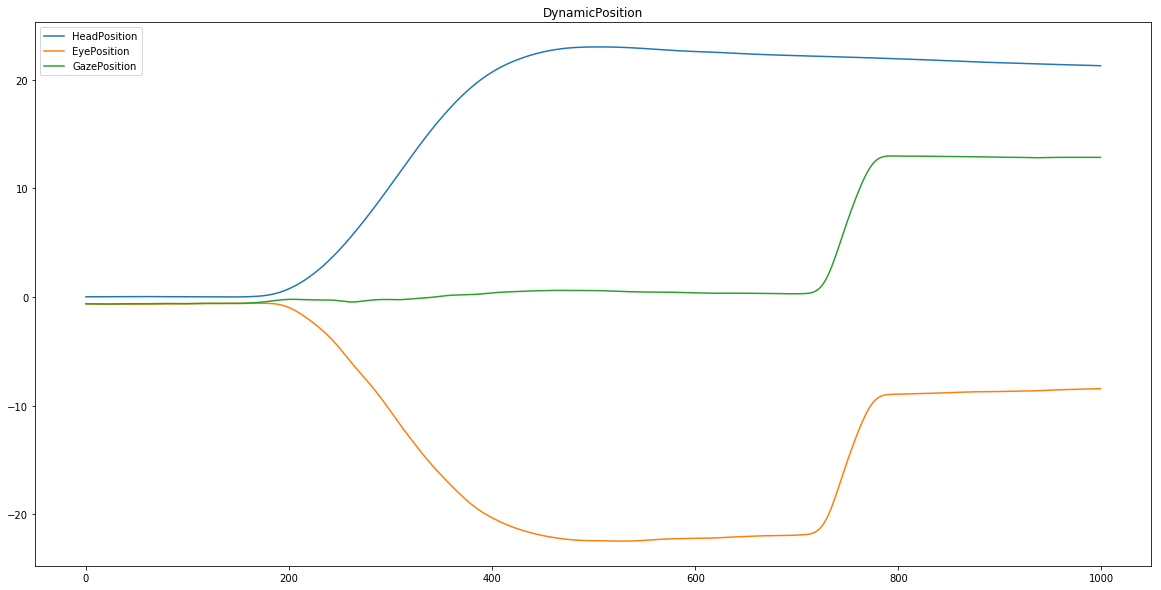

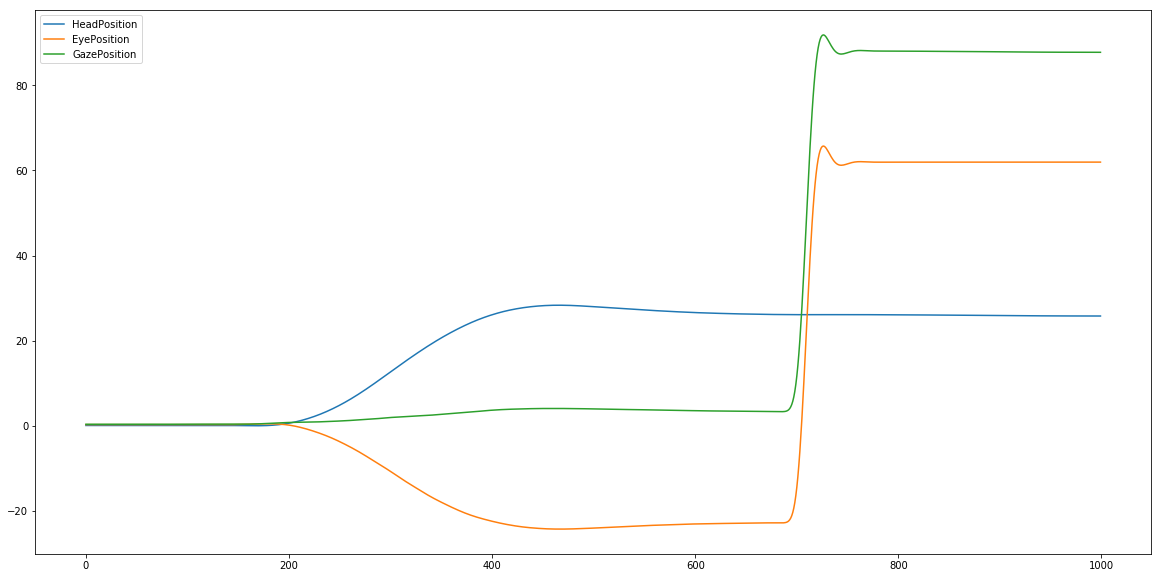

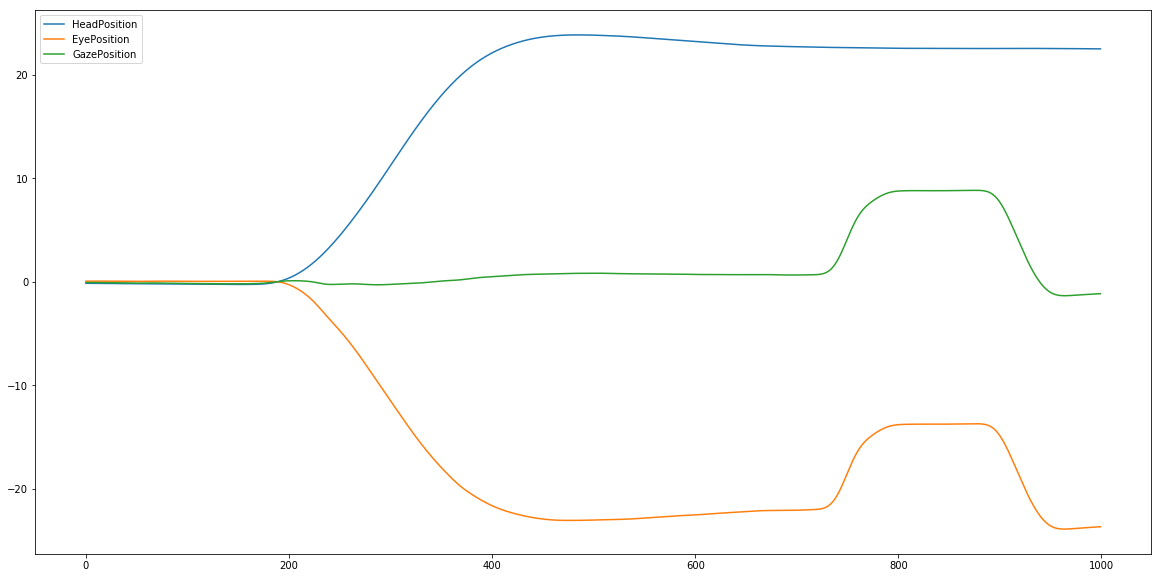

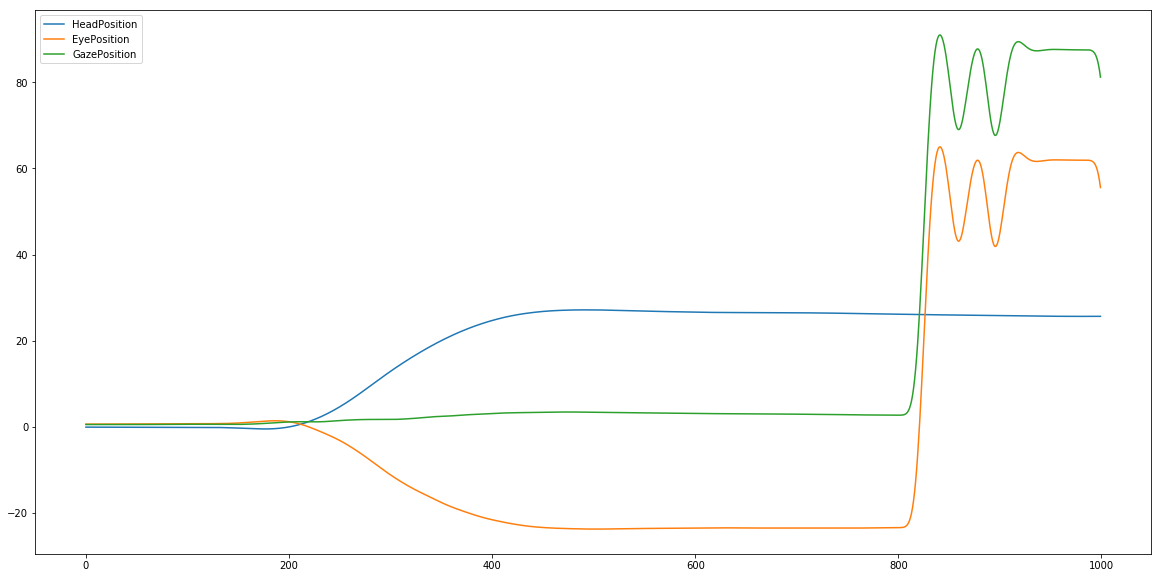

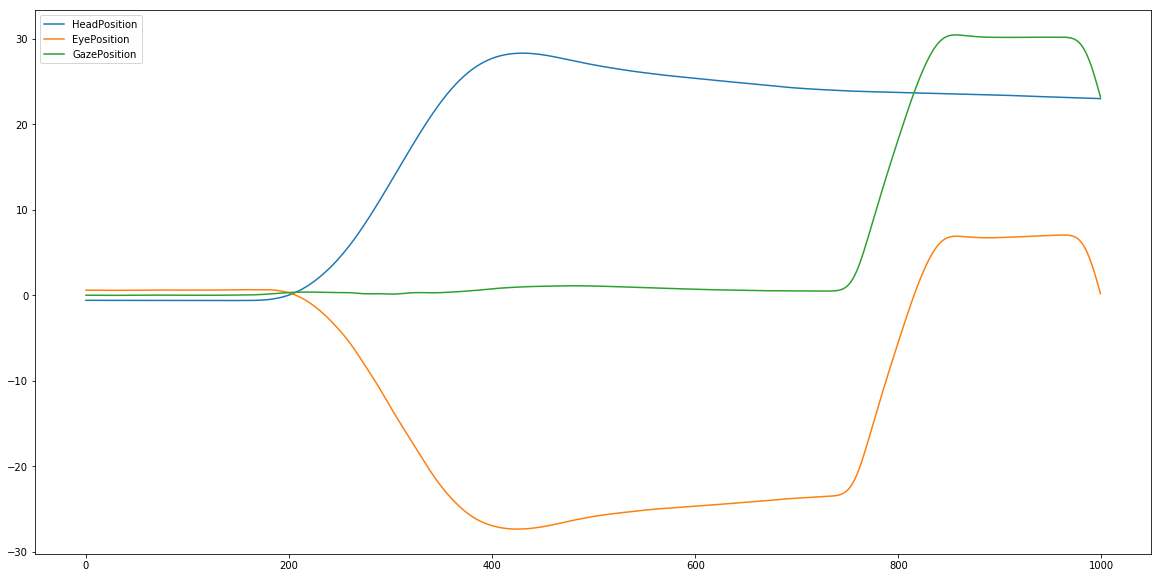

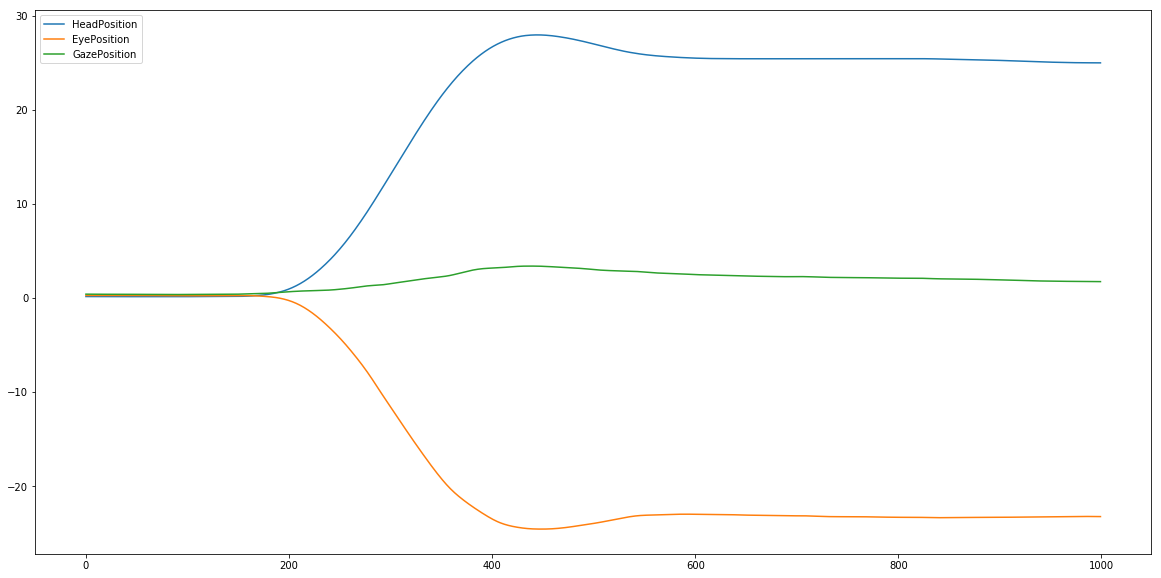

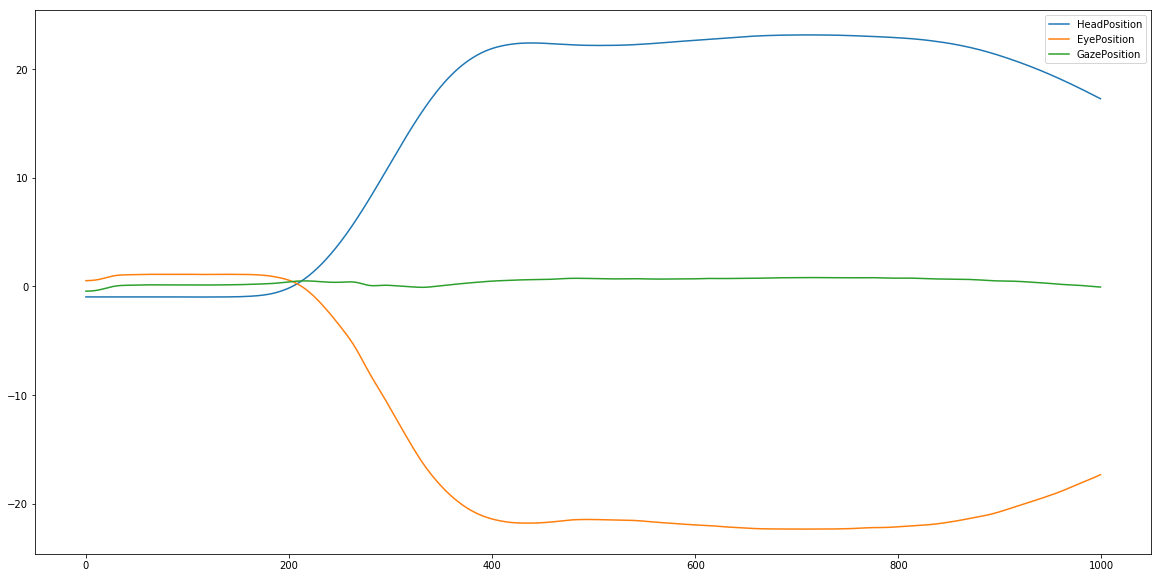

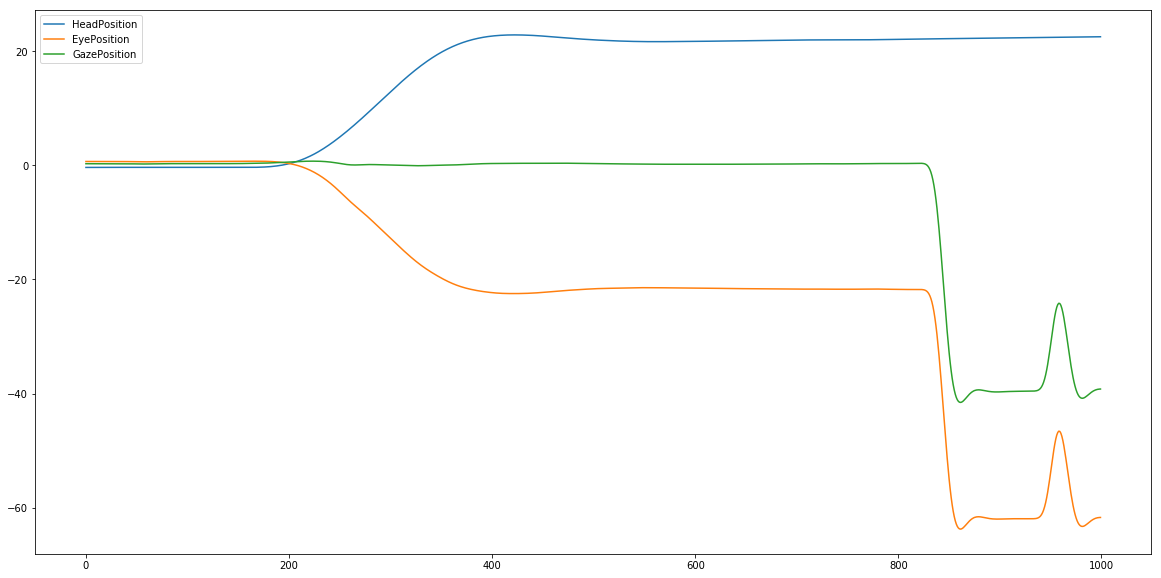

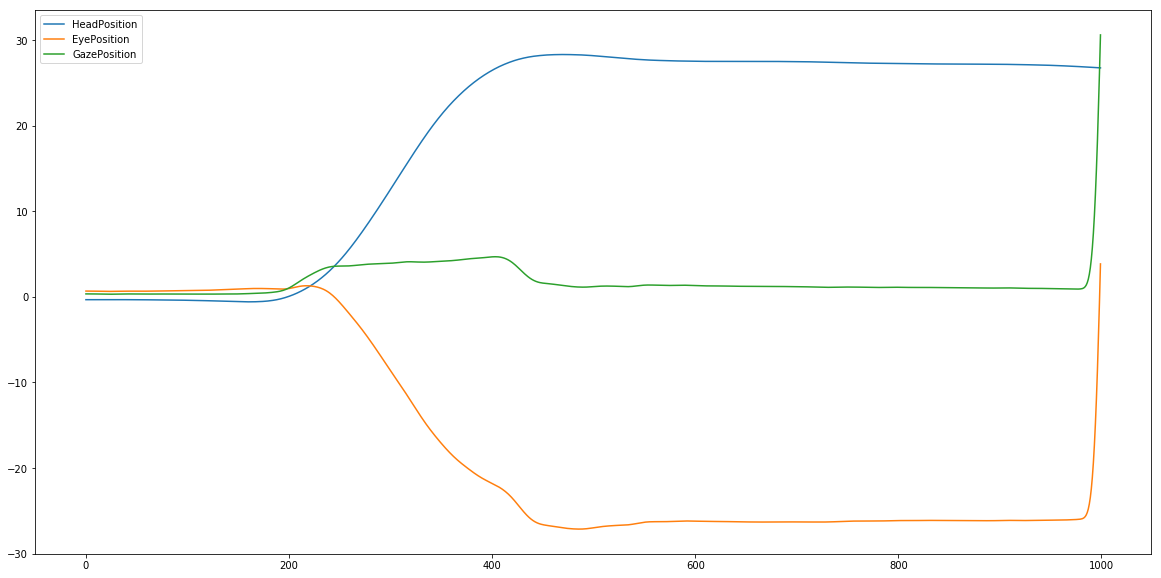

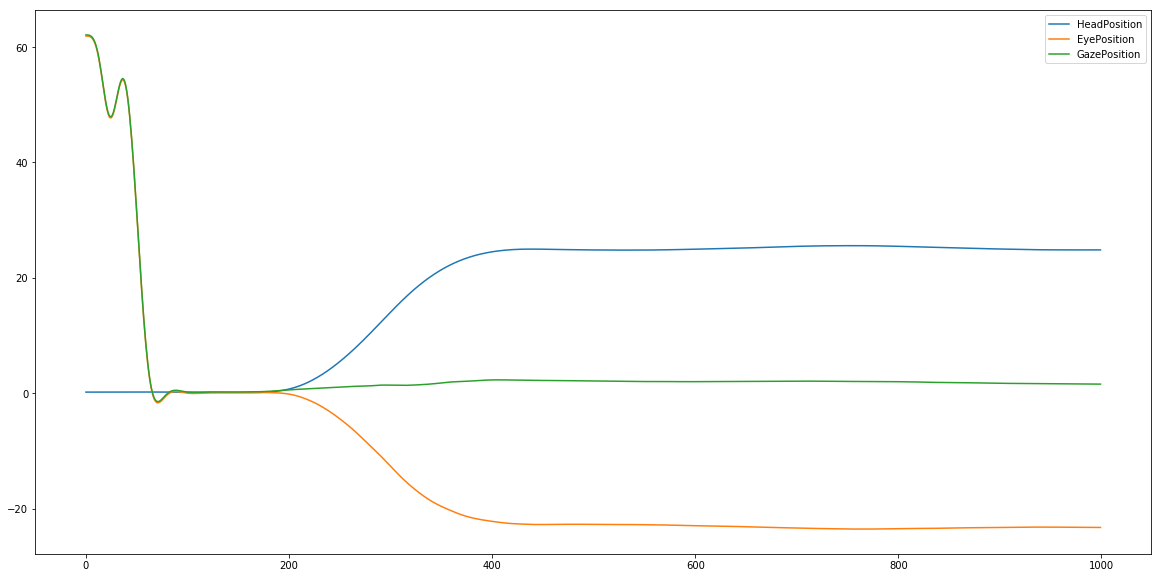

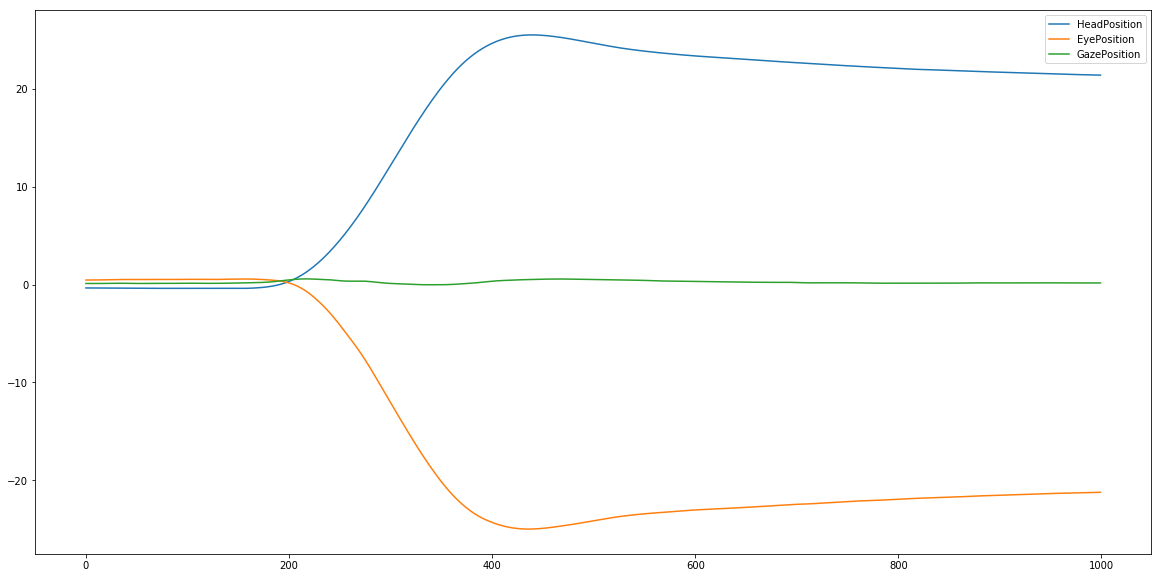

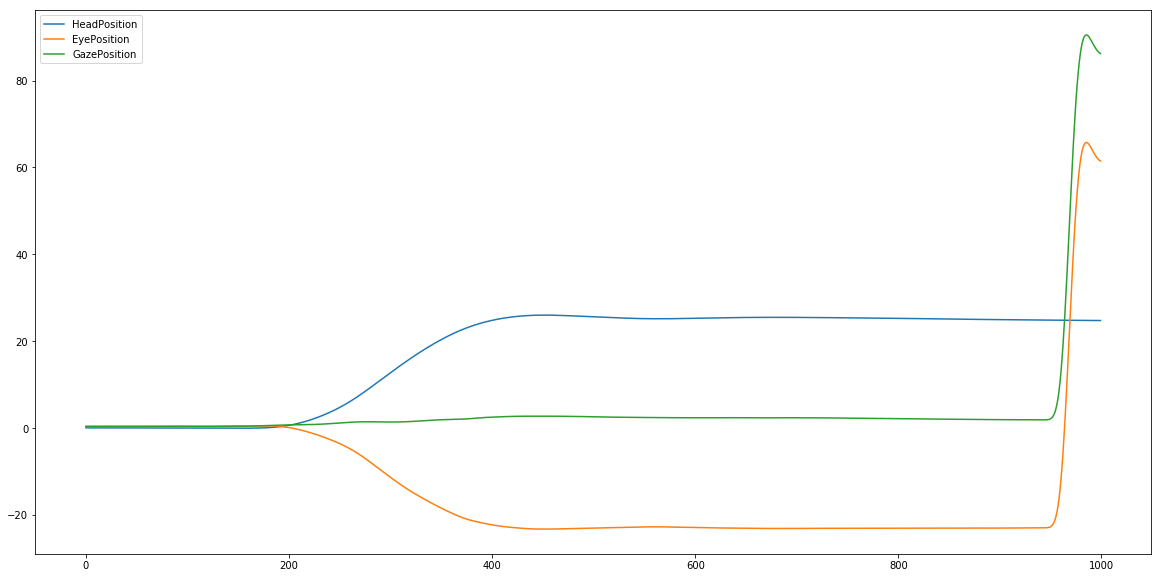

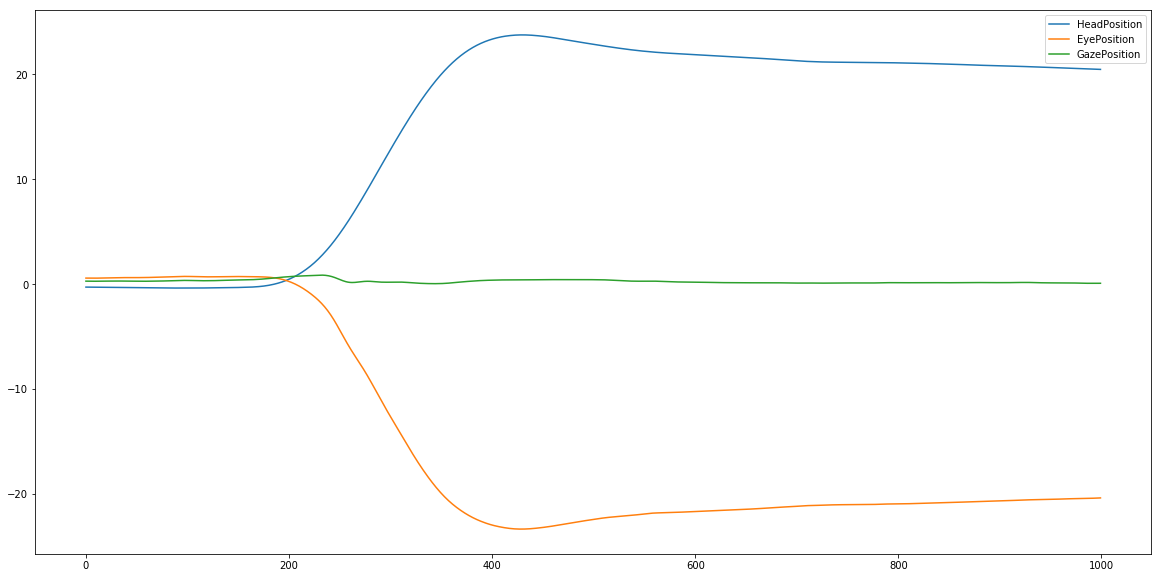

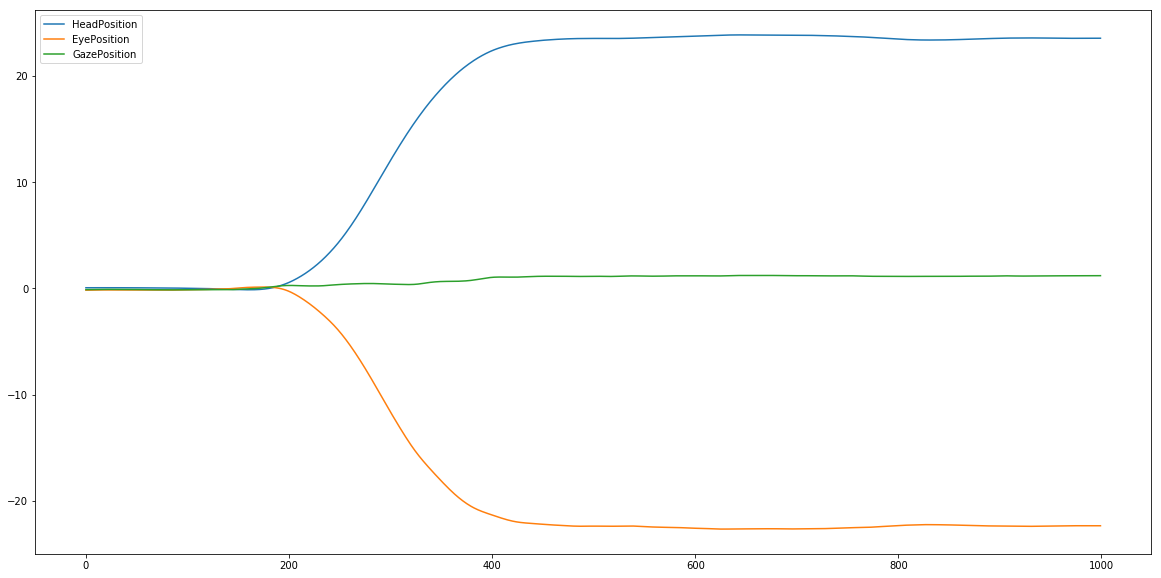

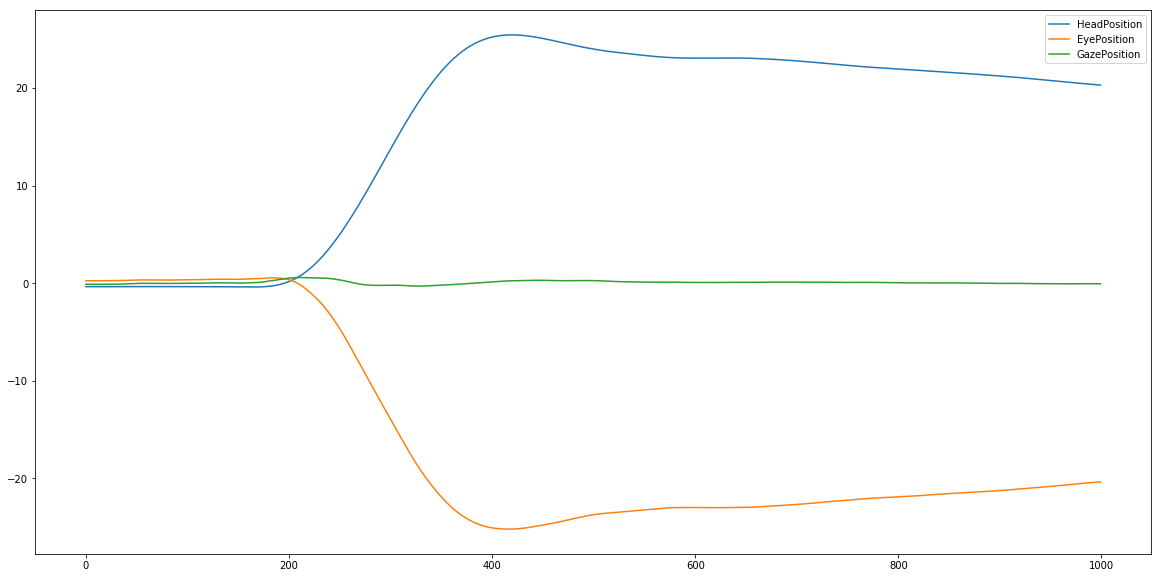

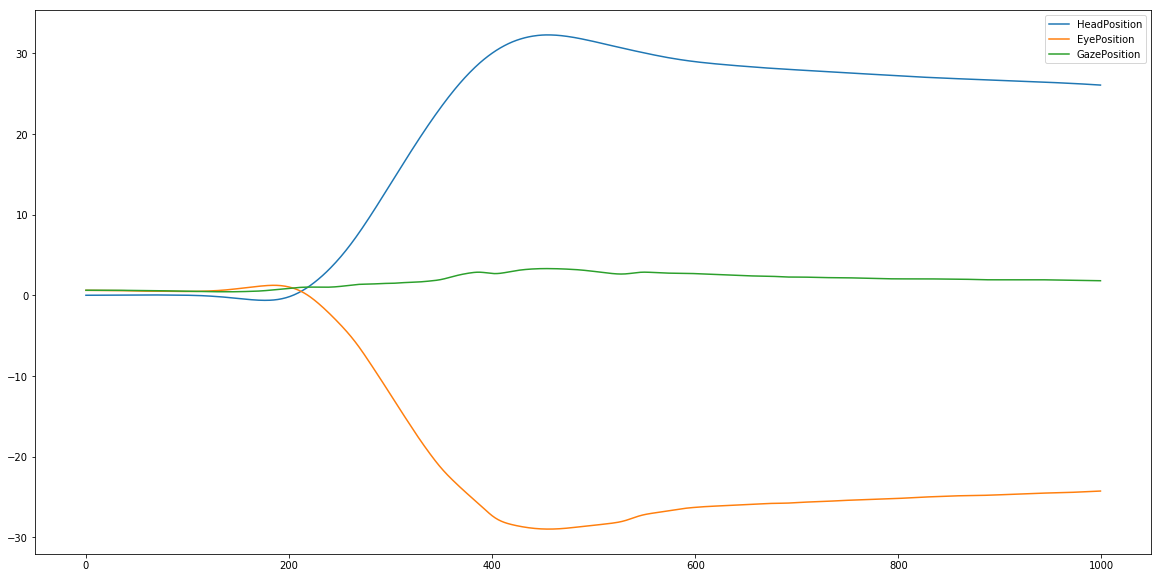

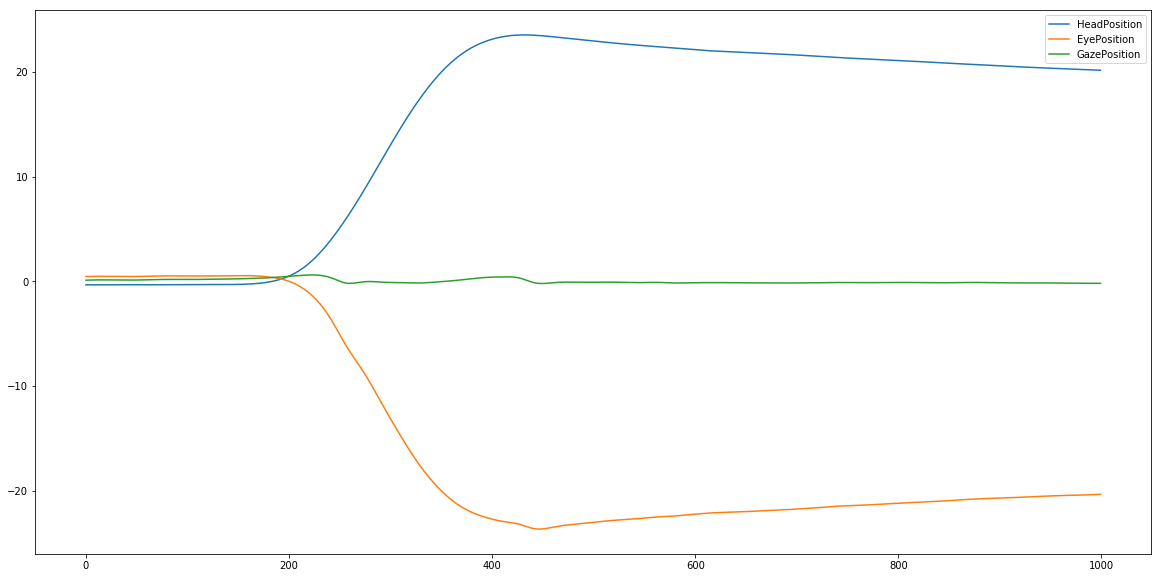

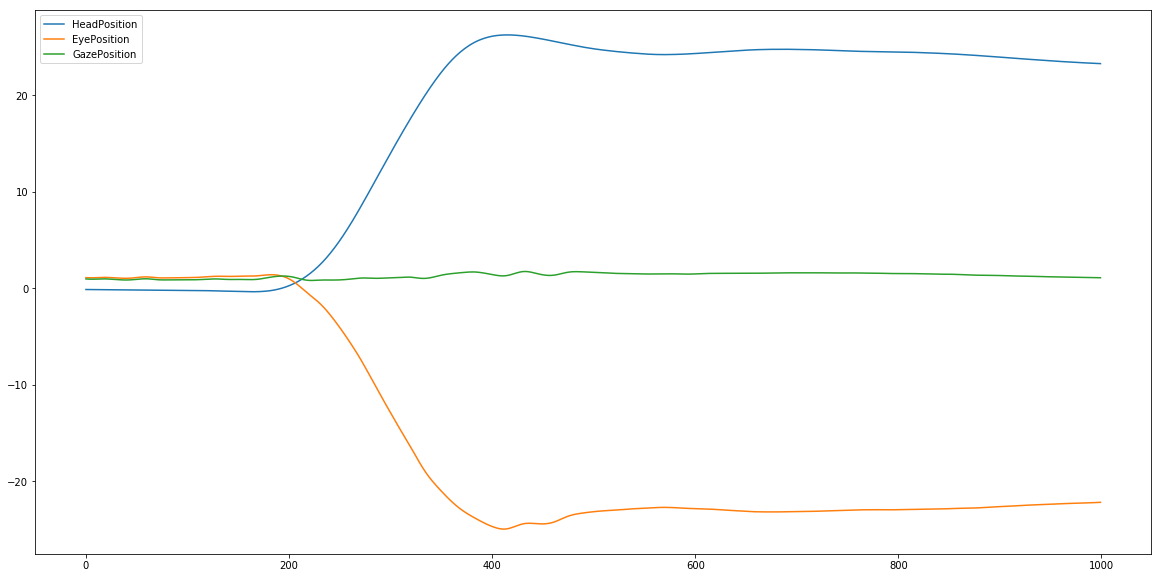

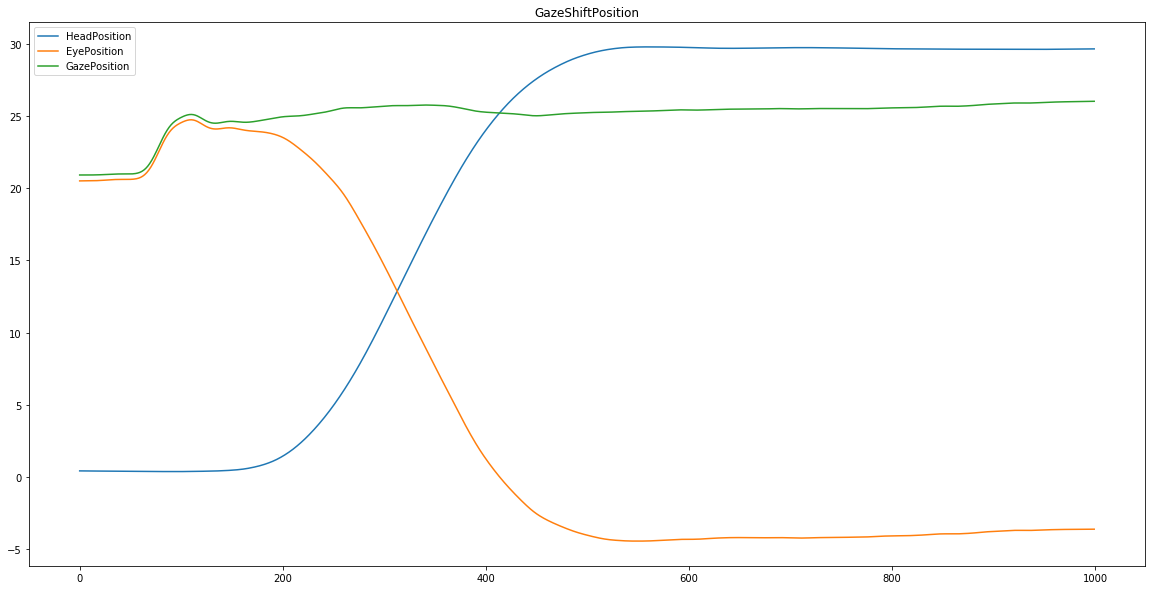

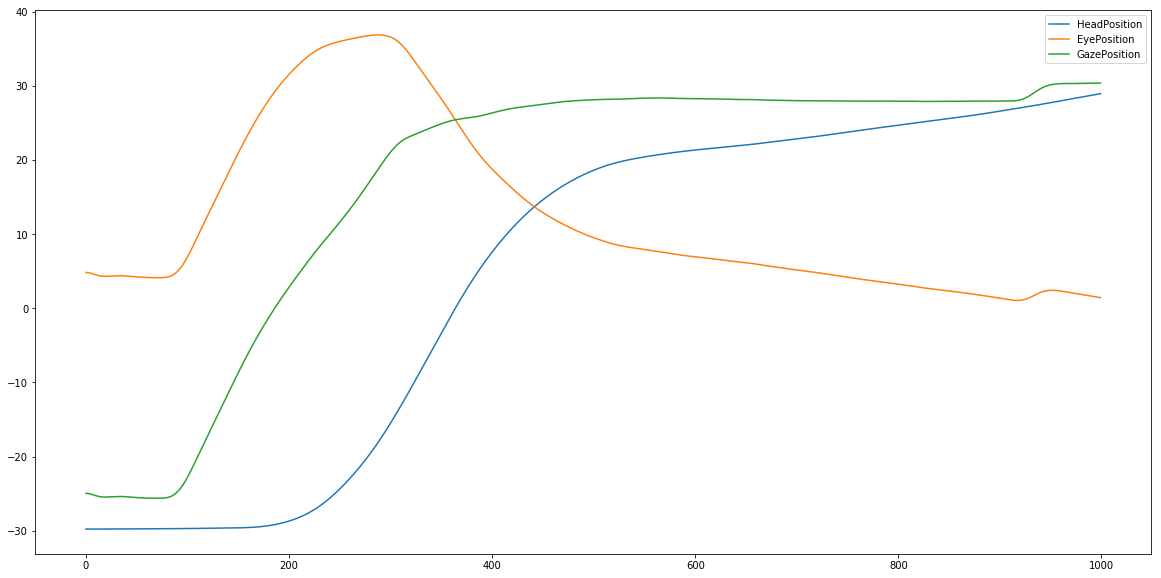

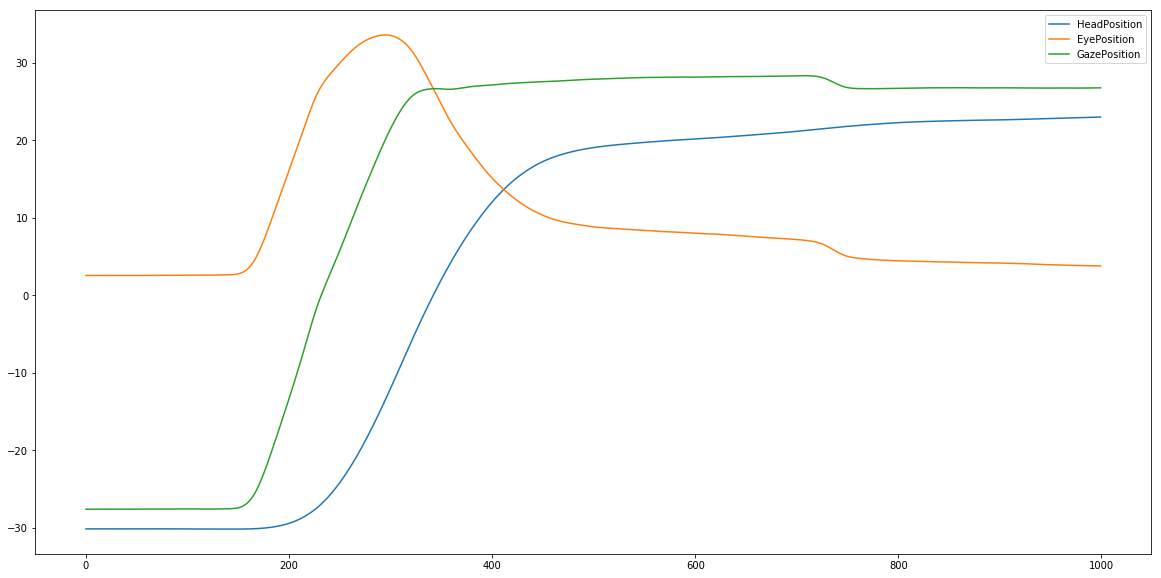

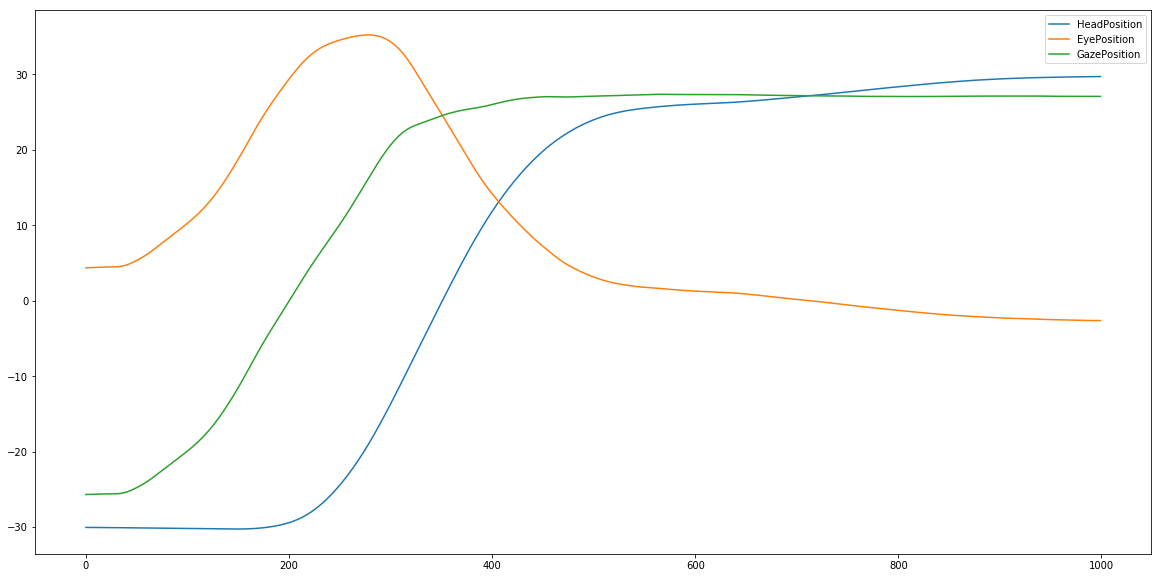

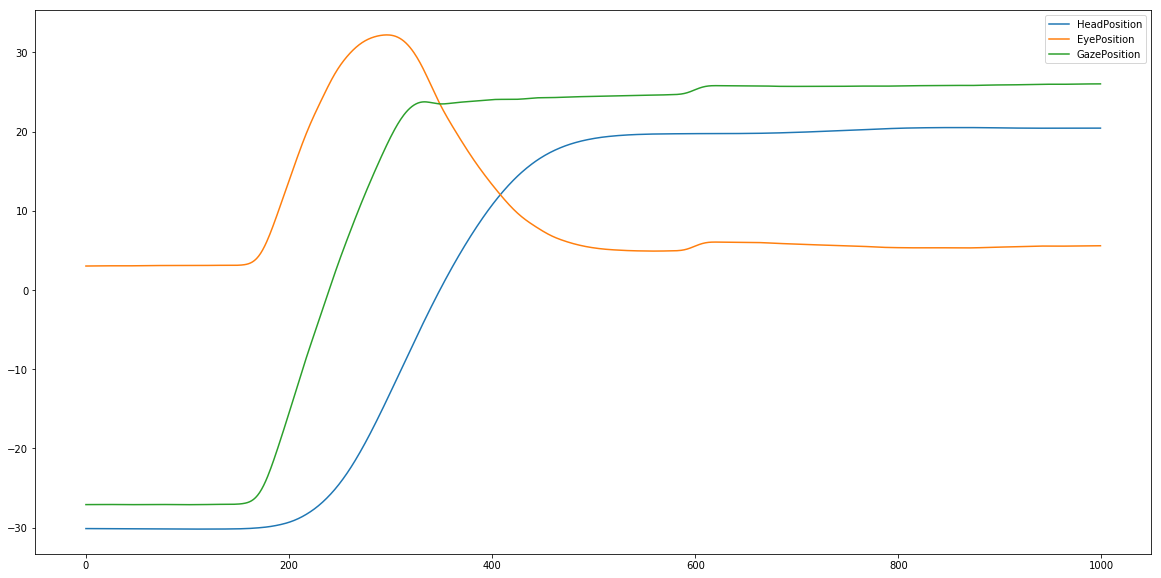

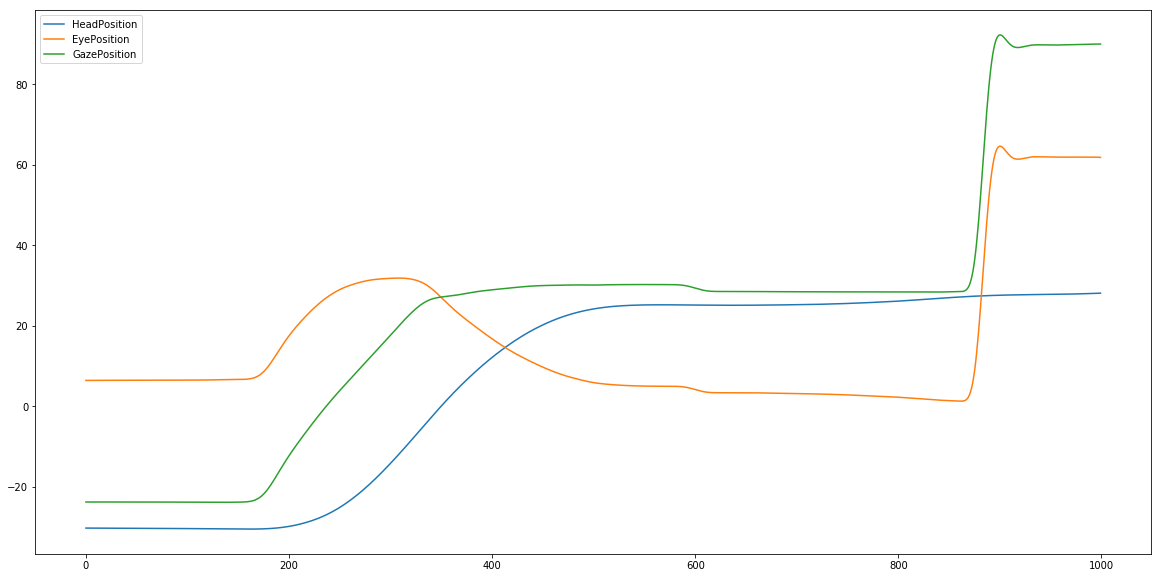

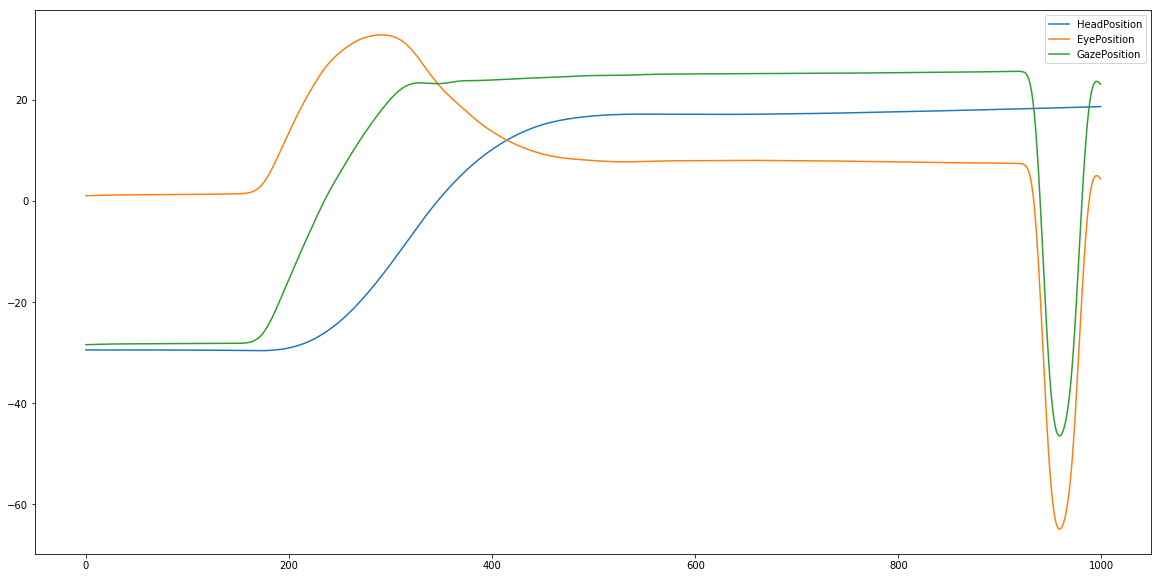

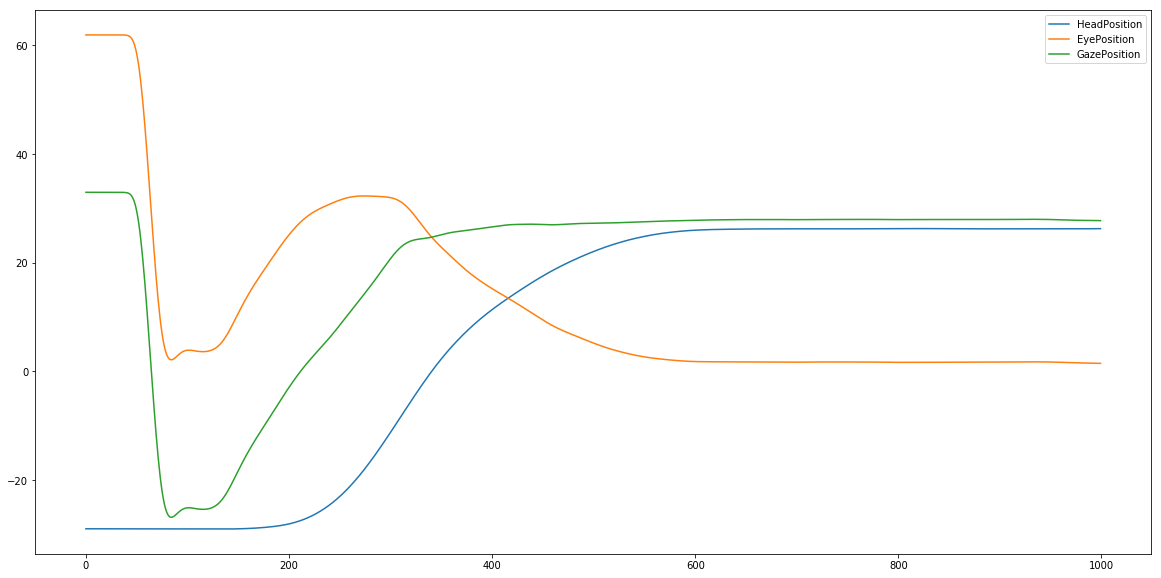

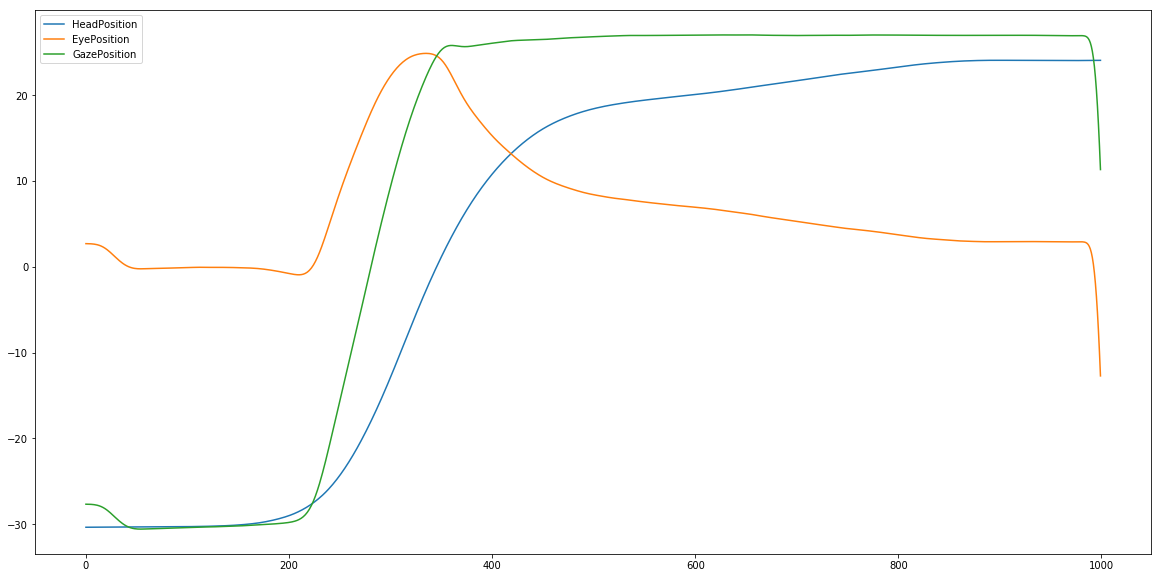

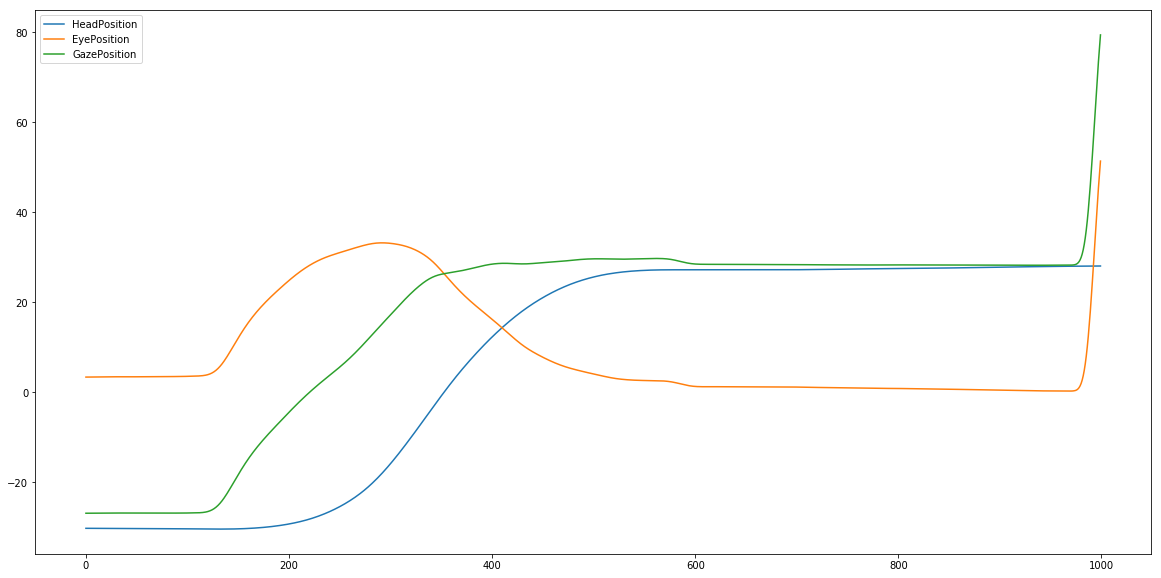

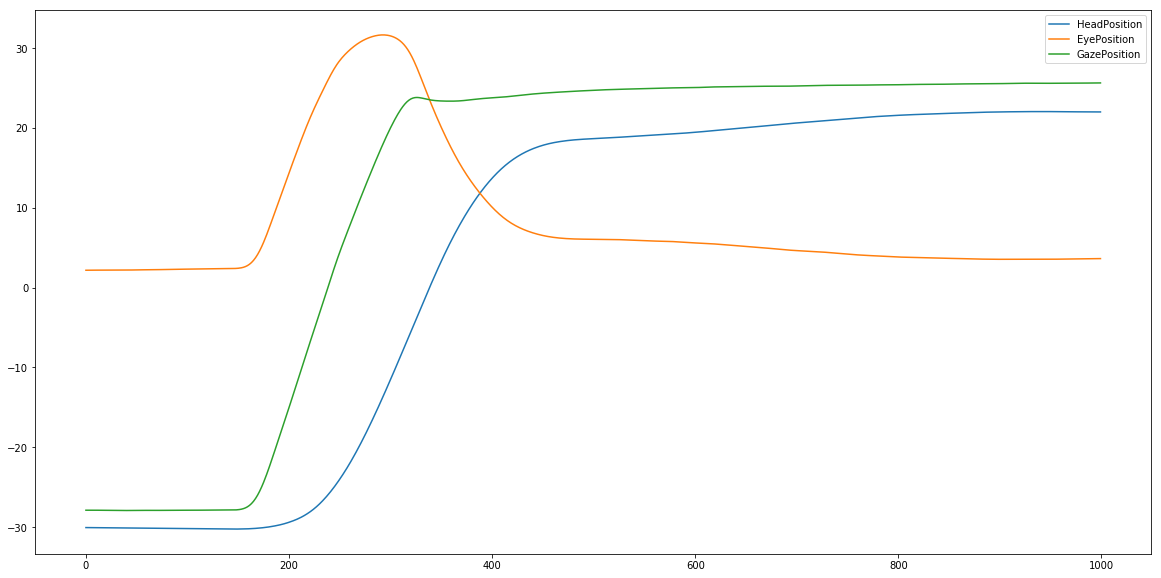

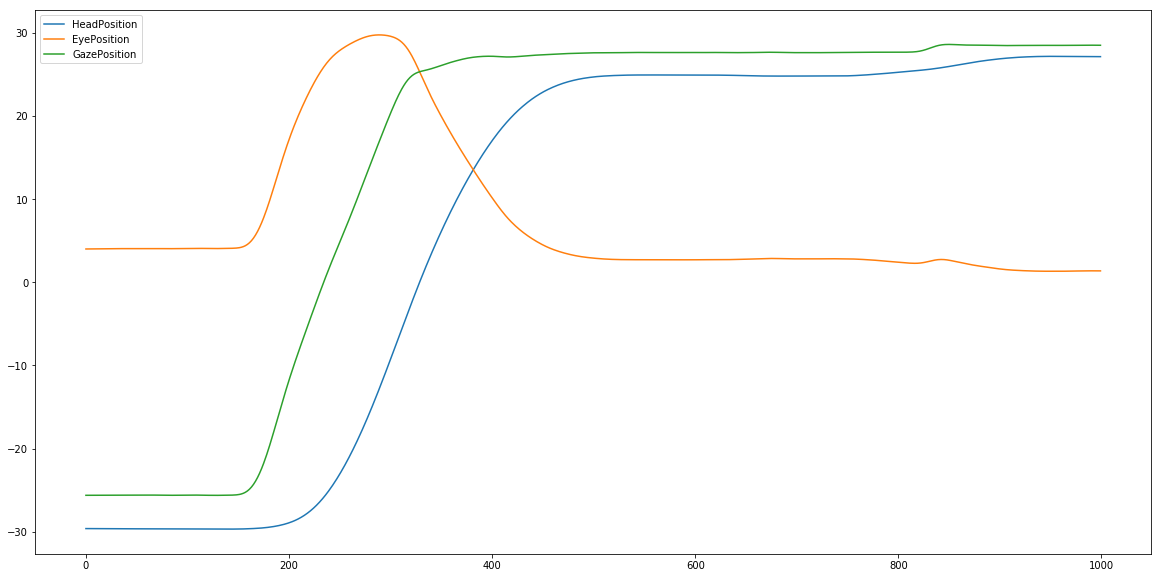

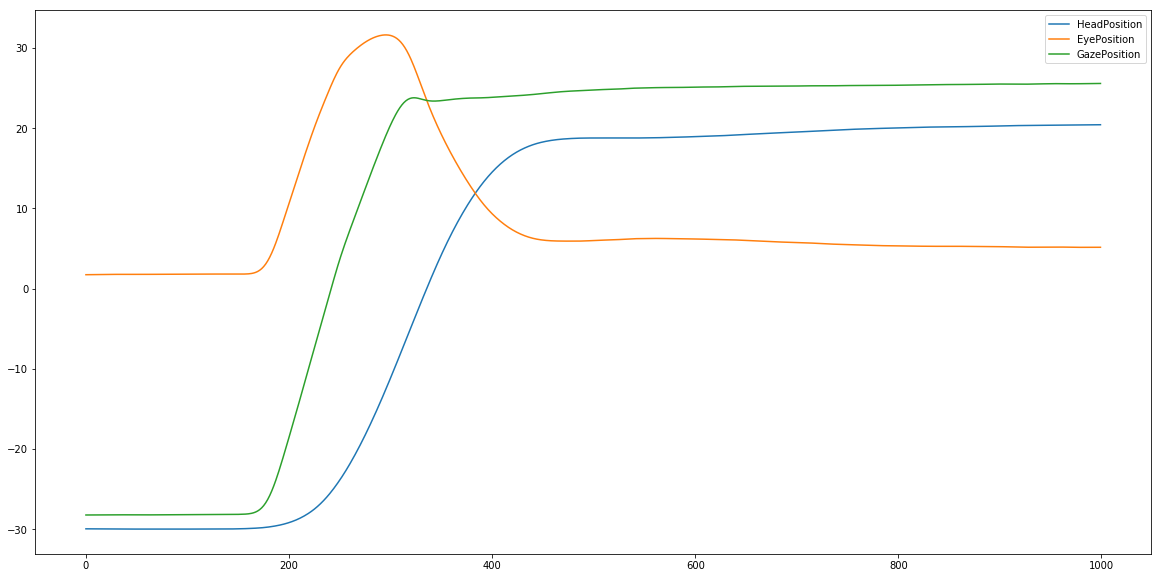

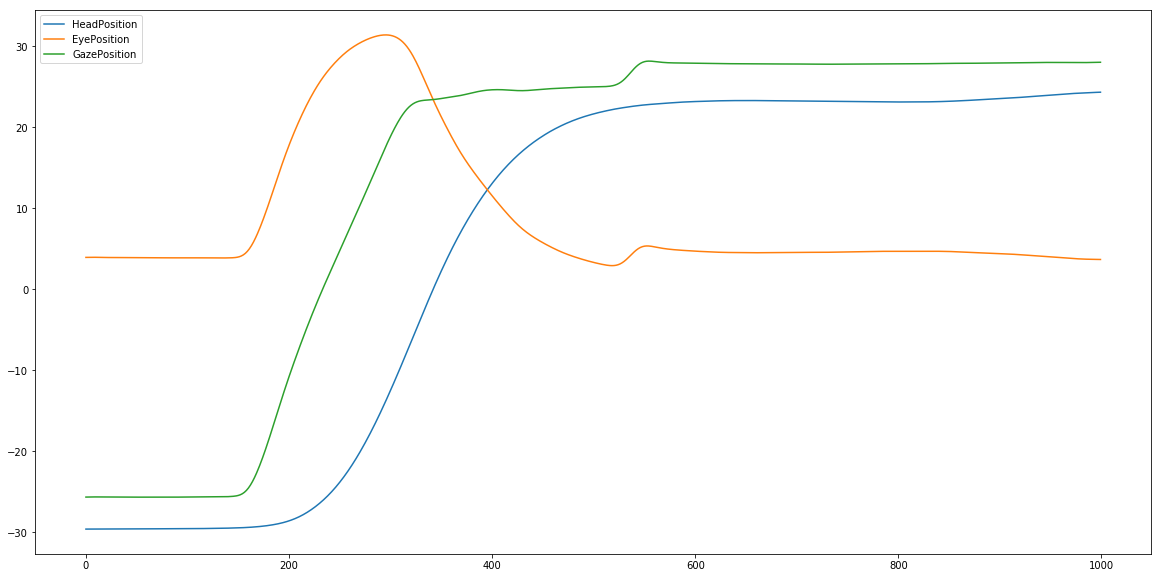

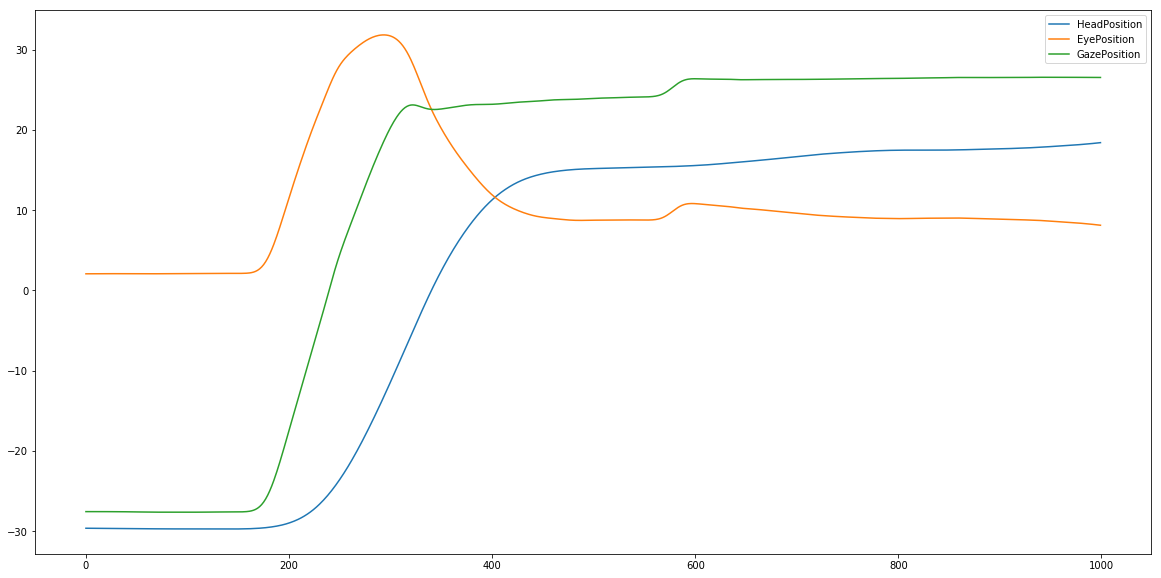

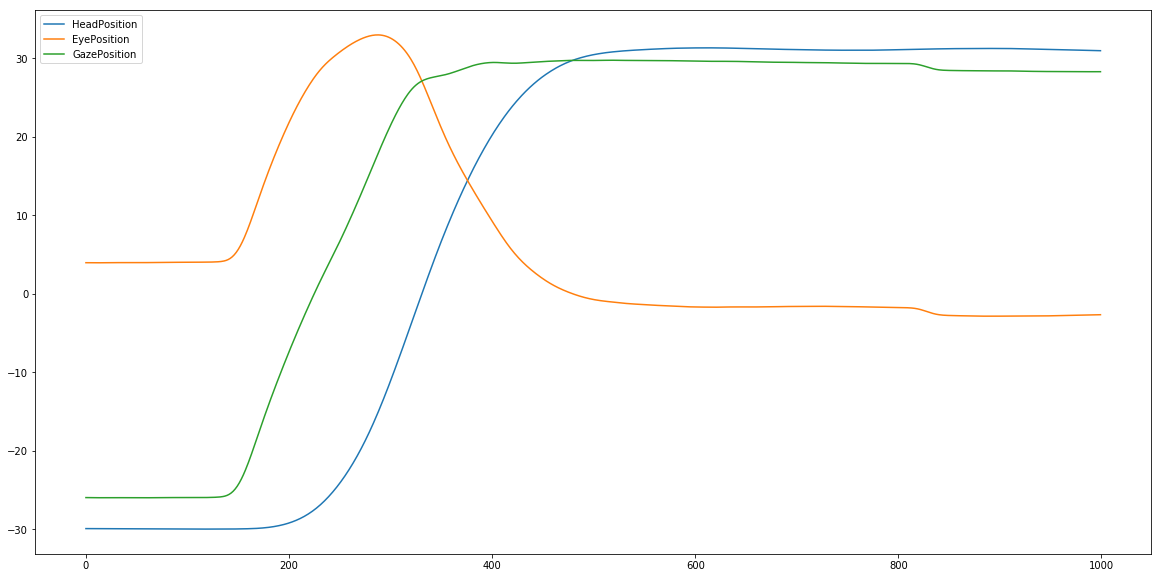

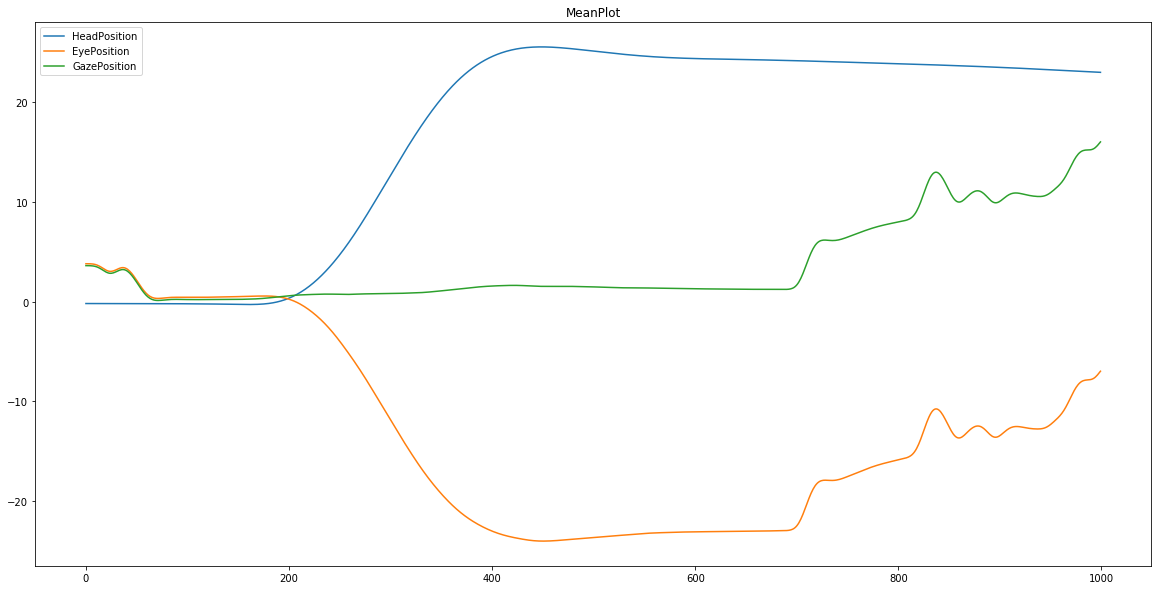

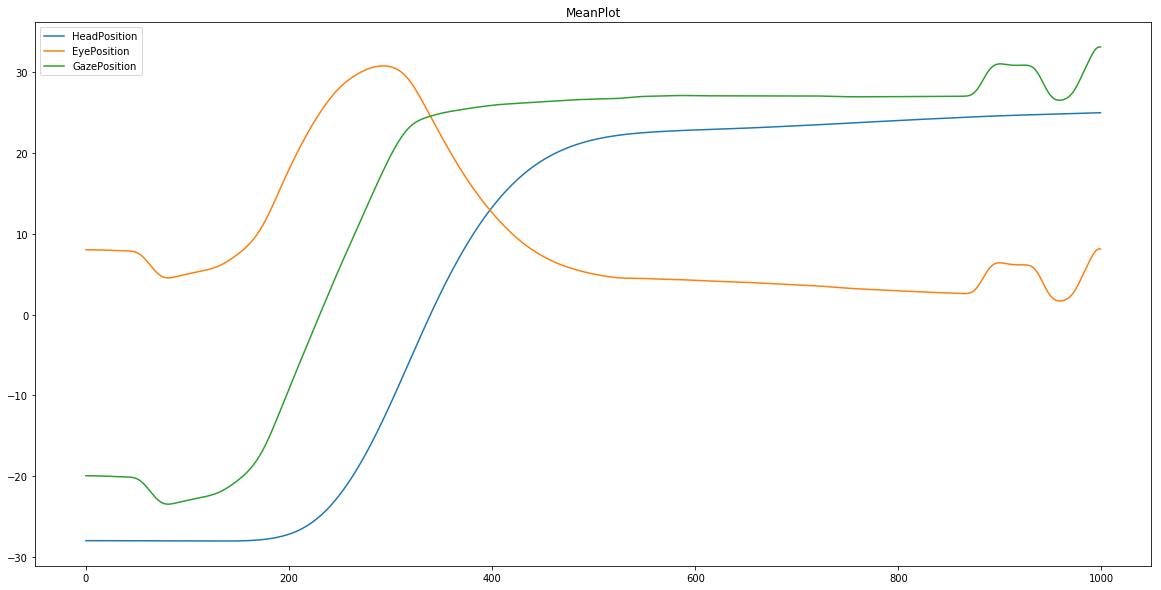

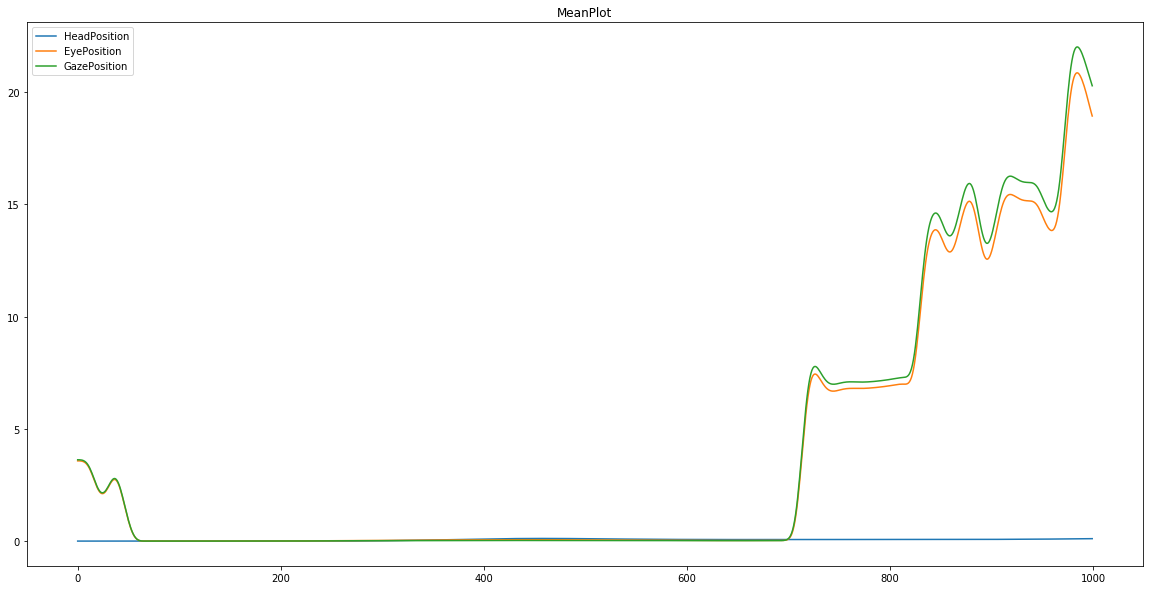

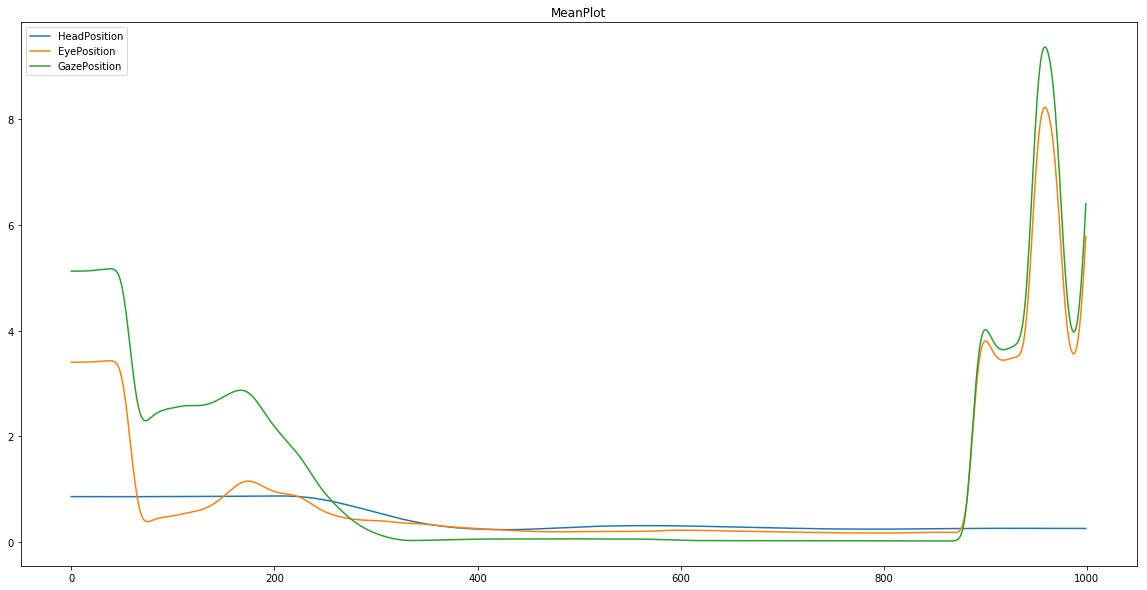

In [24]:
S_index += 1
sub_para = ["AcuityLog_2019_08_30_03_30_50.txt",\
            "AcuityLog_2019_08_30_03_55_04.txt",\
            "JumpLog__2019_08_30_03_30_50.txt",\
            "JumpLog__2019_08_30_03_55_04.txt",\
            "JumpLog__2019_08_30_03_55_04_2.txt",\
            "AcuityLog_2019_08_30_04_11_56.txt",\
            "",\
            "S1data.mat",\
            "1"]
DY_DL = [7,10,]
GA_DL = [8,9,10,11]
run_subject(sub_para, DY_DL = DY_DL, GA_DL = GA_DL)

In [25]:
def mix_plot():
    handles = []
    for SS in StaticSections:
        tpl = plot_ac(SS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"StaticMix"+".png")
    pyplot.show()
    
    handles = []
    for DS in DynamicSections:
        tpl = plot_ac(DS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"DynamicMix"+".png")
    pyplot.show()
    
    handles = []
    for DDS in DY_delaySections:
        tpl = plot_delay(DDS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"DynamicDelayMix"+".png")
    pyplot.show()
    
    handles = []
    for GDS in GA_delaySections:
        tpl = plot_delay(GDS,lab_mode = 1)
        handles.append(tpl)
        pyplot.legend(handles=handles)
    pyplot.savefig(SavePath+"GazeDelayMix"+".png")
    pyplot.show()

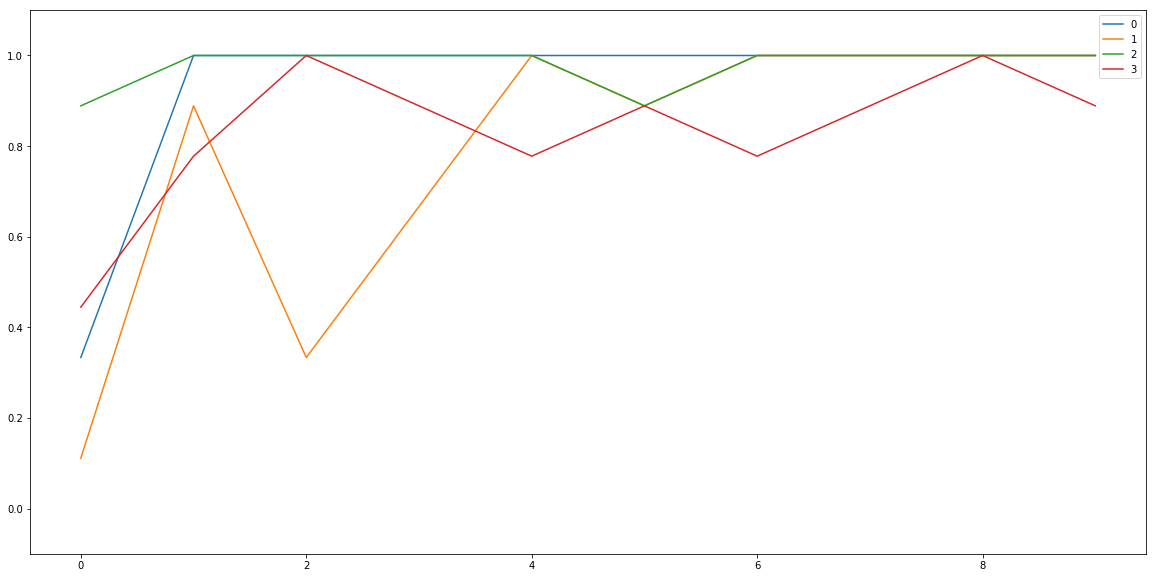

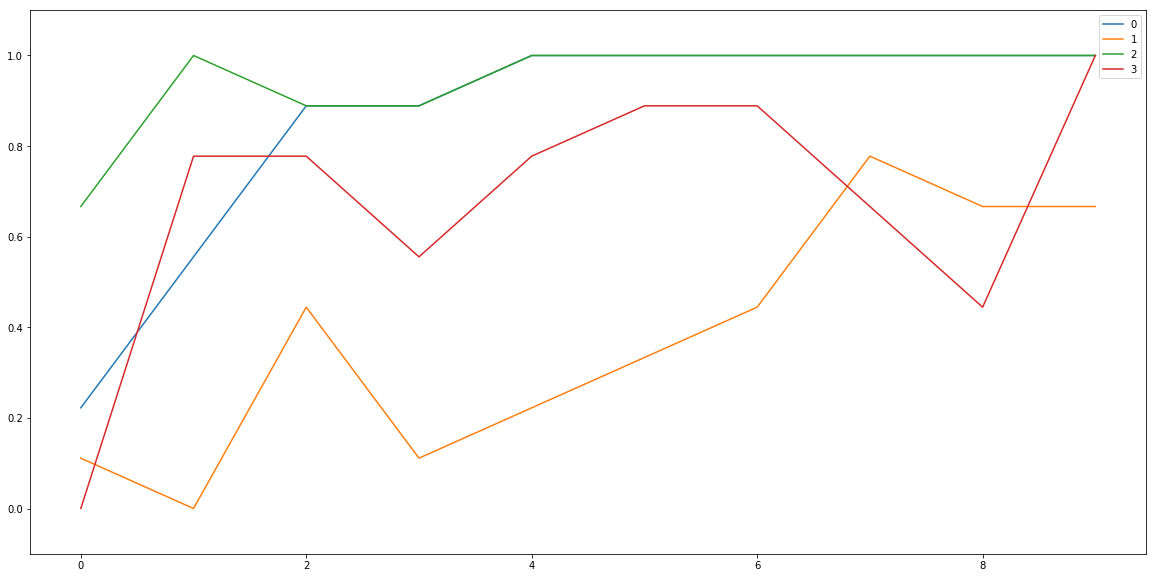

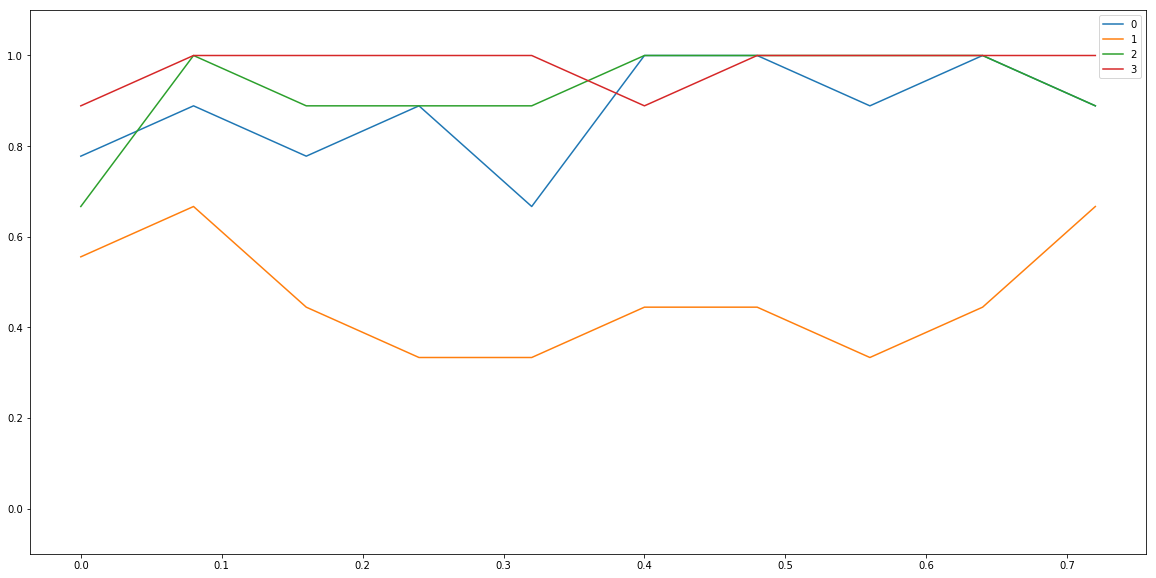

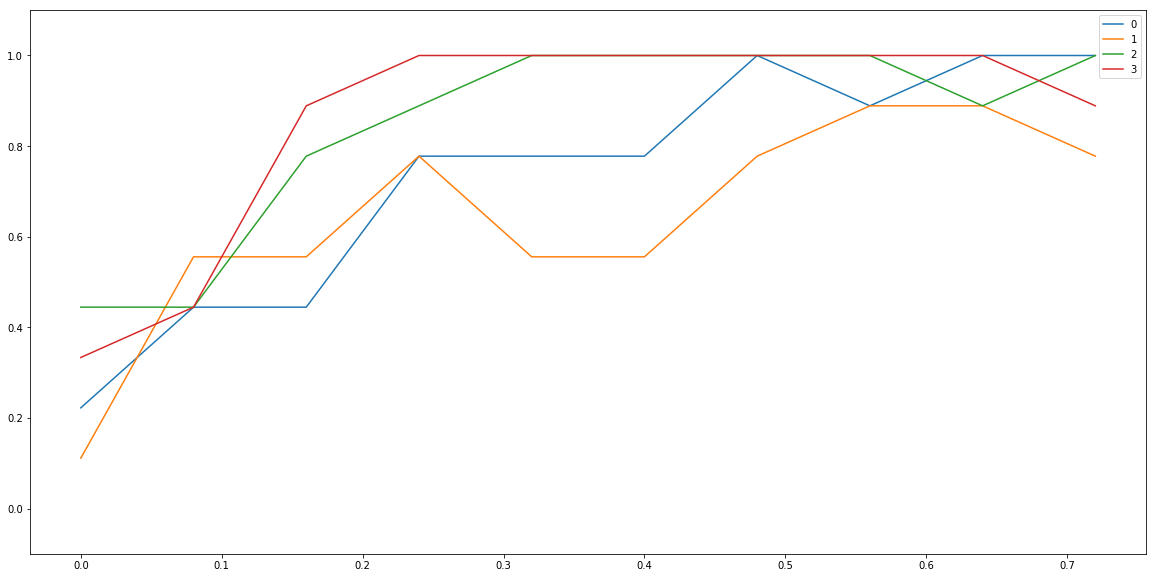

In [26]:
mix_plot()